<a href="https://colab.research.google.com/github/marcinwolter/MedicalPictures/blob/master/figure_jpeg_cnn_reco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code generating geometrical figures and performing pattern recognition using Deep NN

*Feb. 2020, Marcin Wolter*

In [1]:
'''Trains a simple convnet on the generated set of figures (circle, triangle, square)
'''
from __future__ import print_function

#install KERAS if not there
!pip install keras_sequential_ascii

import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation
from keras import backend as K
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from PIL import Image, ImageDraw

import time
import math



  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-cp36-none-any.whl size=3062 sha256=5d5cc690ef59f32c4887b7af511dccece2b6e51b762e18668f749637b4895502
  Stored in directory: /root/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


Using TensorFlow backend.


# **Setup the parameters**

In [0]:
# DNN parameters
batch_size = 128
# number of classes
num_classes = 2
epochs = 256 #12

np.random.seed(2348)

#batch_size_gen = 60000
#batch_size_val = 10000
batch_size_gen = 60000
batch_size_val = 10000

# input image dimensions
img_rows, img_cols = 32, 32
img_shape = (img_rows, img_cols)


#probability of noise and its max. brithness 
prob_noise = 1.0
ampl_noise = 0.3


# figure min and max brithness
fig_min_gray=0.4
fig_max_gray=0.9

#figure sizes
# circle radius
rmin = 0.06
rmax = 0.15
# triangle/rectangle size
dmin = 0.10
dmax = 0.30
# colon / line dot radius in pixels
rpix_min = 0.5
rpix_max = 2

# distortion type
###distortion = "blur"
distortion = "jpeg"
# jpeg_format: jpeg / jpx   - WARNING: jpx ( JPEG 2000) does not work!!!!
#jpeg_format = "jpeg"
jpeg_format = 'JPEG2000'
#jpeg_format="jpx"
# distortion - bluring sigma
sigma = (1.8,1.8)
#jpeg compression
jpeg_compression_list = [1,5,10,30,50,70,90,100]

jpeg2000_compression_list = [[100],[50],[30],[10],[4]]
# extrapolate True/False
extrapolate = True
# list of extrapolation factors
extrapolation_list = [0.125, 1., 8.]

# **Generate noise**

In [0]:
def gen_noise(batch_size_gen=batch_size_gen, img_shape=img_shape, prob_noise=prob_noise):

        batch_events = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        for n in range(batch_size_gen):

            for i in range(img_shape[0]):
               for j in range(img_shape[1]):
                 if np.random.random()<prob_noise:
                     batch_events[n,0,i,j]= min(1.,max(0.,ampl_noise*np.random.randn()))


        yield batch_events


#  Generate geometrical figures - circle, triangle, square, colon, line

In [0]:

### generate geometrical figures

def generate_circle(r, x0, y0, img_shape):
    """
    Generate a single circle.
    Parameters:
        r: radius
        x0,y0: position of the circle center
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-r, y0-r, x0+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255
    
    #print(x)
    return x

In [0]:
def generate_square(d, x0, y0, angle, img_shape):
    """
    Generate a square.
    Parameters:
        d: size
        x0,y0: position of the square center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-d/2, y0-d/2, x0+d/2, y0+d/2), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x




In [0]:
def generate_triangle(d, x0, y0, angle, img_shape):
    """
    Generate a triangle.
    Parameters:
        d: size 
        x0,y0: position of the triangle center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel grayscale
    draw = ImageDraw.Draw(image)
    dd = d/math.sqrt(3)
    draw.polygon(((x0-d/2, y0-dd/2), (x0+d/2, y0-dd/2), (x0,y0+dd)), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255.
    
    #print(x)
    return x



In [0]:
def generate_line(r, x0, y0, angle, img_shape):
    """
    Generate a line.
    Parameters:
        r: width, length = 5*r
        x0,y0: position of the line center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-2.5*r, y0-r, x0+2.5*r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [0]:
def generate_colon(r, x0, y0, angle, img_shape):
    """
    Generate a colon.
    Parameters:
        r: dot radius
        x0,y0: position of the colon center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-1.5*r-r, y0-r, x0-1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    draw.ellipse((x0+1.5*r-r, y0-r, x0+1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [0]:


# generate a random number
def rand_interval(a = 0., b = 1.):
   rnd = a + (b-a)*np.random.random()
   return rnd


# **Random figure generator**

In [0]:
# Generator for random figures
# Each image contains exactly one object (circle, triangle, square)
def gen_n_figures(batch_size_gen=batch_size_gen, img_shape=img_shape):

        batch_events  = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        batch_targets =-np.ones((batch_size_gen, 1, 1 ))

        for n in range(batch_size_gen):
            
            k = np.random.randint(0,num_classes)

            
            rpix = rand_interval(rpix_min,rpix_max)
            r = rand_interval(img_cols*rmin, img_cols*rmax)
            d = rand_interval(img_cols*dmin, img_cols*dmax) 
            l = rand_interval(img_cols*dmin, img_cols*dmax)
            x0 = rand_interval(0.33*img_cols, 0.66*img_cols)       
            y0 = rand_interval(0.33*img_rows, 0.66*img_rows)     
            alpha = 360.*np.random.random()  

            if k == 0:
               batch_events[n,0] = generate_colon(rpix, x0, y0, alpha, img_shape)
            elif k == 1:
               batch_events[n,0] = generate_line(rpix, x0, y0, alpha, img_shape)  
            elif k == 2:                
               batch_events[n,0] = generate_circle(r, x0, y0, img_shape)
            elif k == 3:
               batch_events[n,0] = generate_square(d, x0, y0, alpha, img_shape)
            elif k == 4:
               batch_events[n,0] = generate_triangle(l, x0, y0, alpha, img_shape)                             
            else:
               print("Wrong figure id!!!")
            batch_targets[n,0] = k
            


        yield batch_events, batch_targets



# **Distort an image** 
Distortion might be either bluring or a conversion to jpeg and back.

In [0]:
# Distort images
from scipy import ndimage
#PILlow package
from PIL import Image
from io import BytesIO
import scipy.misc

def distort_n_figures(images, jpeg_compression, distortion=distortion, img_shape=img_shape, sigma = sigma):
  
  if (distortion == "blur"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    for n in range(len(images)):
     
    
      images_distorted[n,0] = ndimage.gaussian_filter(255.*images[n,0], sigma=sigma)/255.
#      images_distorted[n,0] = images[n,0]

    return images_distorted

  elif (distortion == "jpeg"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))

    for n in range(len(images)):
        # convert to jpeg and than back
        buffer = BytesIO()
        auxIm = Image.fromarray((255.*images[n,0]).astype(np.uint8))
        if jpeg_format == 'jpeg':
           auxIm.save(buffer, format=jpeg_format, quality=jpeg_compression)
        else:
           auxIm.save(buffer, format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression)   
        buffer.seek(0)
        auxIm = Image.open(buffer)

        # resize image and then resize back to the original size using BICUBIC
        if (extrapolation_factor != 1.):
           width, height = auxIm.size
           auxIm.resize((int(extrapolation_factor*width),int(extrapolation_factor*height)),resample=Image.BICUBIC)
           auxIm.resize((width,height),resample=Image.BICUBIC)

        # add image to the array of distorted images
        images_distorted[n,0] = np.array(auxIm) / 255.  
 
    return images_distorted

  else:
    return images  

## **Plot some images**

In [0]:
def plot_images(plot_size=6):

  class_names = ['colon','line','circle','square','triangle']

  offset = max(0, min(batch_size_gen-plot_size*plot_size, np.random.randint(0,batch_size_gen/2)))
  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for n in range(min(plot_size*plot_size,len(xx_train))):
    ax = plt.subplot(plot_size, plot_size, n+1)
    ax.imshow(xx_train[n+offset,0], cmap='gray', vmin=0, vmax=1)
    ax.set_title(class_names[int(yy_train[n+offset,0])])
    ax.axis('off')

  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


#plotting results of classification
def plot_results(plot_size=6):
  
  class_names = ['colon','line','circle','square','triangle']
  YY_pred = saved_model.predict(xx_val, verbose=2)
  
  offset = max(0, min(len(YY_pred)-plot_size*plot_size, np.random.randint(0,len(YY_pred)/2)))

  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for i in range(int(min(plot_size/2,len(YY_pred)/plot_size))):
    for n in range(int(min(plot_size,len(YY_pred)))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+n+1 )
      ax.imshow(xx_val[plot_size*i+n+offset,0], cmap='gray', vmin=0, vmax=1)
      ax.axis('off')

    for n in range(min(plot_size,len(YY_pred))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+plot_size+n+1)
      x = np.arange(num_classes)
      ax.bar(x, height = YY_pred[plot_size*i+n+offset,0], tick_label = class_names[0:num_classes]) 
      ax.axis('off')
#      ax.set_title(class_names[int(np.argmax(YY_pred,axis=2)[plot_size*i+n+offset])])
      ax.set_title(class_names[int(np.argmax(yy_val,axis=2)[plot_size*i+n+offset])])
#      print("yy_val",np.argmax(yy_val,axis=2))
#      print("YY_pred",np.argmax(YY_pred,axis=2))
  
  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


# **Generate training and test data**

In [0]:
def generate_datasets():

   #generate training and validation dataset
   xx_train, yy_train = next(gen_n_figures(batch_size_gen, img_shape))
   xx_test, yy_test   = next(gen_n_figures(batch_size_val, img_shape))
   xx_val, yy_val     = next(gen_n_figures(batch_size_val, img_shape))


   # add noise
   xx_train = xx_train + next(gen_noise(batch_size_gen, img_shape))
   xx_test  = xx_test  + next(gen_noise(batch_size_val, img_shape))
   xx_val   = xx_val  + next(gen_noise(batch_size_val, img_shape))

   #and distort an image
   xx_train = distort_n_figures(xx_train, jpeg_compression)
   xx_test  = distort_n_figures(xx_test, jpeg_compression)
   xx_val   = distort_n_figures(xx_val, jpeg_compression)

   #and clip to get maximum 1
   xx_train = np.clip(xx_train, 0, 1)
   xx_test  = np.clip(xx_test, 0, 1)
   xx_val   = np.clip(xx_val, 0, 1)

 
   return xx_train, xx_test, xx_val, yy_train, yy_test, yy_val

# **Draw confussion matrix**

In [0]:
# Confusion matrix result

def draw_confussion_matrix():

   from sklearn.metrics import classification_report, confusion_matrix
   YY_pred = saved_model.predict(xx_val, verbose=2)
   yy_pred = np.argmax(YY_pred, axis=2)

   yy_test2 = np.argmax(yy_test, axis=2)



   #confusion matrix
   cm = confusion_matrix(np.argmax(yy_val,axis=2),yy_pred)
   print(cm)

   # Visualizing of confusion matrix
   import seaborn as sn
   import pandas  as pd


   df_cm = pd.DataFrame(cm, range(num_classes),range(num_classes))
   plt.figure(figsize = (10,7))
   sn.set(font_scale=1.4)#for label size
   sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
   plt.show()



# **Plot training results**

In [0]:

# Plots for training and testing process: loss and accuracy
def plot_training_results(cnn):

   n_epochs = len(cnn.history['loss'])

   plt.figure(0)
   plt.plot(cnn.history['categorical_accuracy'],'r')
   plt.plot(cnn.history['val_categorical_accuracy'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Accuracy")
   plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
   plt.legend(['train','validation'])

   plt.figure(1)
   plt.plot(cnn.history['loss'],'r')
   plt.plot(cnn.history['val_loss'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Loss")
   plt.title("Training Loss vs Validation Loss")
   plt.legend(['train','validation'])
   plt.show()





# **Define Deep Neural Network**

In [0]:
# Define Model

def base_model():

    model = Sequential()
    input_shape=(1,img_rows,img_cols)

    model.add(Reshape((img_rows,img_cols,1),input_shape=input_shape))


    model.add(Conv2D(img_rows, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(img_rows,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))


    model.add(Dense(num_classes, activation='softmax'))

    model.add(Reshape((1,num_classes),input_shape=(num_classes,)))

#    sgd = SGD(lr = 0.1, decay=1e-6, nesterov=True)
#    sgd = SGD(lr = 0.01, decay=1e-6, nesterov=True)

# Train model

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[metrics.categorical_accuracy])   # 'accuracy'
    return model



# **Visualize the network**





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496    

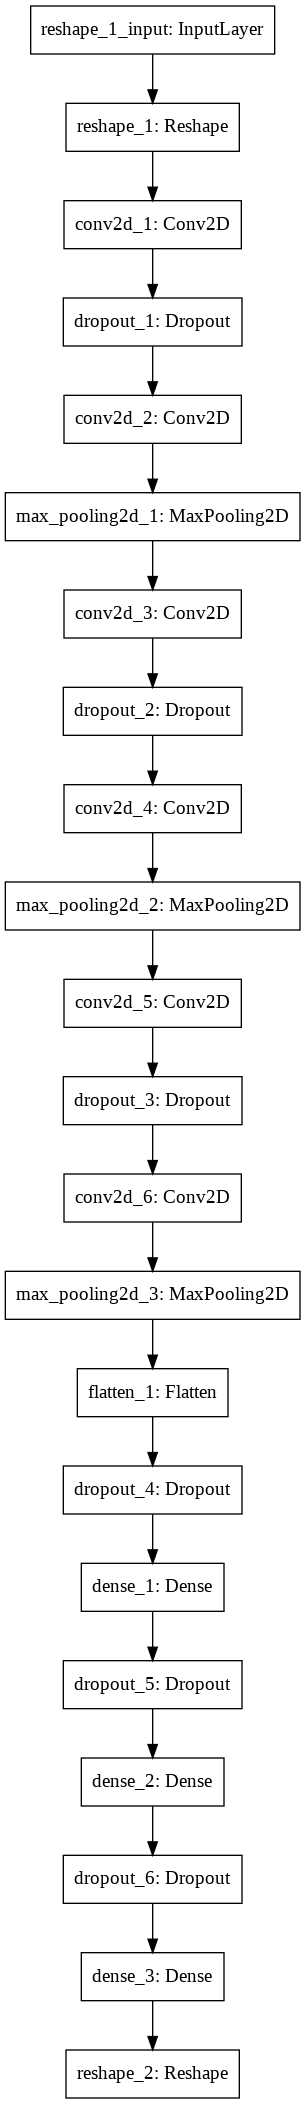

In [17]:

# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()

cnn_n.summary()

# Model printout (ascii)
sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True

# **Train DNN** and display results for various jpeg qualities given in jpeg_quality_list

 
 
Extrapolation factor =  0.125
JPEG compression =  [100]
 
 


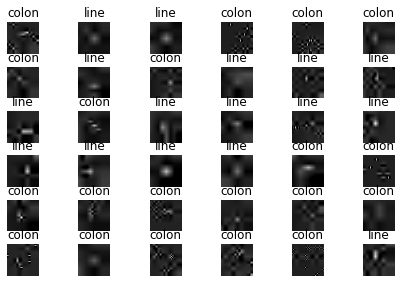

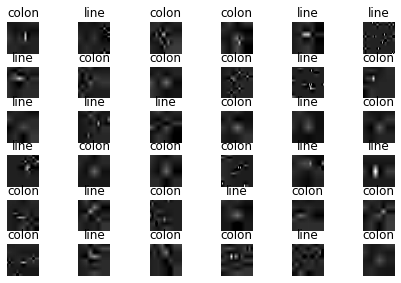

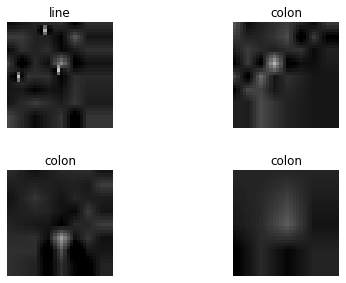

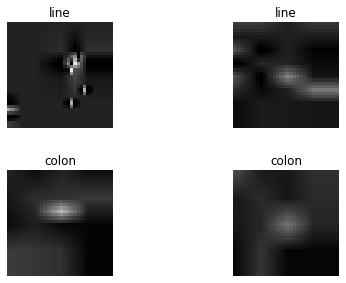

yy_train  (60000, 1, 2)
No saved model, training a new one.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/256





60000/60000 [==============================] - 26s 436us/step - loss: 0.6465 - categorical_accuracy: 0.6223 - val_loss: 0.6452 - val_categorical_accuracy: 0.6422

Epoch 00001: val_categorical_accuracy improved from -inf to 0.64220, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 164us/step - loss: 0.6386 - categorical_accuracy: 0.6322 - val_loss: 0.6547 - val_categorical_accuracy: 0.6145

Epoch 00002: val_categorical_accuracy did not improve from 0.64220
Epoch 3/256
60000/60000 [==============================] - 10s 164us/step - loss: 0.6357 - categorical_accuracy: 0.6345 - val_loss: 0.6345 - val_categorical_accuracy: 0.6374

Epoch 00003: val_categorical_accuracy did not improve from 0.64220
Epoch 4/256
60000/60000 [=====

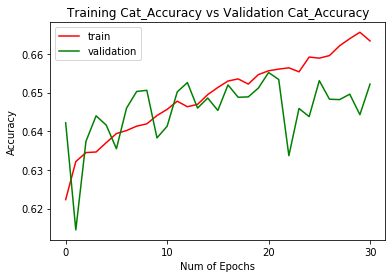

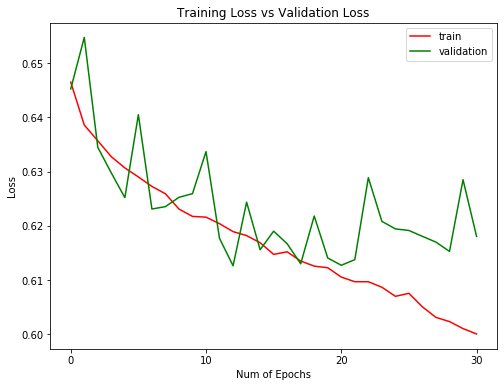

[[3728 1295]
 [2180 2797]]


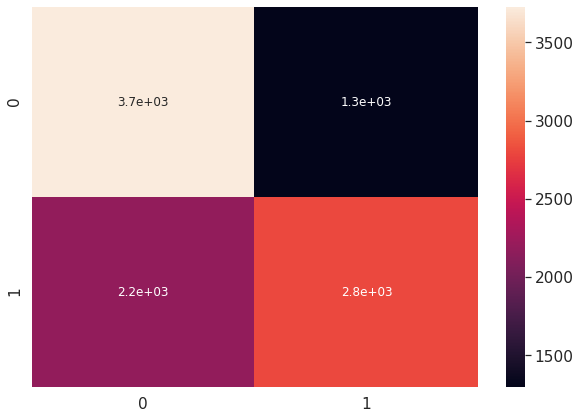

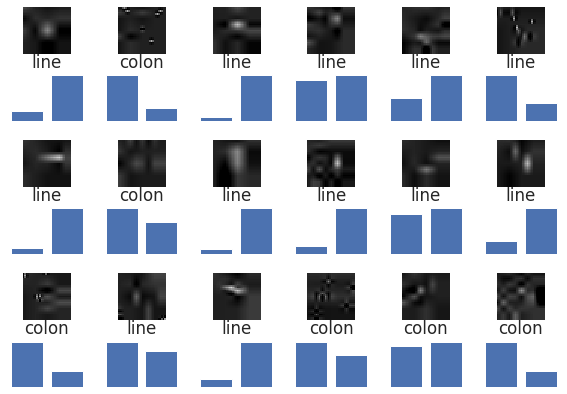

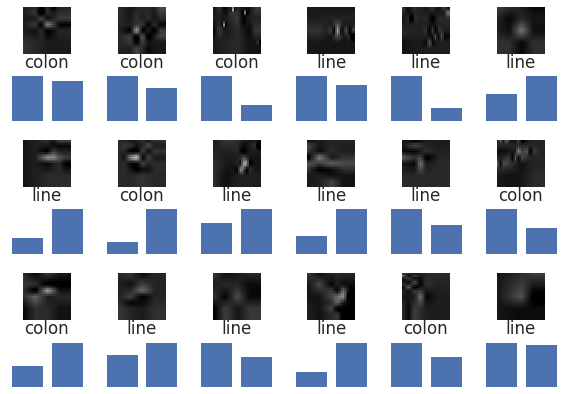

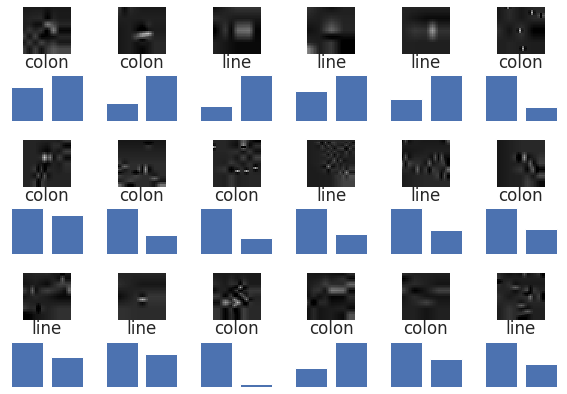

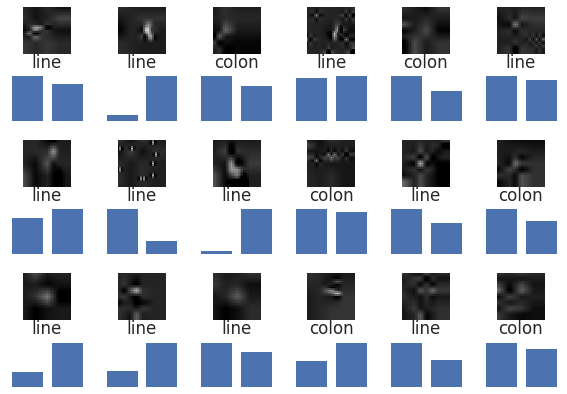

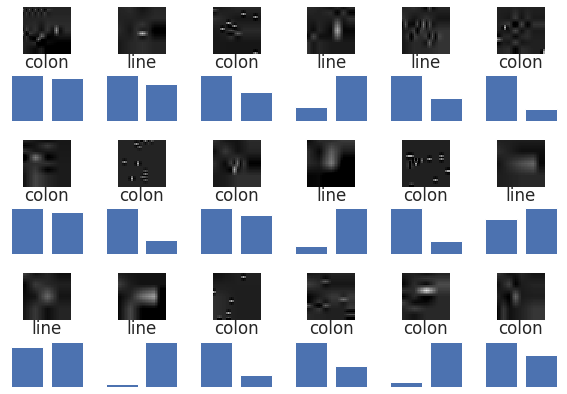

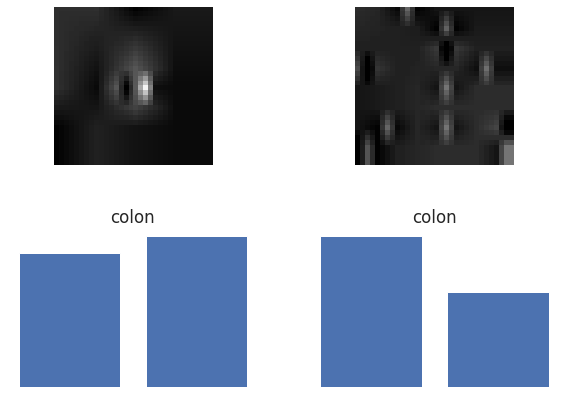

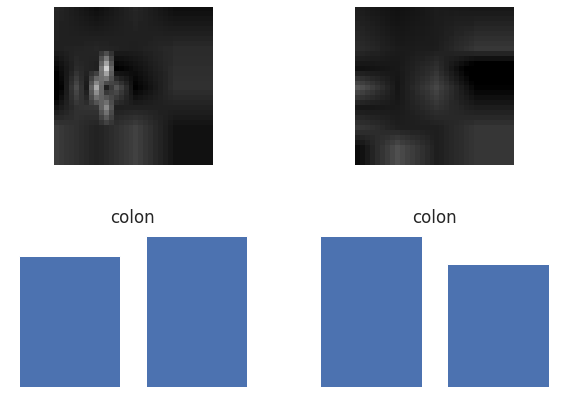

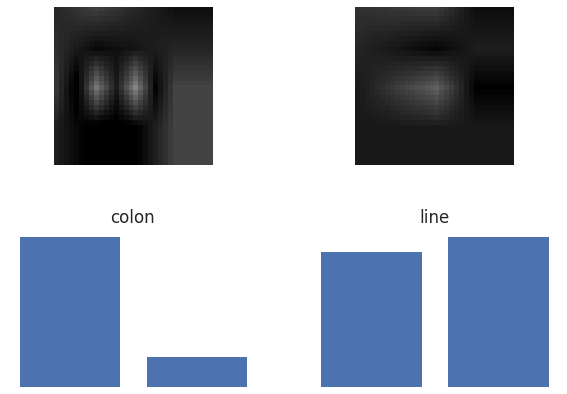

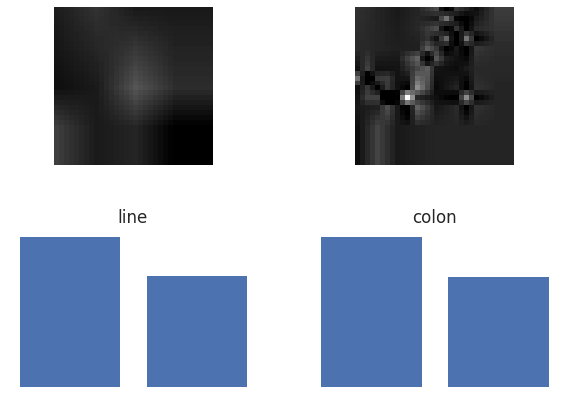

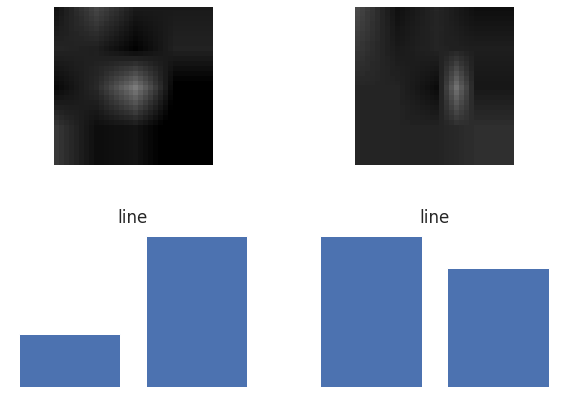

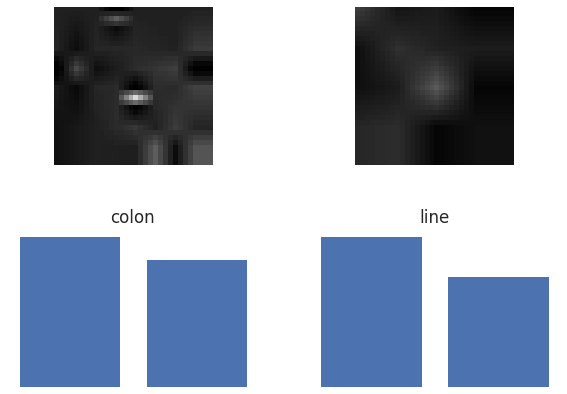

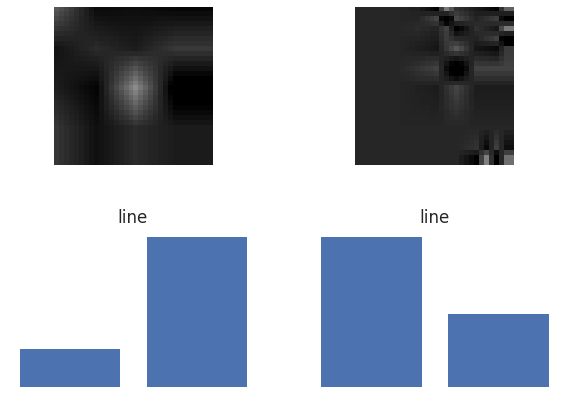

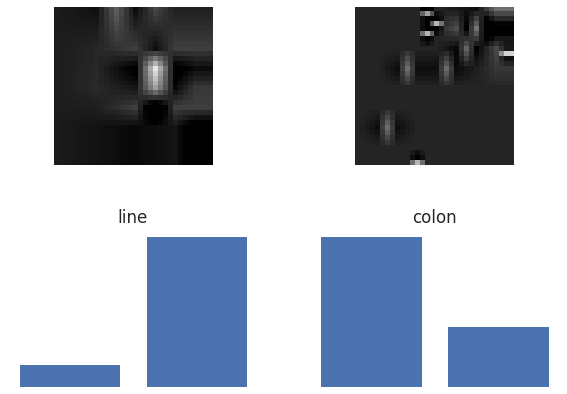

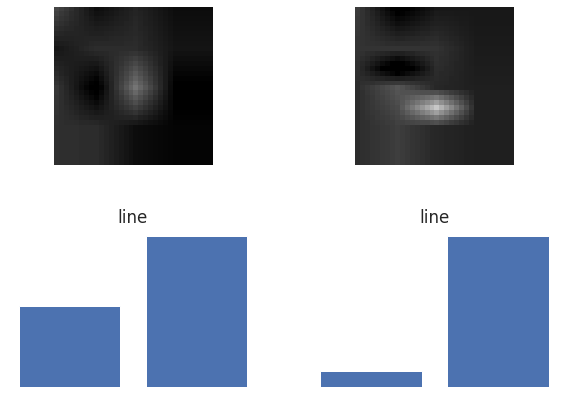

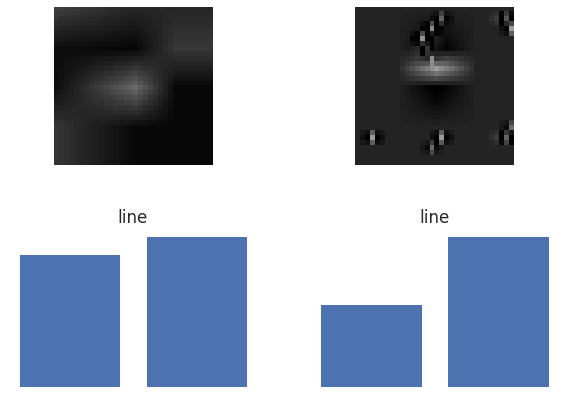

 
 
Extrapolation factor =  0.125
JPEG compression =  [50]
 
 


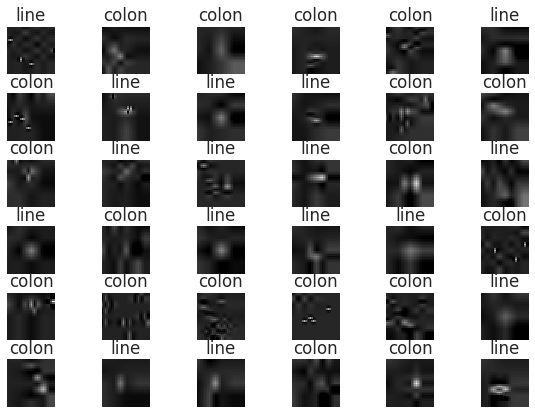

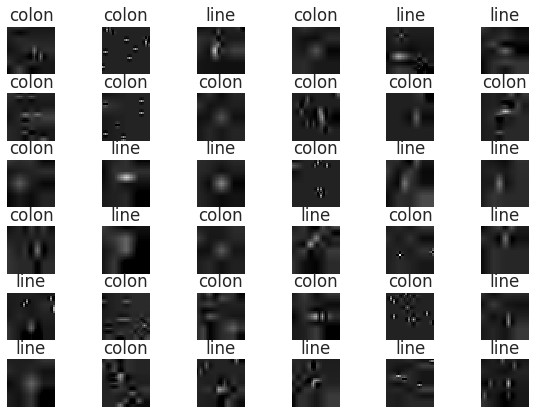

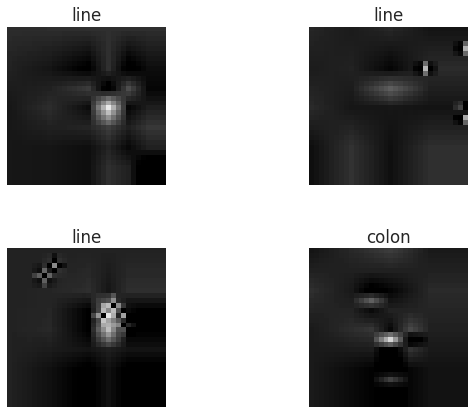

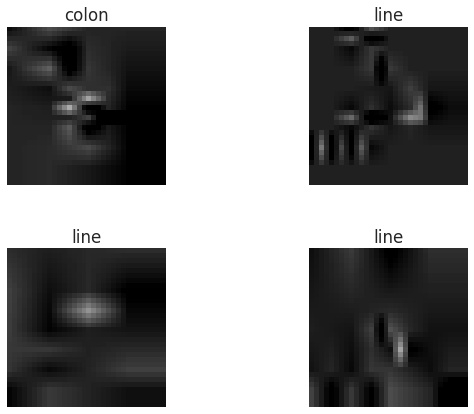

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 11s 176us/step - loss: 0.6232 - categorical_accuracy: 0.6455 - val_loss: 0.6162 - val_categorical_accuracy: 0.6509

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65090, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 165us/step - loss: 0.6197 - categorical_accuracy: 0.6479 - val_loss: 0.6144 - val_categorical_accuracy: 0.6478

Epoch 00002: val_categorical_accuracy did not improve from 0.65090
Epoch 3/256
60000/60000 [==============================] - 10s 164us/step - loss: 0.6189 - categorical_accuracy: 0.6483 - val_loss: 0.6178 - val_categorical_accuracy: 0.6455

Epoch 00003: val_categorical_accuracy did not improve from 0.65090
Epoch 4/256
60000/60000 [==============================] - 10s 164us/step - loss: 0.6167 - categorical_accuracy: 0.6496 - val_loss: 0.6152 - val_categorical_accuracy: 0

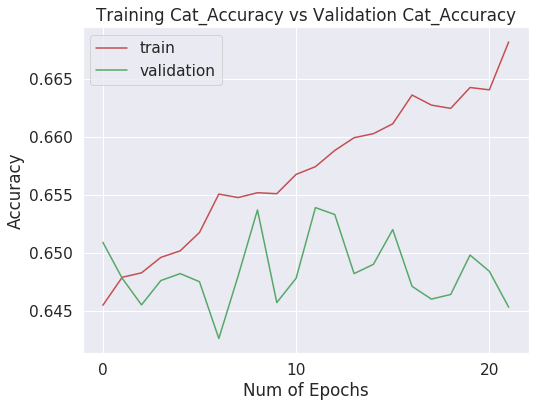

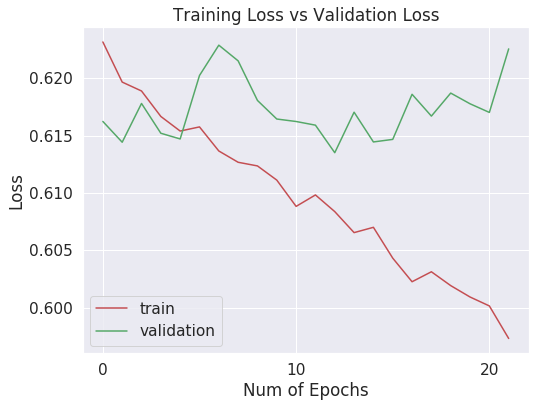

[[3373 1562]
 [1972 3093]]


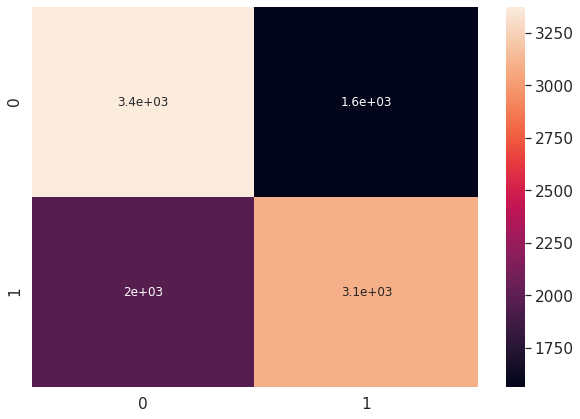

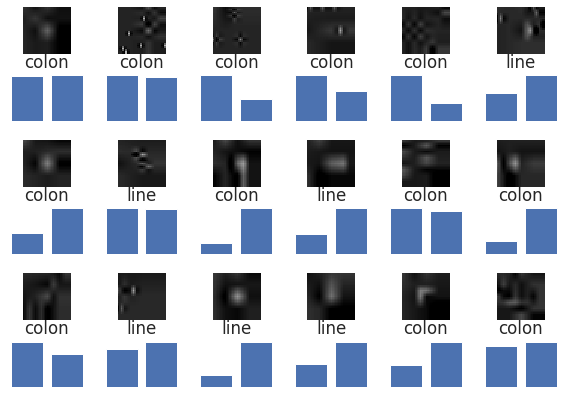

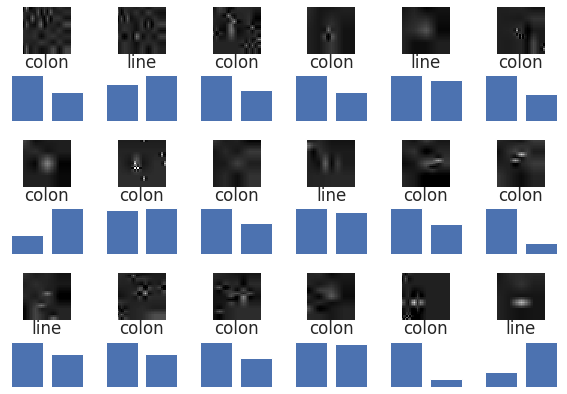

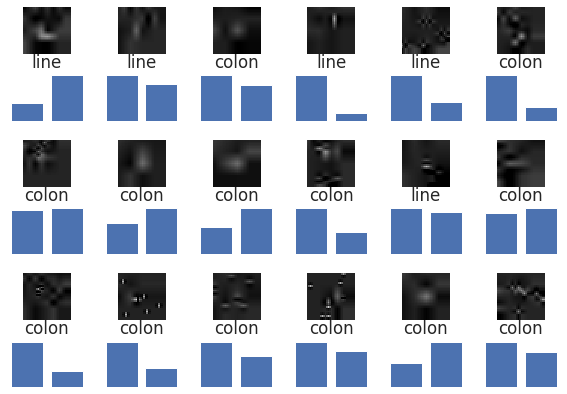

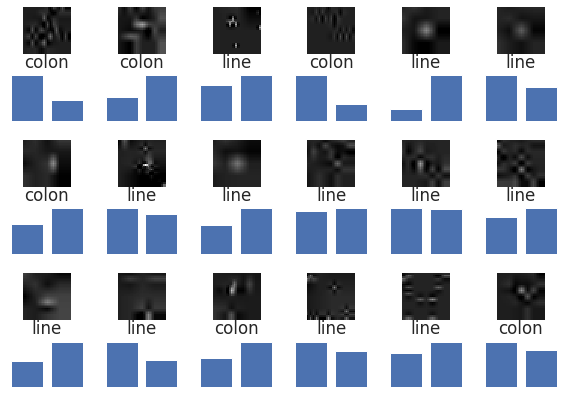

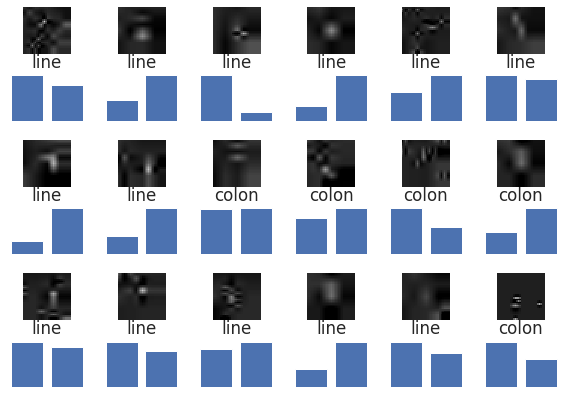

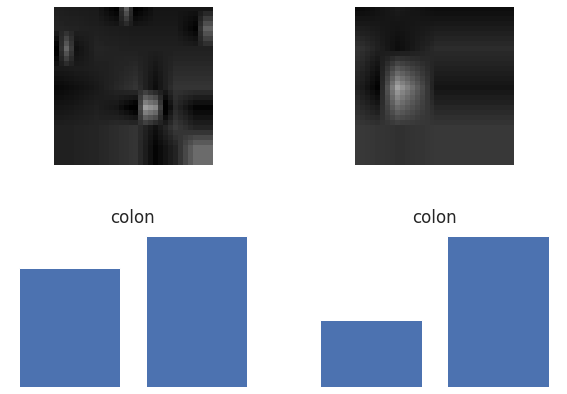

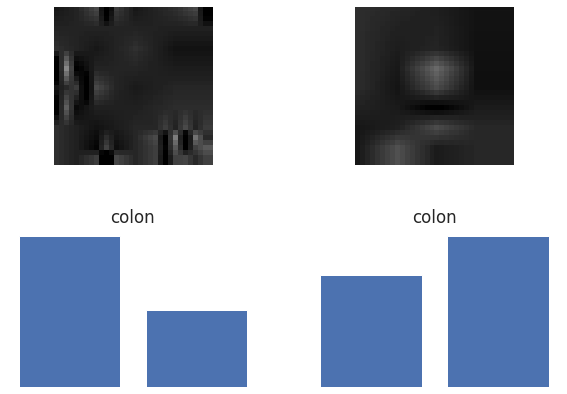

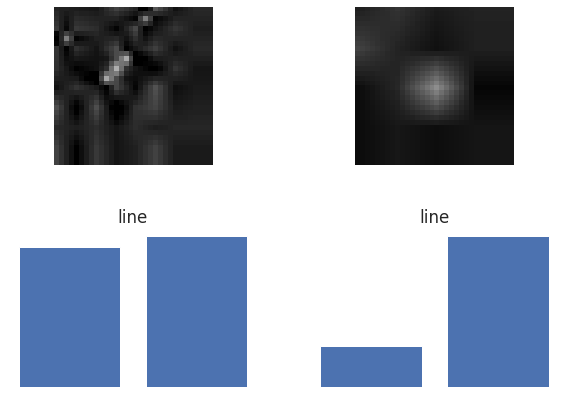

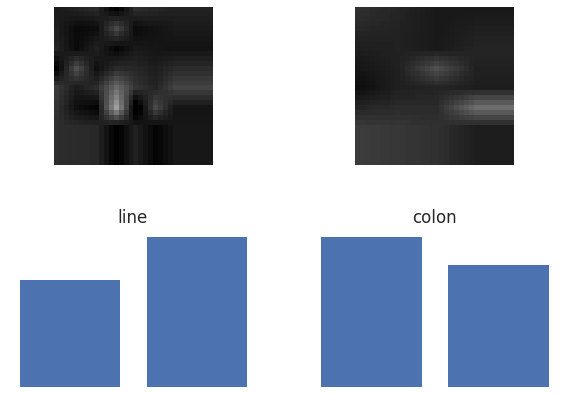

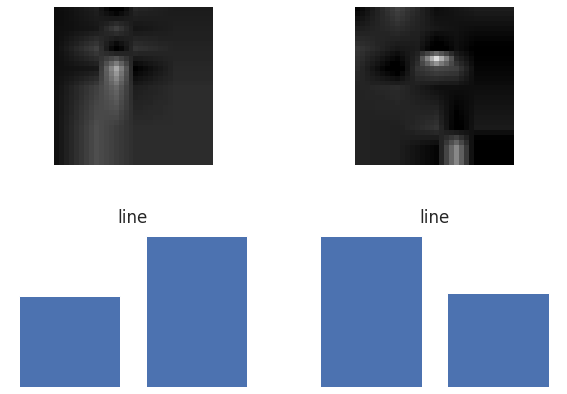

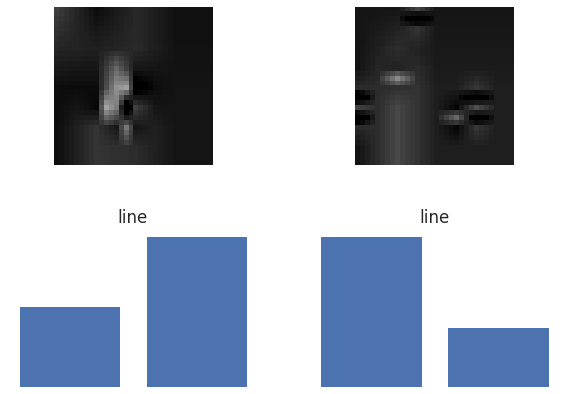

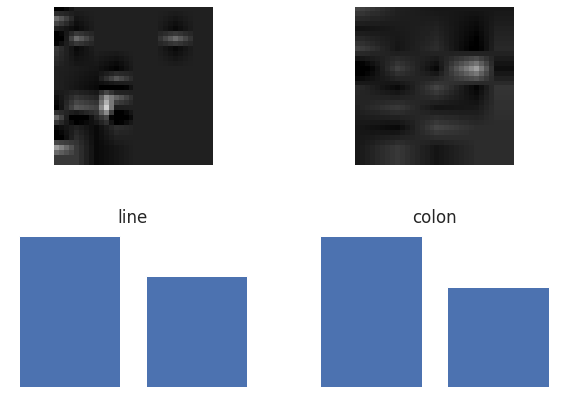

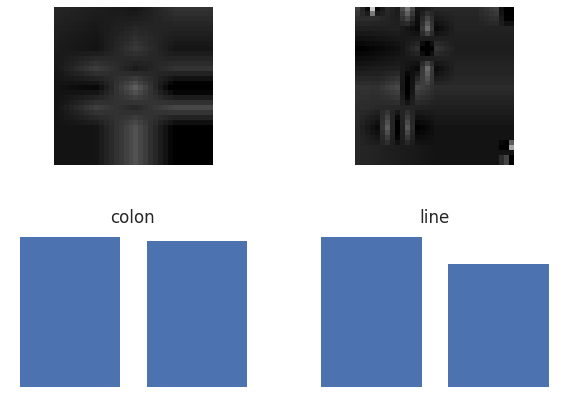

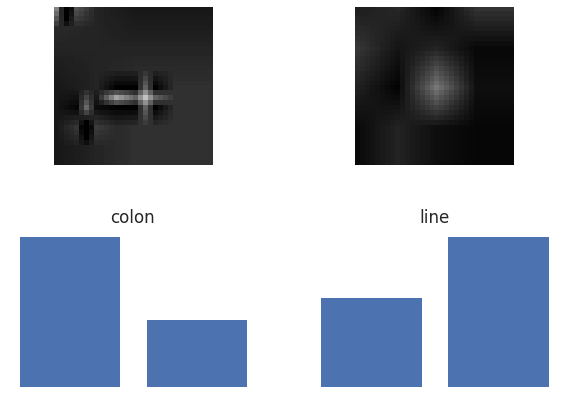

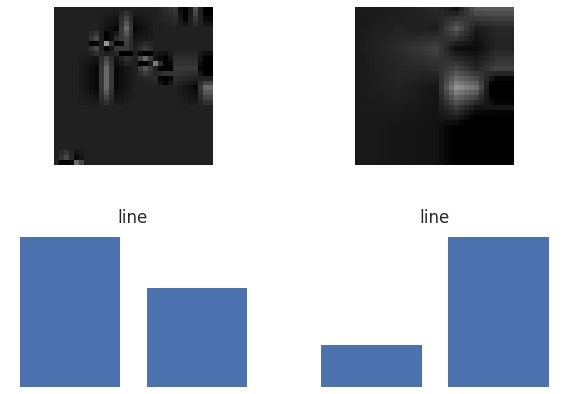

 
 
Extrapolation factor =  0.125
JPEG compression =  [30]
 
 


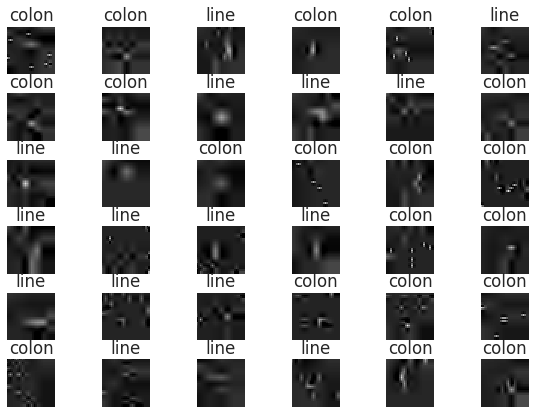

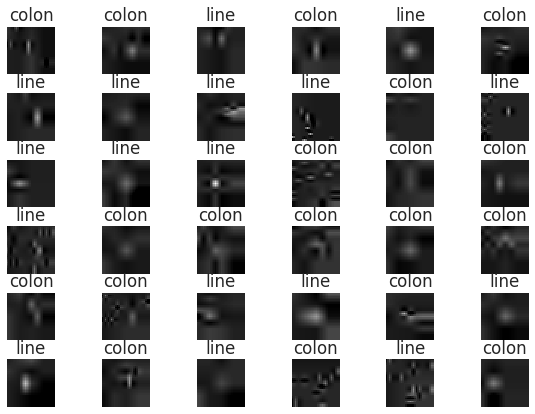

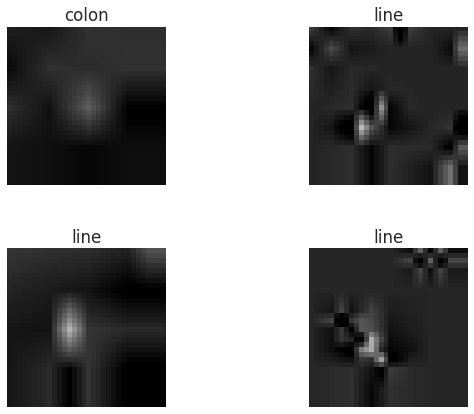

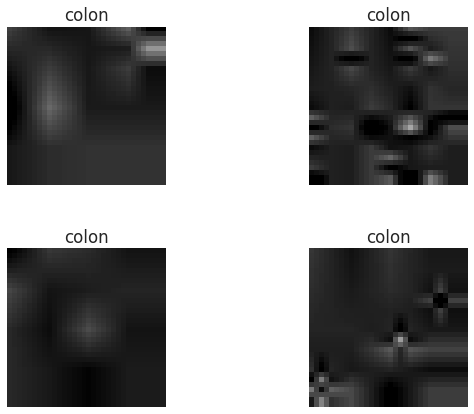

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 11s 184us/step - loss: 0.6229 - categorical_accuracy: 0.6412 - val_loss: 0.6157 - val_categorical_accuracy: 0.6552

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65520, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6213 - categorical_accuracy: 0.6455 - val_loss: 0.6315 - val_categorical_accuracy: 0.6407

Epoch 00002: val_categorical_accuracy did not improve from 0.65520
Epoch 3/256
60000/60000 [==============================] - 10s 165us/step - loss: 0.6199 - categorical_accuracy: 0.6449 - val_loss: 0.6155 - val_categorical_accuracy: 0.6501

Epoch 00003: val_categorical_accuracy did not improve from 0.65520
Epoch 4/256
60000/60000 [==============================] - 10s 165us/step - loss: 0.6179 - categorical_accuracy: 0.6470 - val_loss: 0.6128 - val_categorical_accuracy: 0

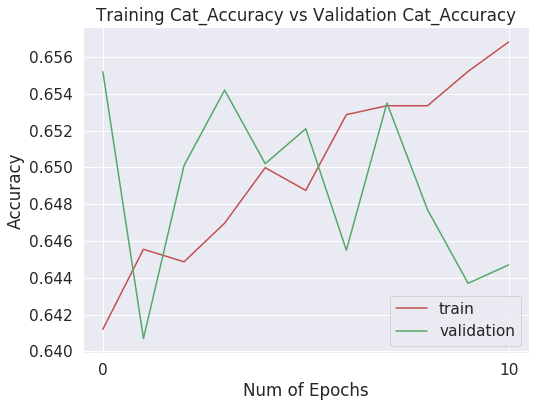

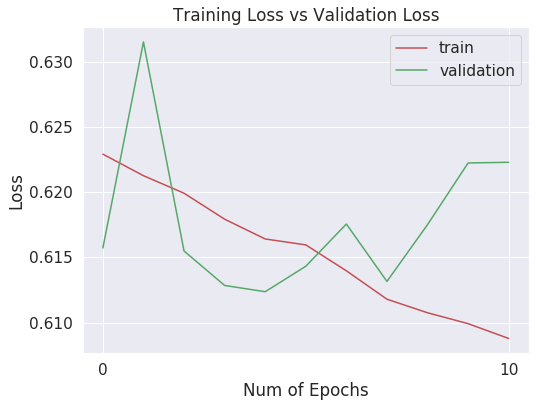

[[3674 1367]
 [2118 2841]]


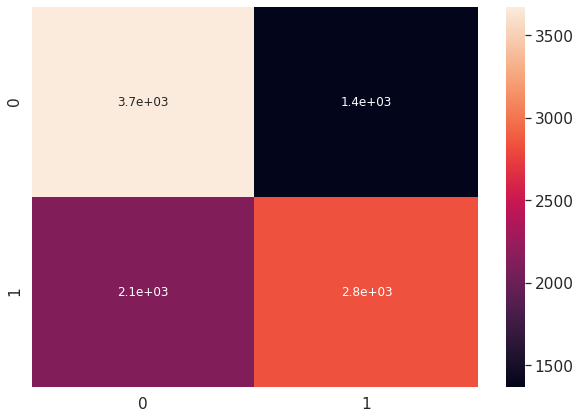

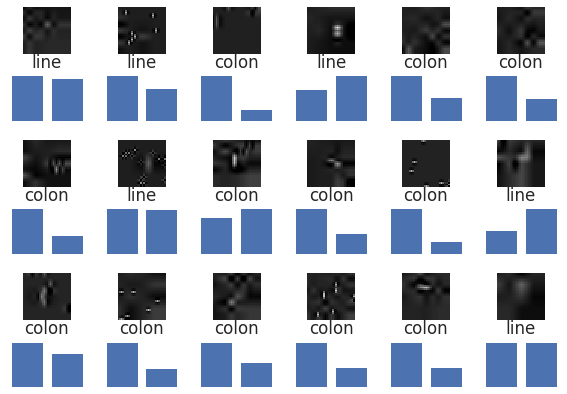

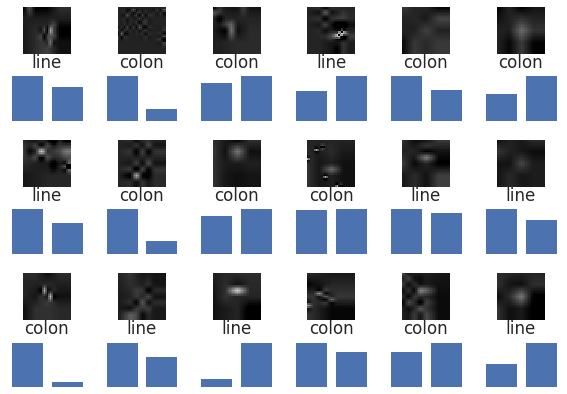

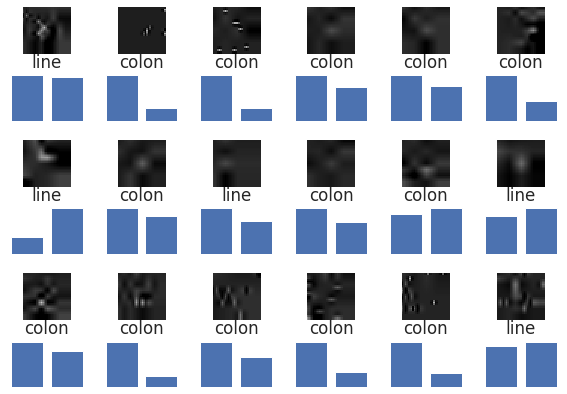

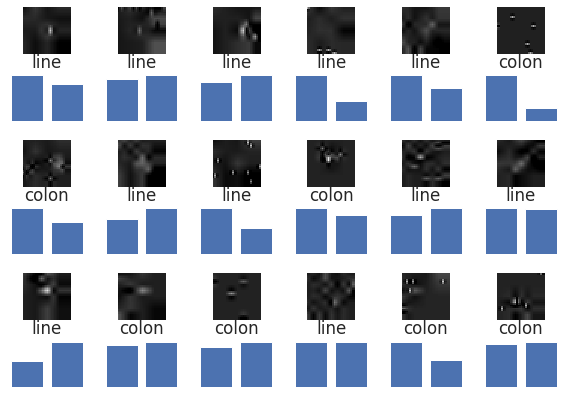

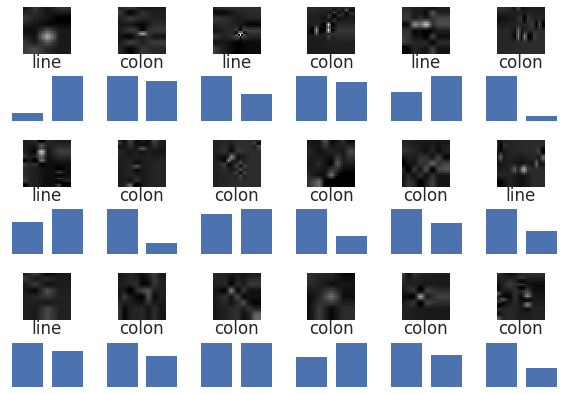

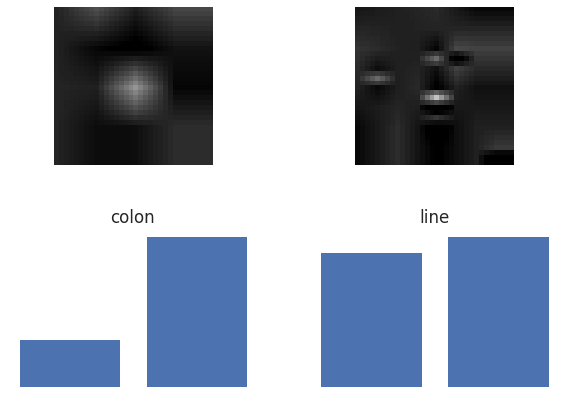

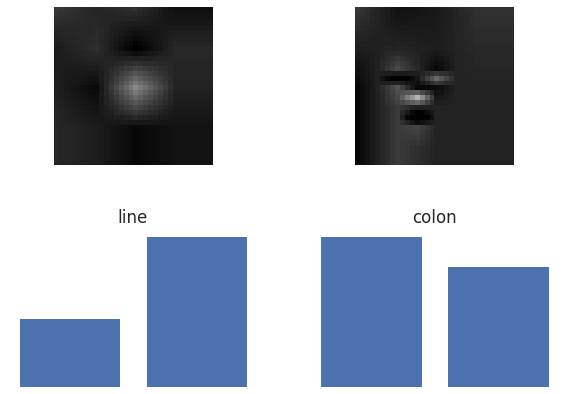

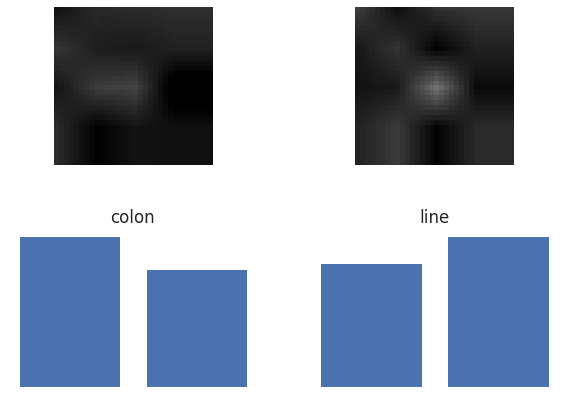

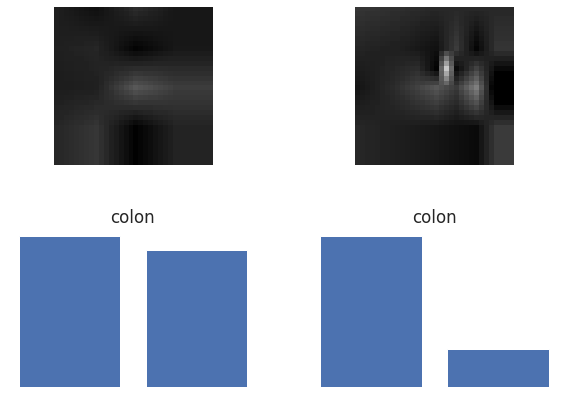

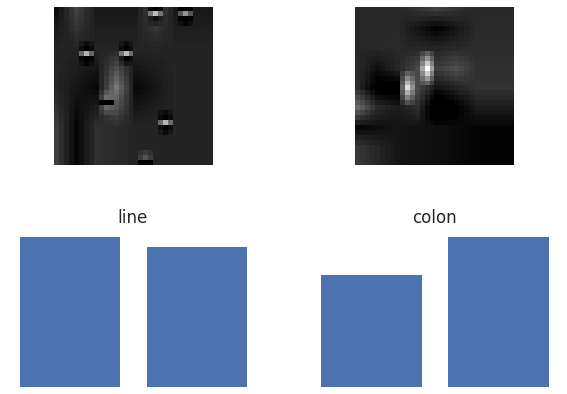

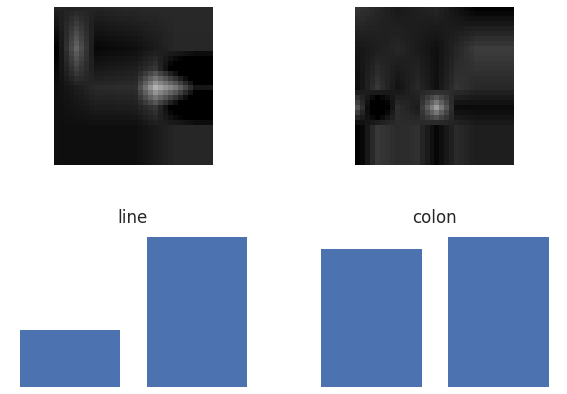

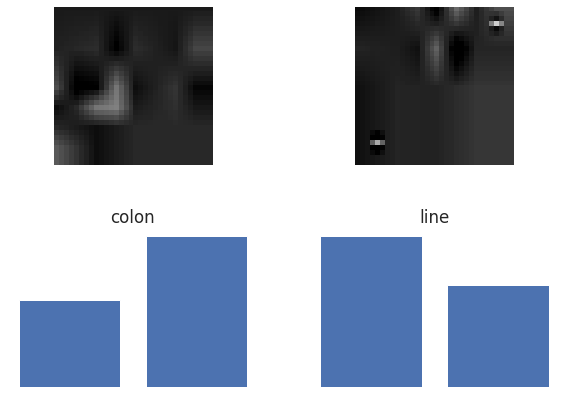

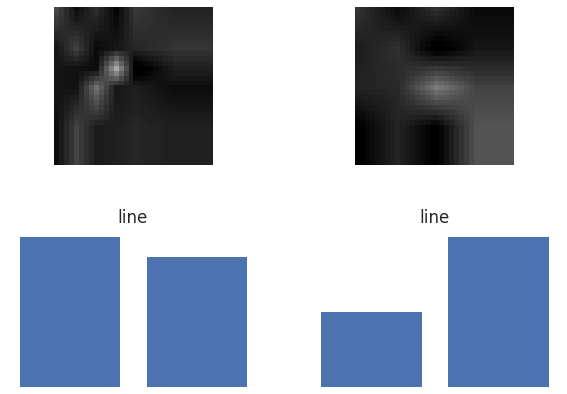

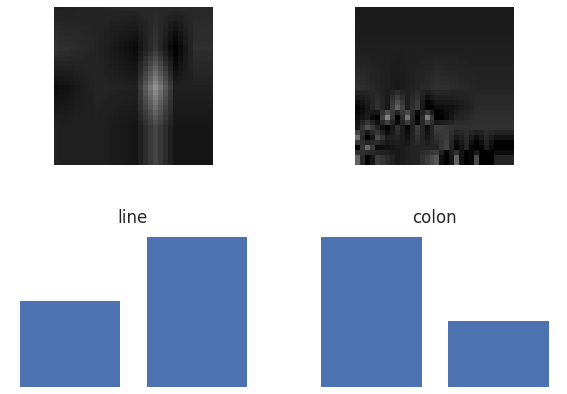

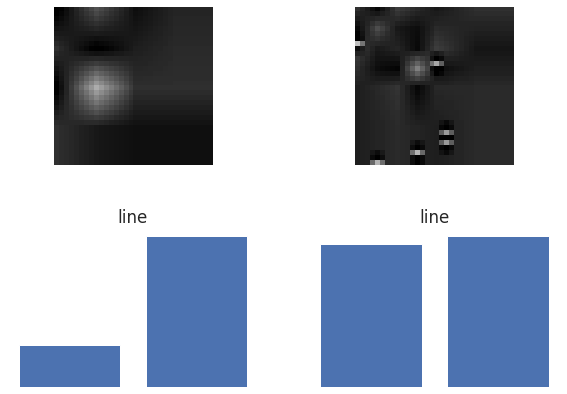

 
 
Extrapolation factor =  0.125
JPEG compression =  [10]
 
 


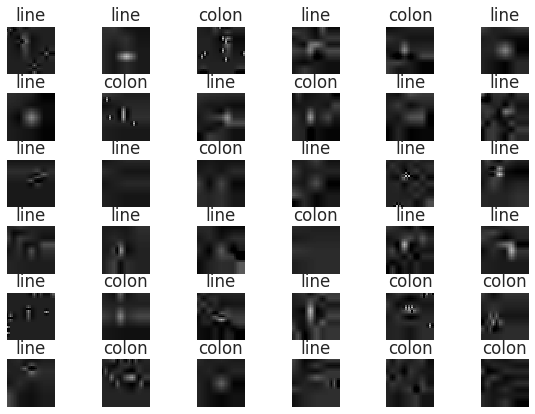

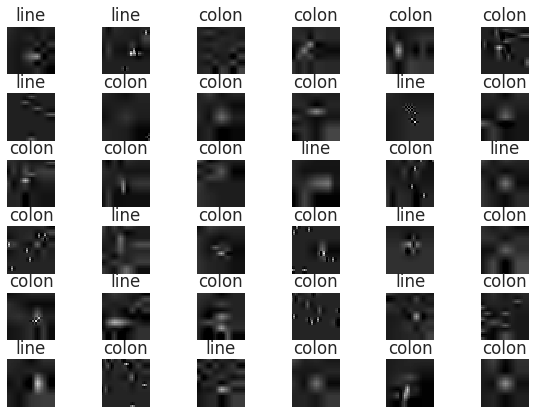

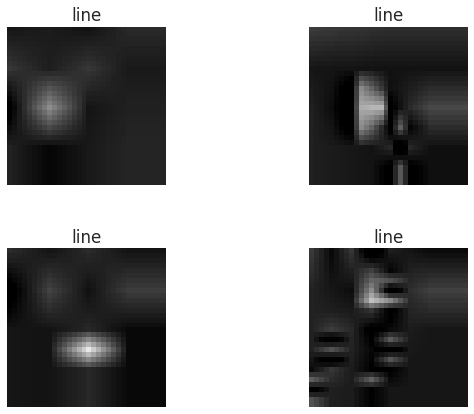

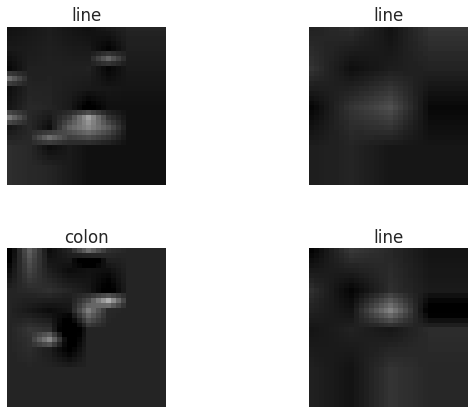

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 11s 184us/step - loss: 0.6198 - categorical_accuracy: 0.6464 - val_loss: 0.6147 - val_categorical_accuracy: 0.6533

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65330, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 167us/step - loss: 0.6179 - categorical_accuracy: 0.6487 - val_loss: 0.6167 - val_categorical_accuracy: 0.6520

Epoch 00002: val_categorical_accuracy did not improve from 0.65330
Epoch 3/256
60000/60000 [==============================] - 10s 167us/step - loss: 0.6163 - categorical_accuracy: 0.6506 - val_loss: 0.6123 - val_categorical_accuracy: 0.6549

Epoch 00003: val_categorical_accuracy improved from 0.65330 to 0.65490, saving model to best_model.h5
Epoch 4/256
60000/60000 [==============================] - 10s 166us/step - loss: 0.6160 - categorical_accuracy: 0.6521 - val_loss: 0

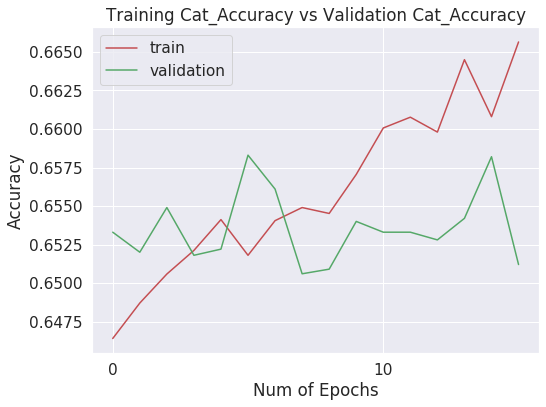

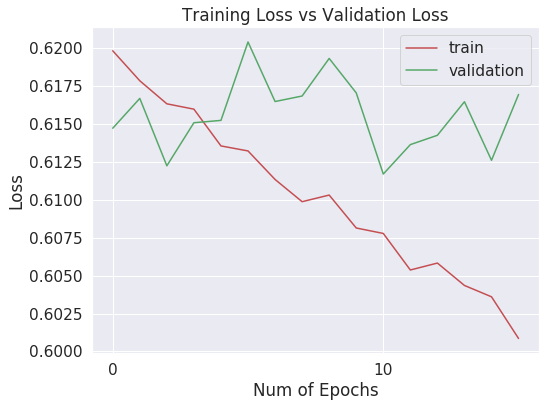

[[3715 1300]
 [2213 2772]]


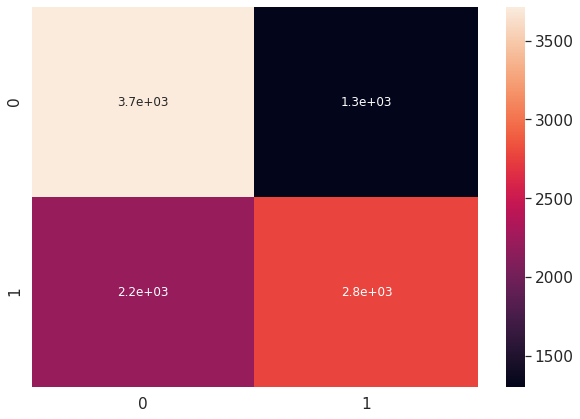

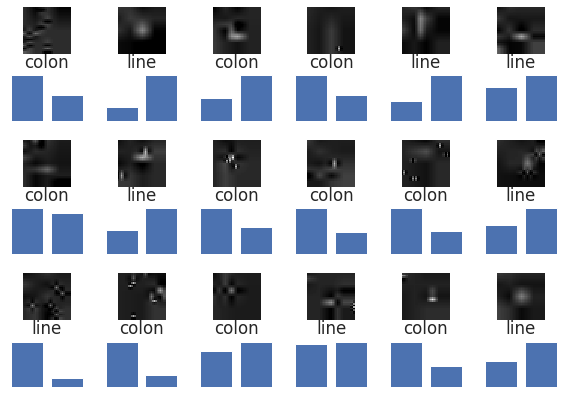

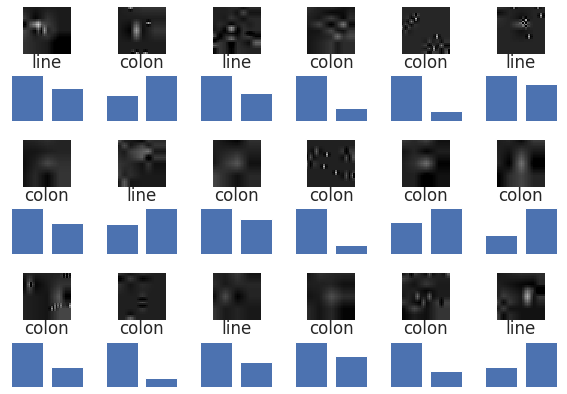

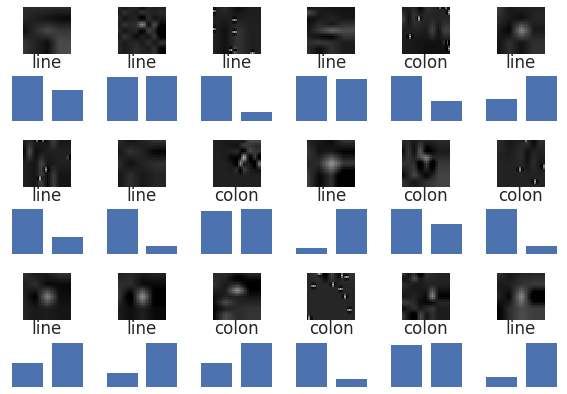

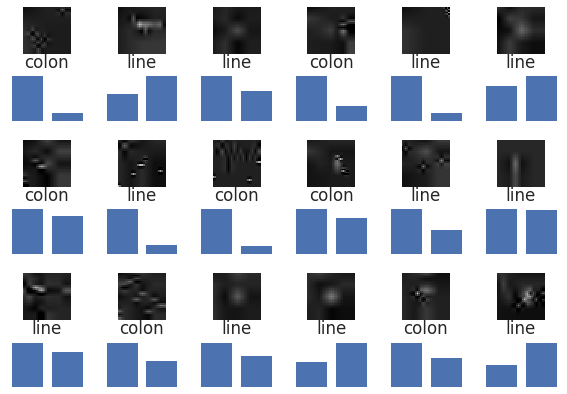

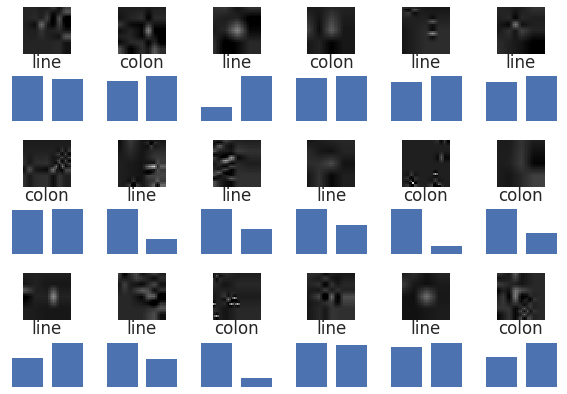

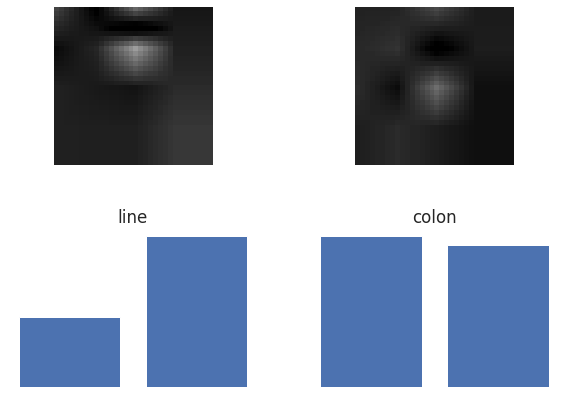

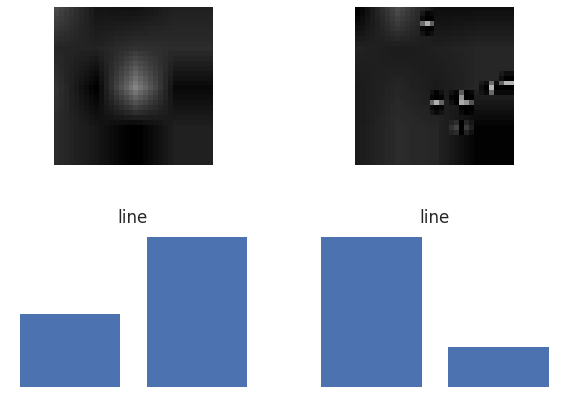

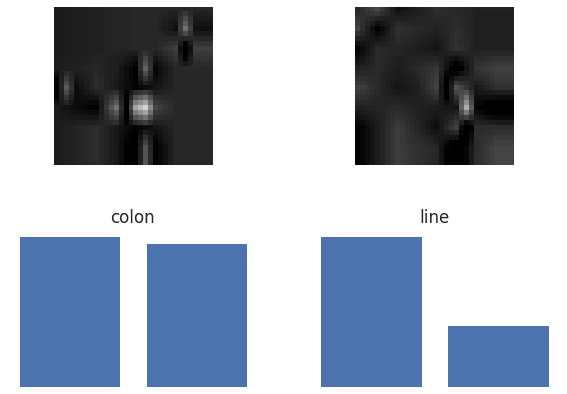

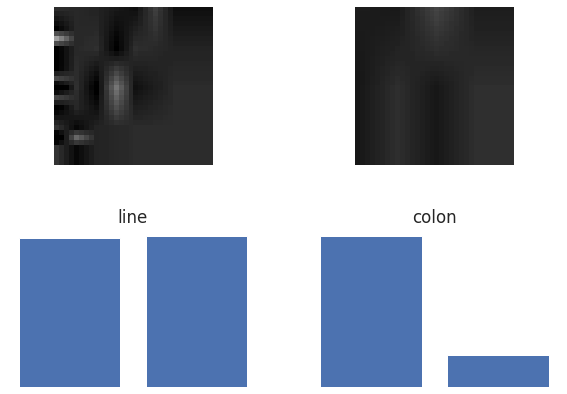

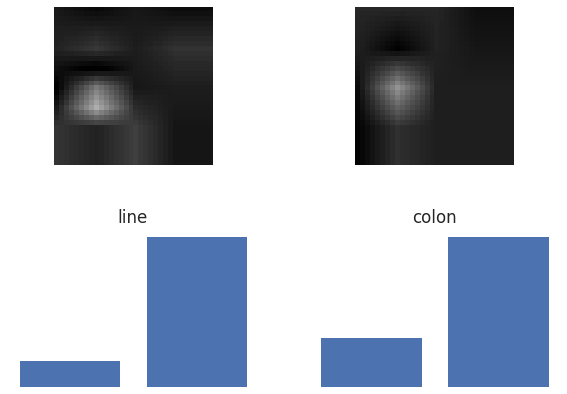

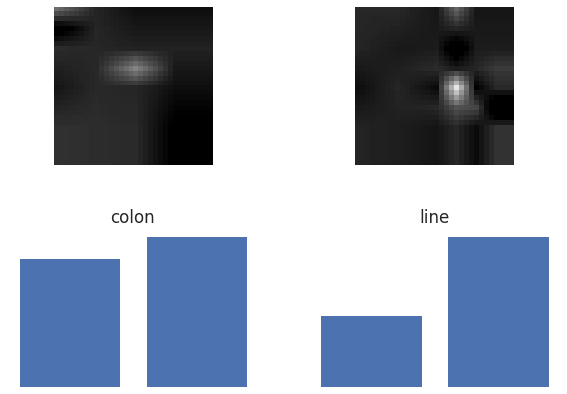

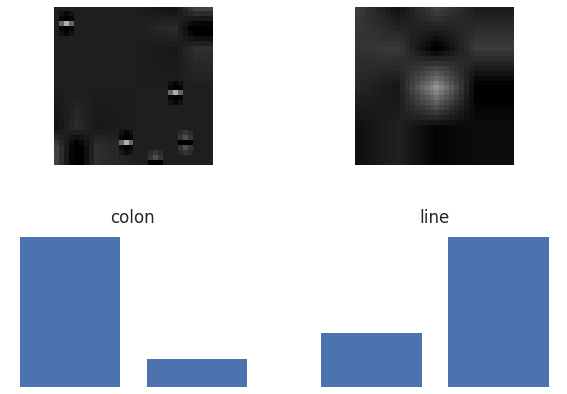

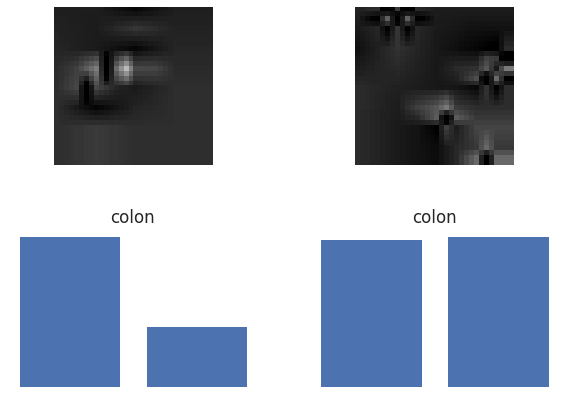

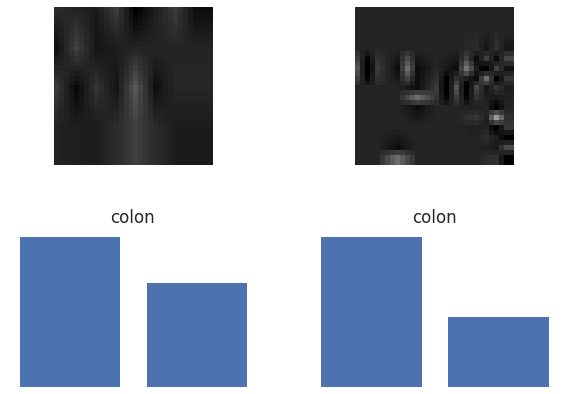

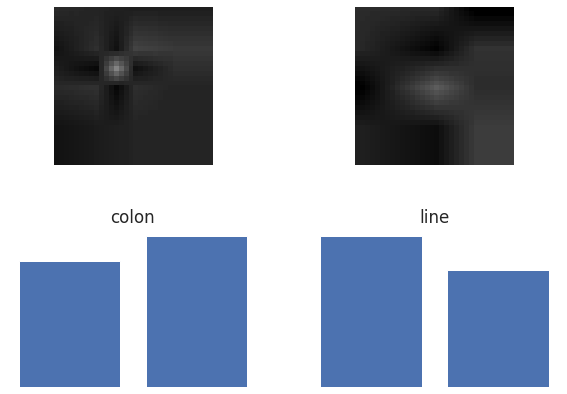

 
 
Extrapolation factor =  0.125
JPEG compression =  [4]
 
 


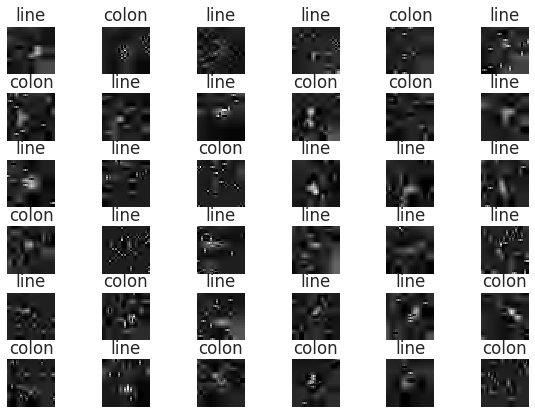

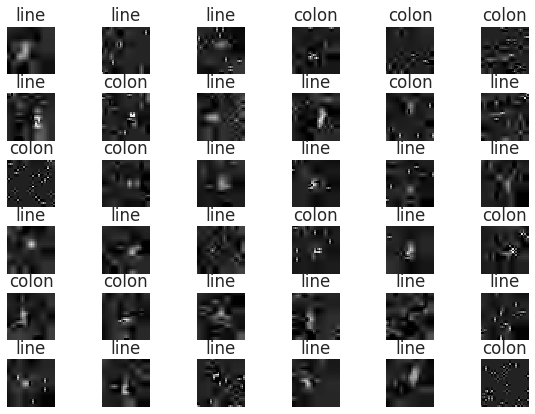

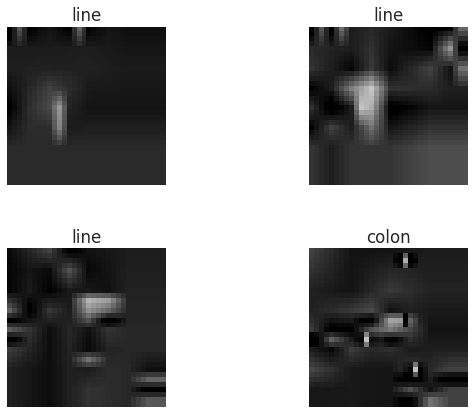

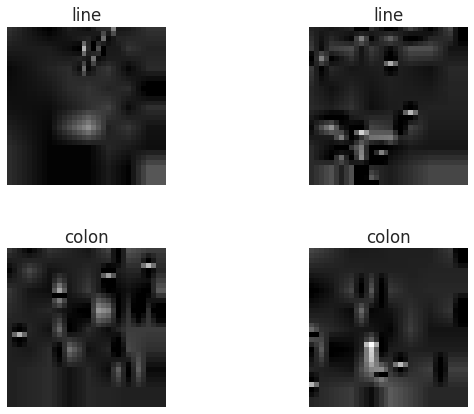

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 11s 190us/step - loss: 0.5768 - categorical_accuracy: 0.6842 - val_loss: 0.5749 - val_categorical_accuracy: 0.6899

Epoch 00001: val_categorical_accuracy improved from -inf to 0.68990, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 169us/step - loss: 0.5705 - categorical_accuracy: 0.6885 - val_loss: 0.5653 - val_categorical_accuracy: 0.6903

Epoch 00002: val_categorical_accuracy improved from 0.68990 to 0.69030, saving model to best_model.h5
Epoch 3/256
60000/60000 [==============================] - 10s 167us/step - loss: 0.5669 - categorical_accuracy: 0.6914 - val_loss: 0.5766 - val_categorical_accuracy: 0.6901

Epoch 00003: val_categorical_accuracy did not improve from 0.69030
Epoch 4/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.5635 - categorical_accuracy: 0.6949 - val_loss: 0

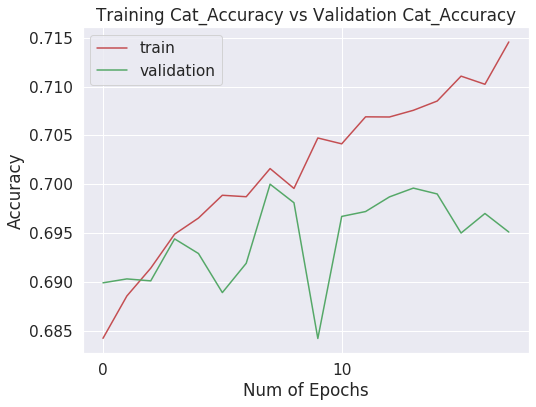

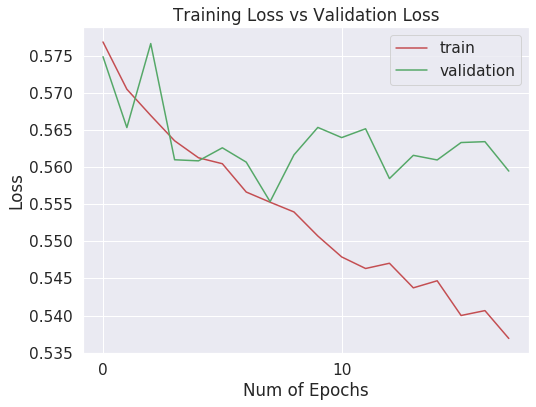

[[3245 1794]
 [1198 3763]]


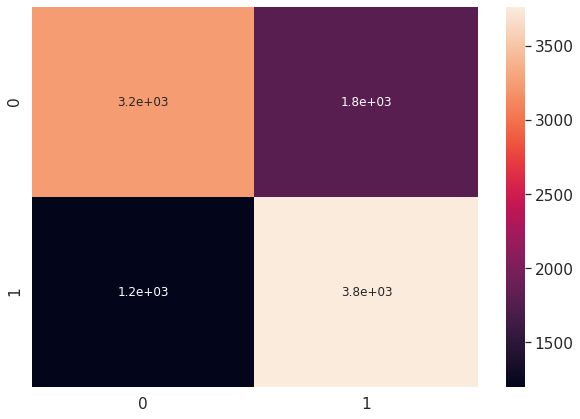

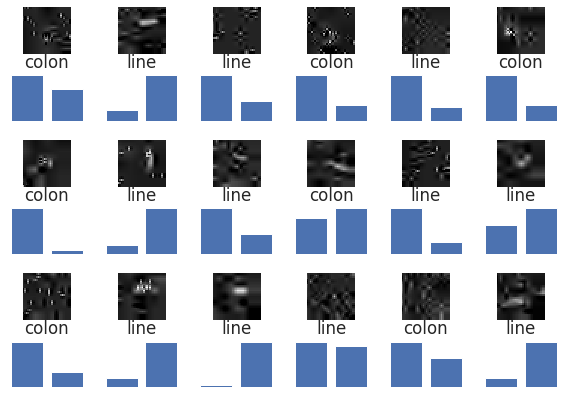

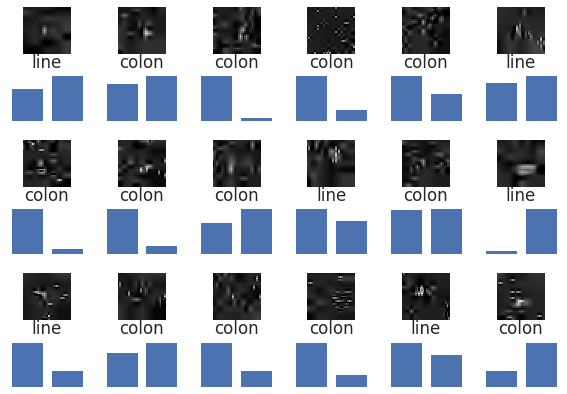

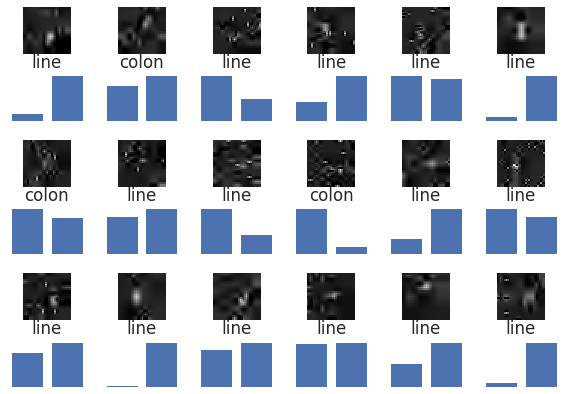

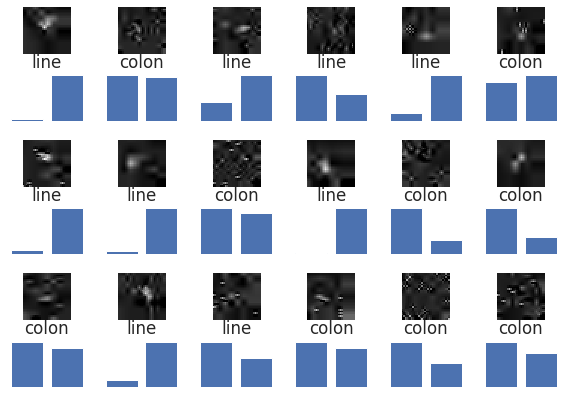

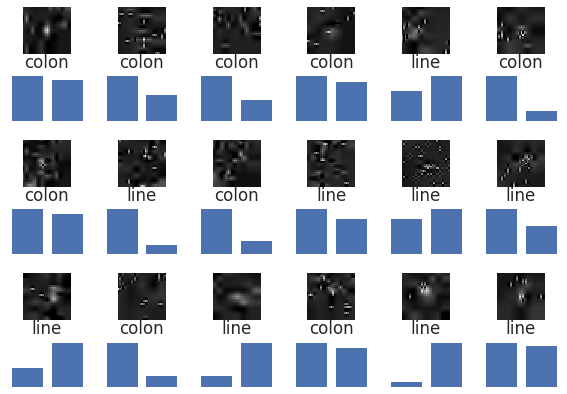

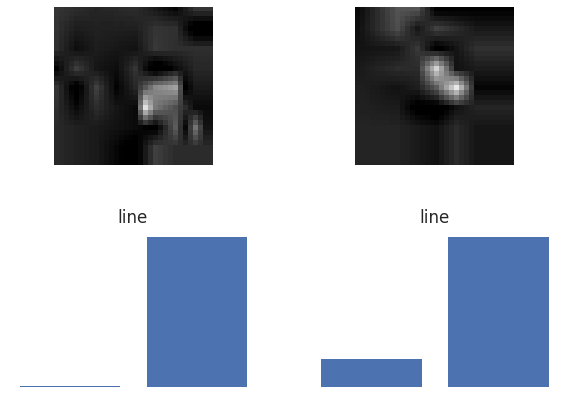

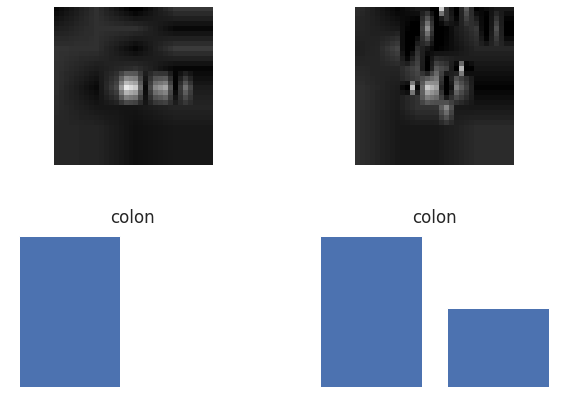

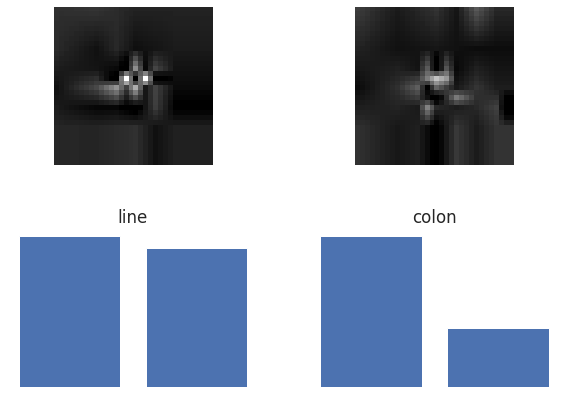

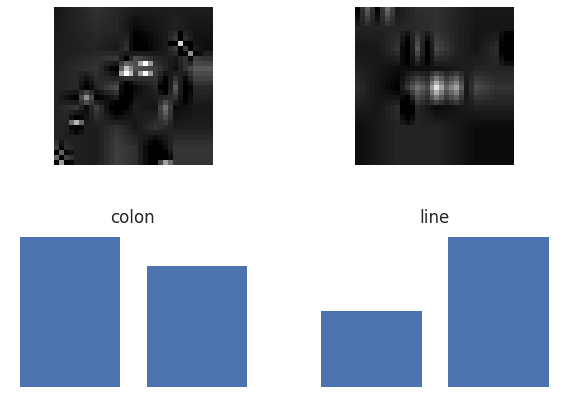

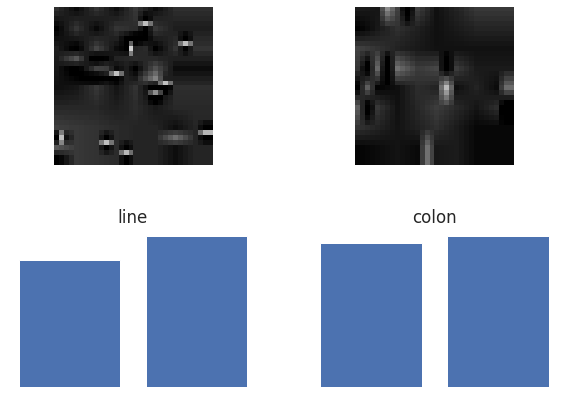

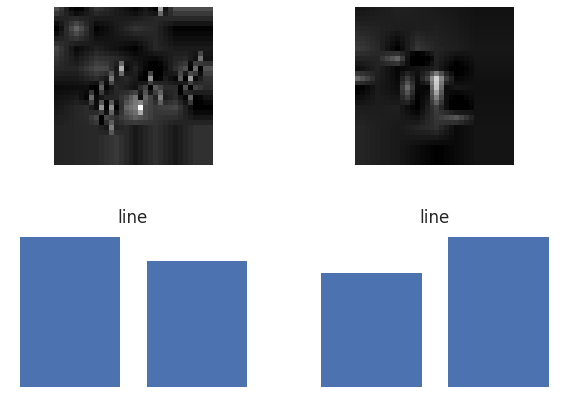

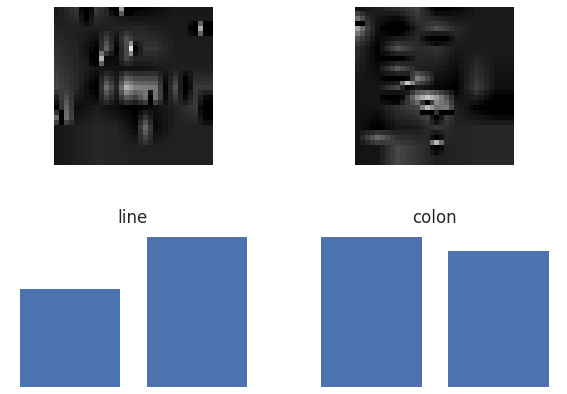

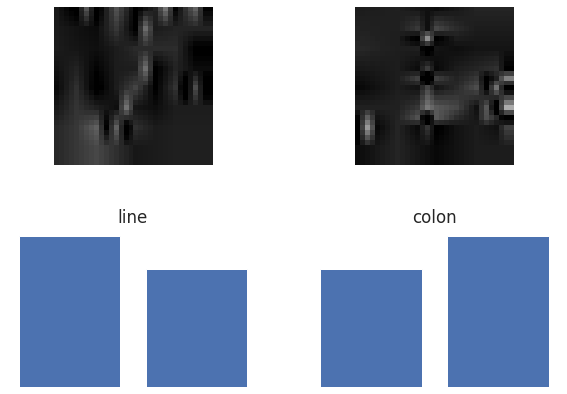

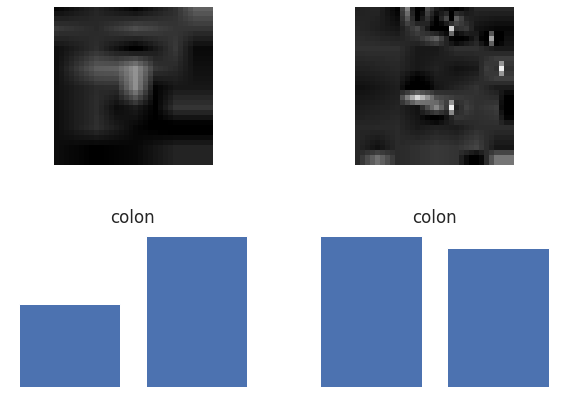

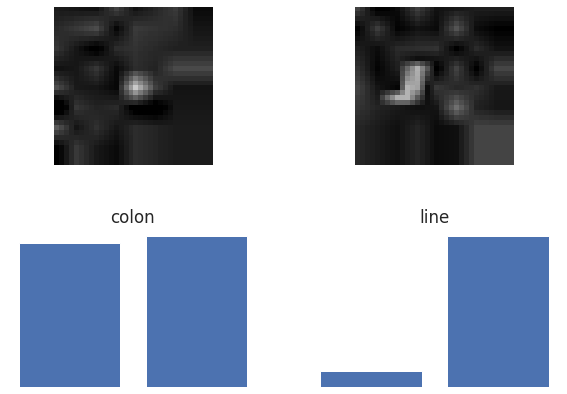

 
 
Extrapolation factor =  1.0
JPEG compression =  [100]
 
 


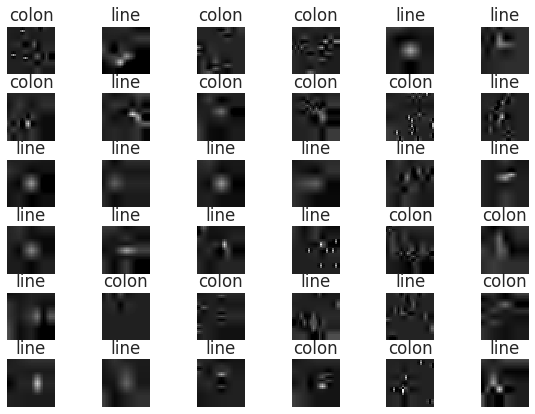

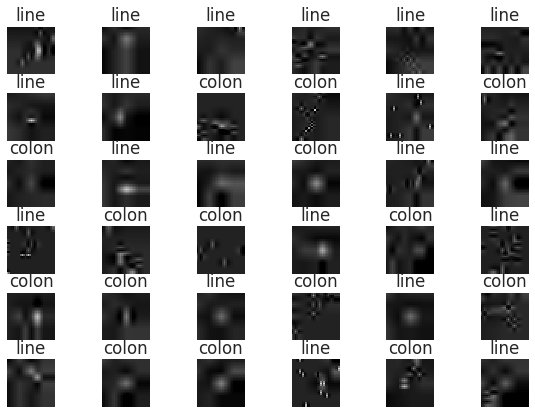

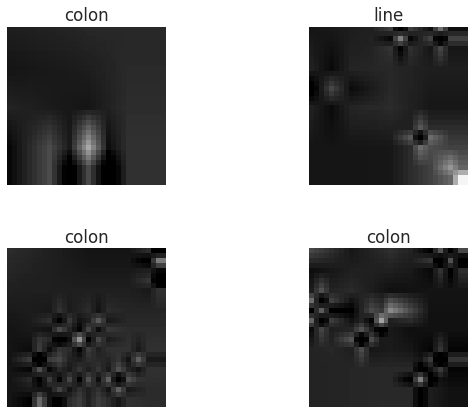

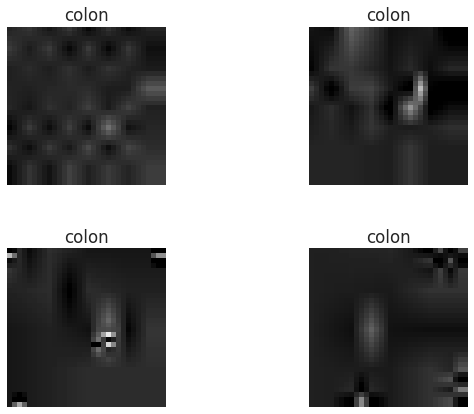

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 12s 195us/step - loss: 0.6227 - categorical_accuracy: 0.6447 - val_loss: 0.6156 - val_categorical_accuracy: 0.6467

Epoch 00001: val_categorical_accuracy improved from -inf to 0.64670, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 169us/step - loss: 0.6196 - categorical_accuracy: 0.6478 - val_loss: 0.6134 - val_categorical_accuracy: 0.6490

Epoch 00002: val_categorical_accuracy improved from 0.64670 to 0.64900, saving model to best_model.h5
Epoch 3/256
60000/60000 [==============================] - 10s 167us/step - loss: 0.6185 - categorical_accuracy: 0.6481 - val_loss: 0.6155 - val_categorical_accuracy: 0.6484

Epoch 00003: val_categorical_accuracy did not improve from 0.64900
Epoch 4/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6173 - categorical_accuracy: 0.6477 - val_loss: 0

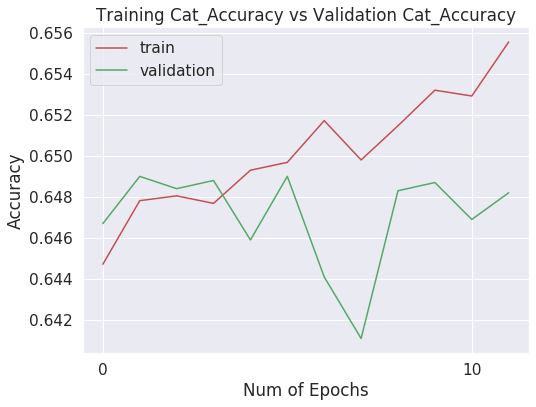

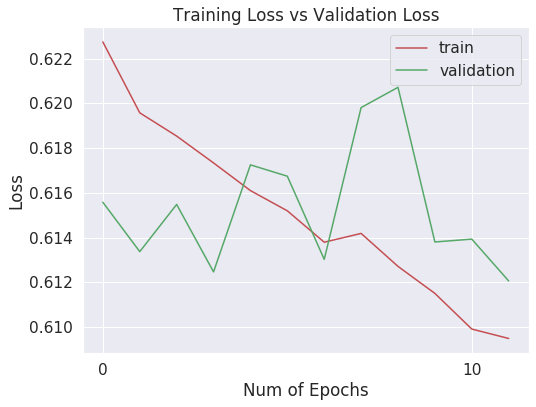

[[3662 1290]
 [2174 2874]]


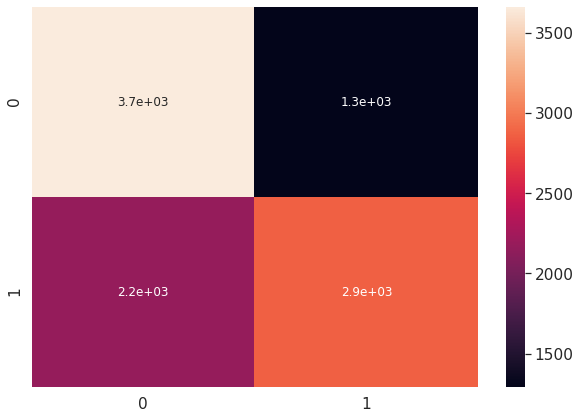

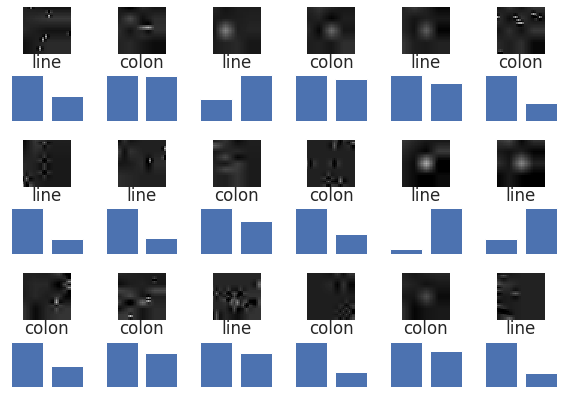

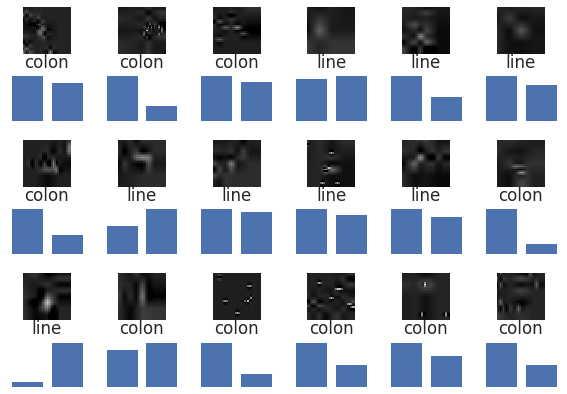

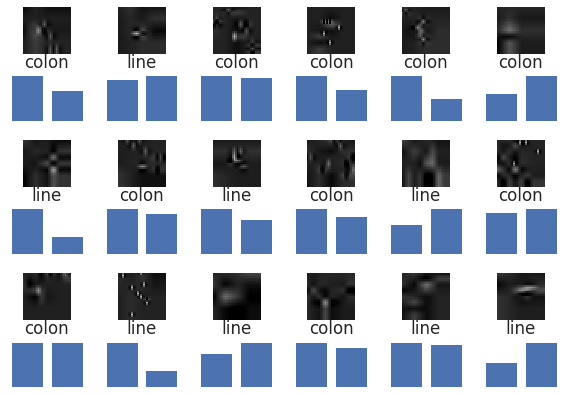

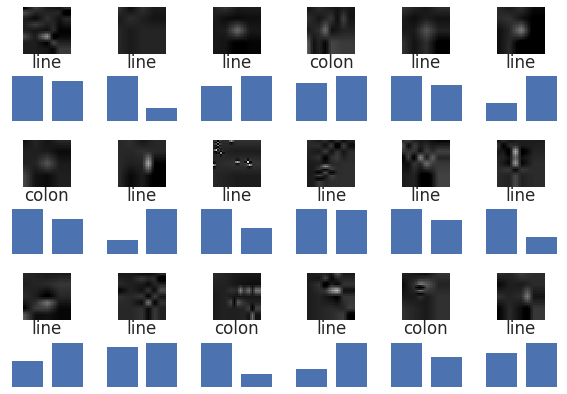

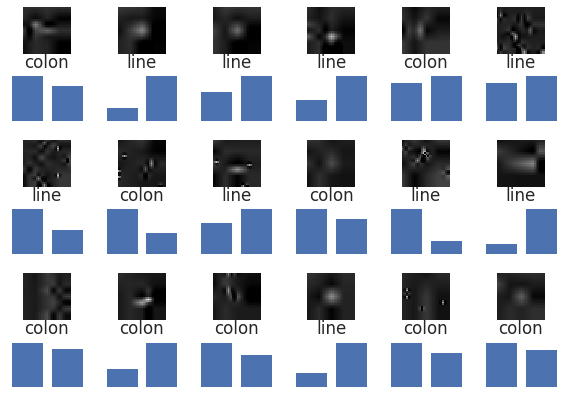

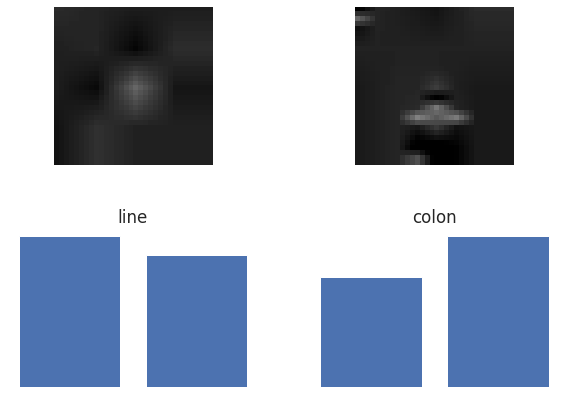

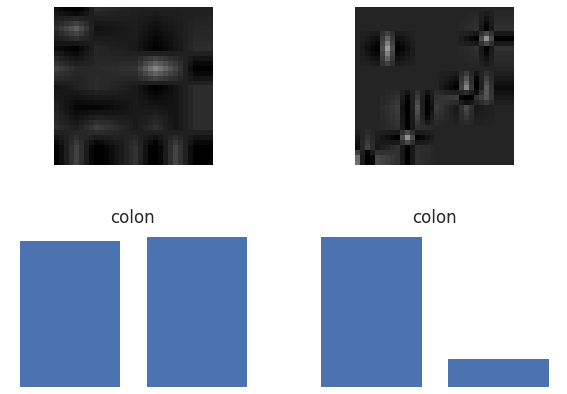

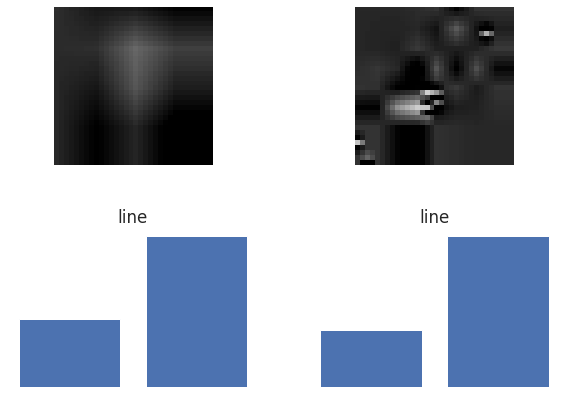

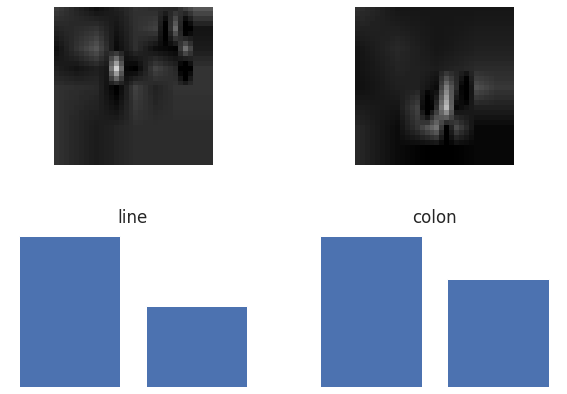

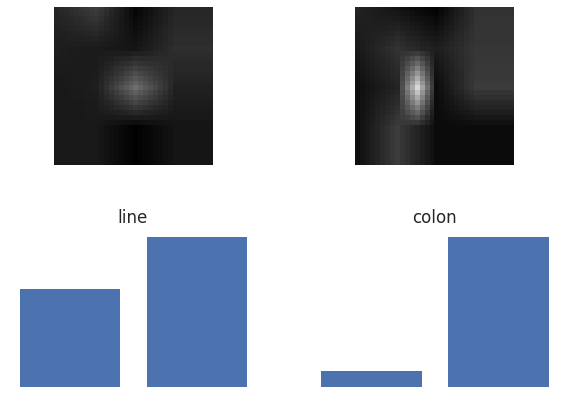

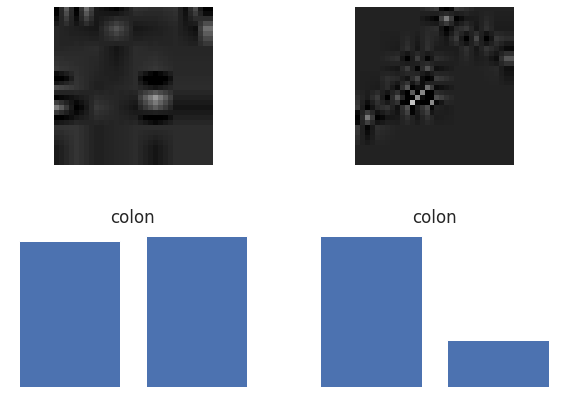

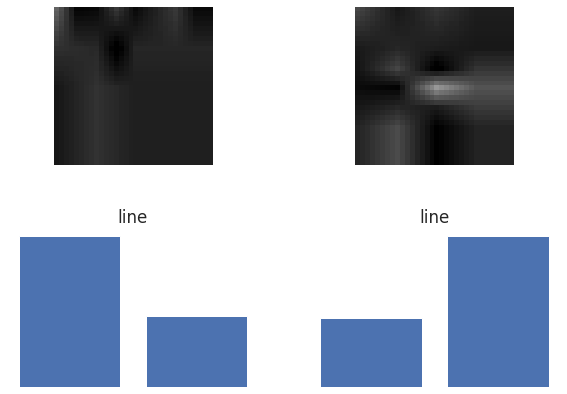

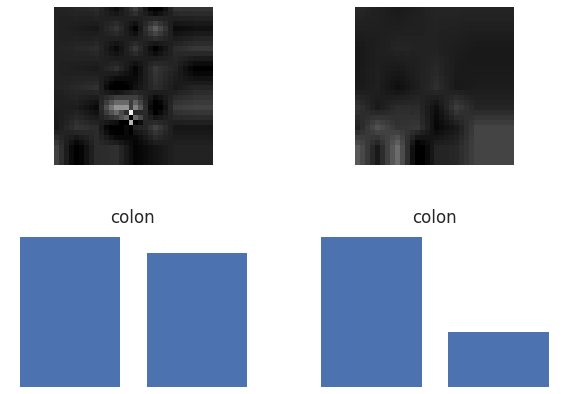

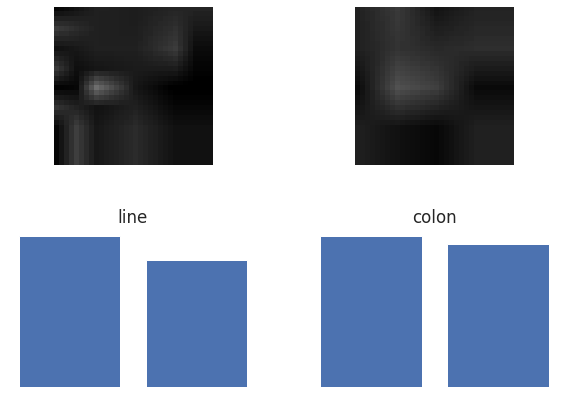

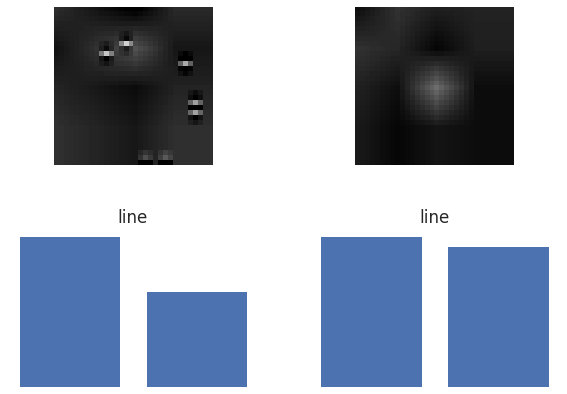

 
 
Extrapolation factor =  1.0
JPEG compression =  [50]
 
 


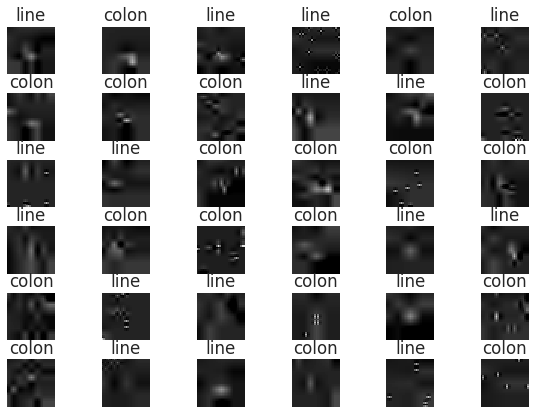

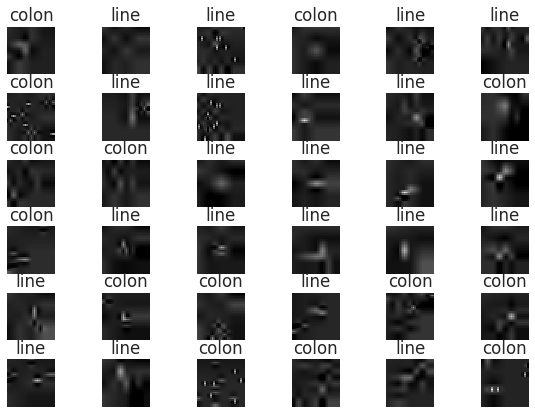

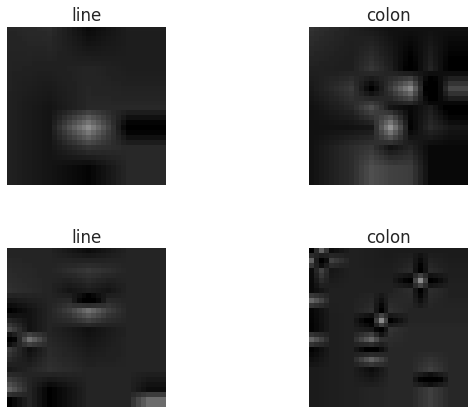

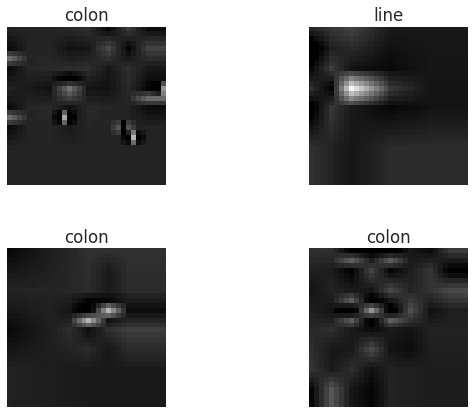

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 12s 197us/step - loss: 0.6165 - categorical_accuracy: 0.6506 - val_loss: 0.6139 - val_categorical_accuracy: 0.6573

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65730, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6154 - categorical_accuracy: 0.6510 - val_loss: 0.6166 - val_categorical_accuracy: 0.6453

Epoch 00002: val_categorical_accuracy did not improve from 0.65730
Epoch 3/256
60000/60000 [==============================] - 10s 166us/step - loss: 0.6141 - categorical_accuracy: 0.6529 - val_loss: 0.6156 - val_categorical_accuracy: 0.6533

Epoch 00003: val_categorical_accuracy did not improve from 0.65730
Epoch 4/256
60000/60000 [==============================] - 10s 167us/step - loss: 0.6136 - categorical_accuracy: 0.6531 - val_loss: 0.6168 - val_categorical_accuracy: 0

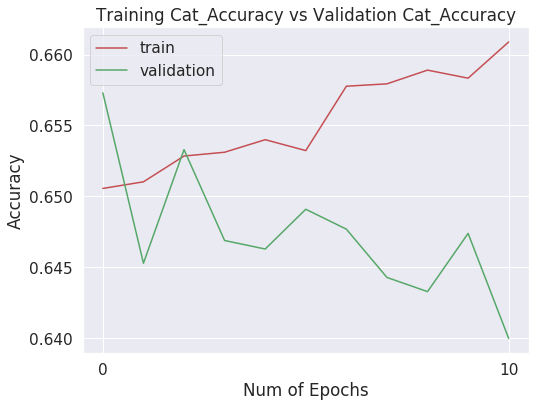

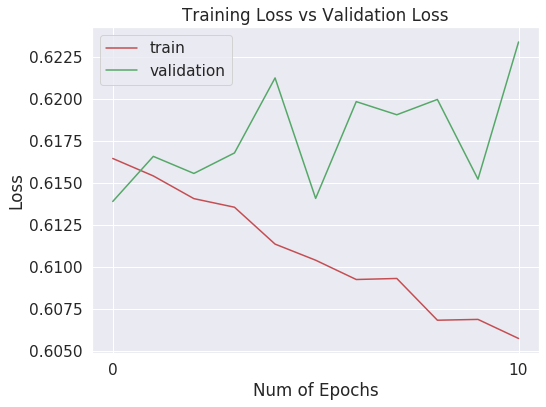

[[3418 1541]
 [1917 3124]]


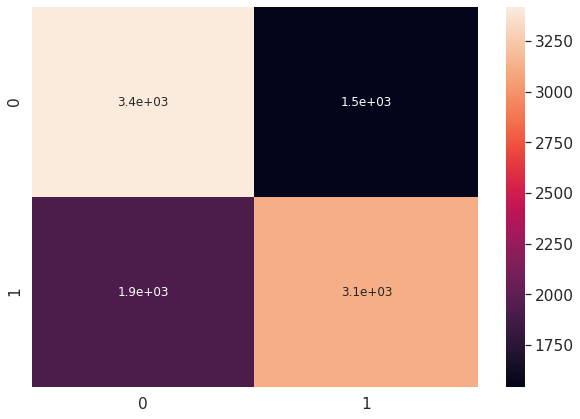

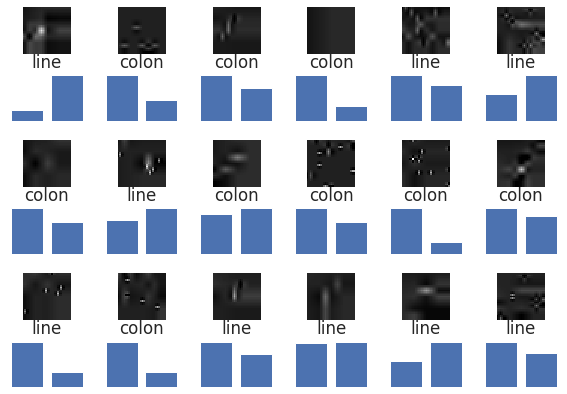

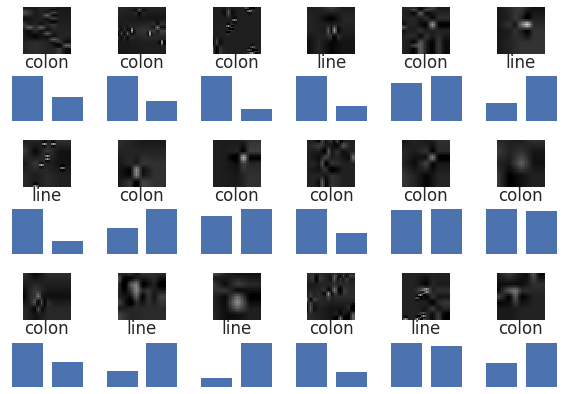

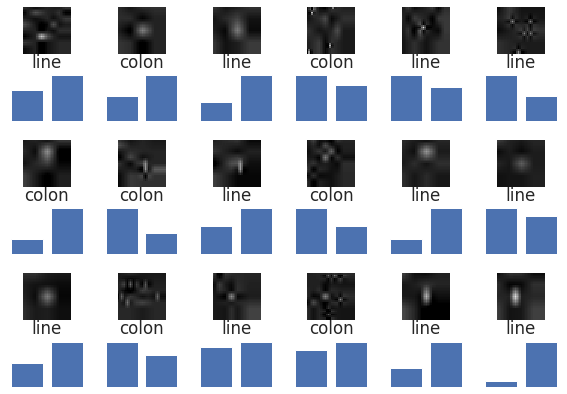

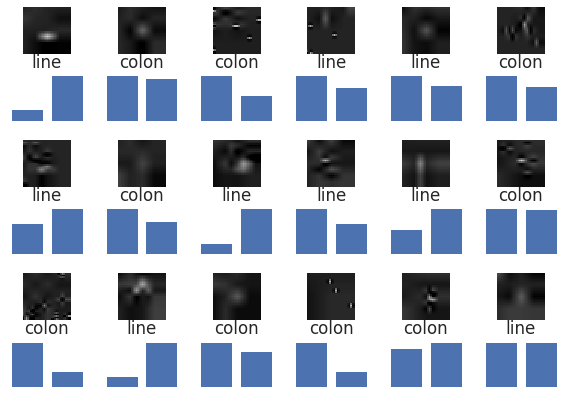

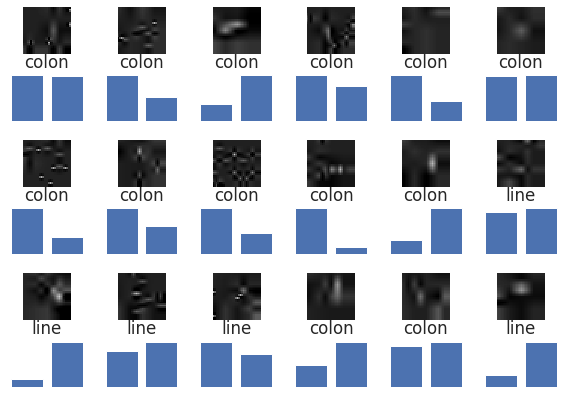

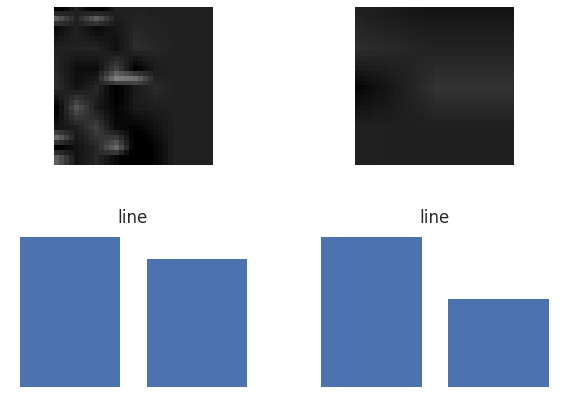

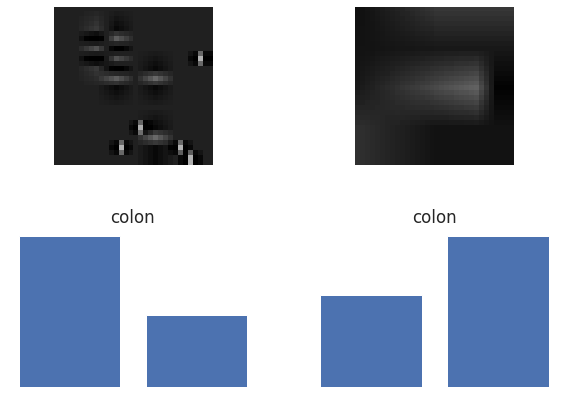

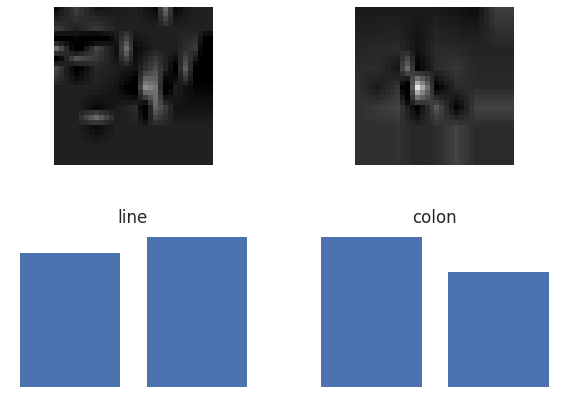

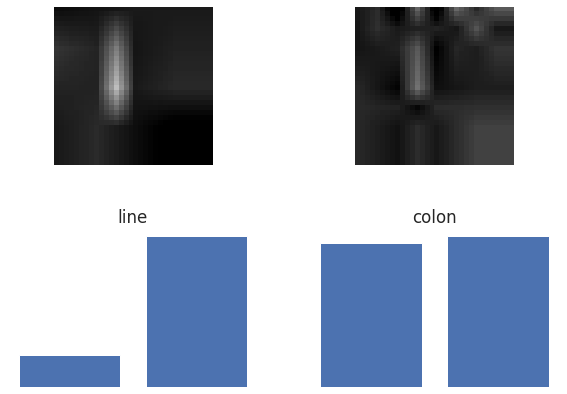

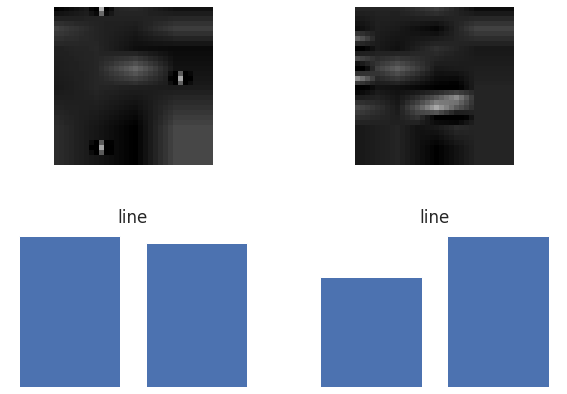

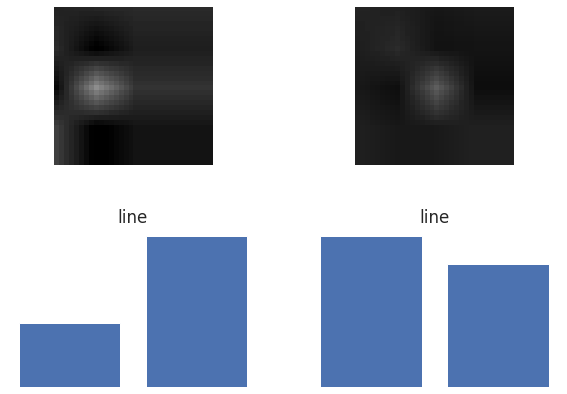

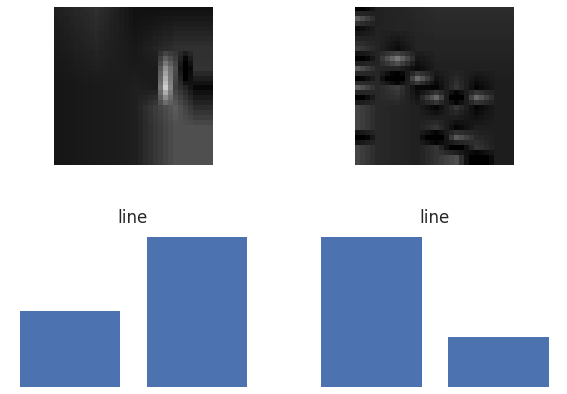

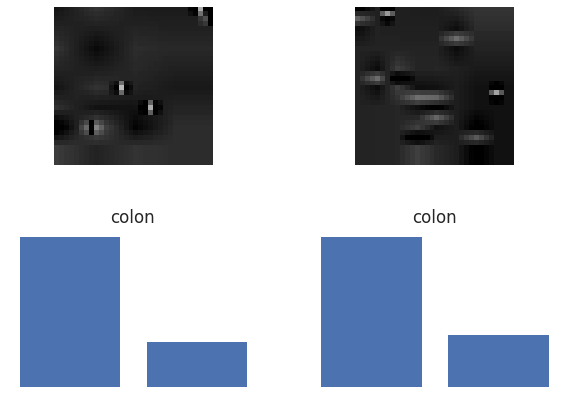

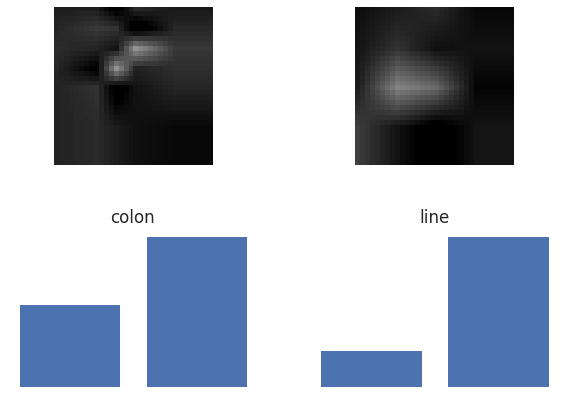

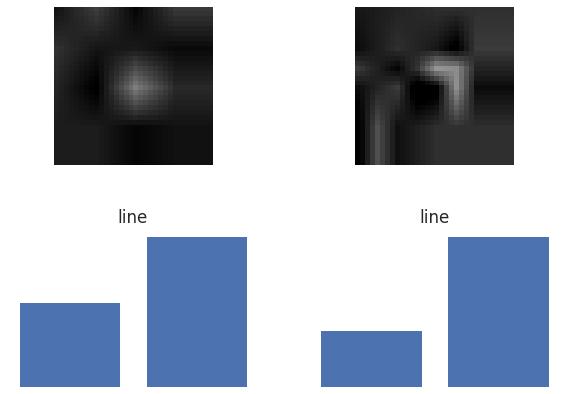

 
 
Extrapolation factor =  1.0
JPEG compression =  [30]
 
 


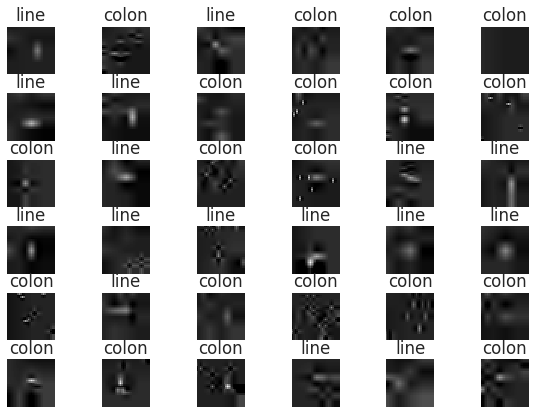

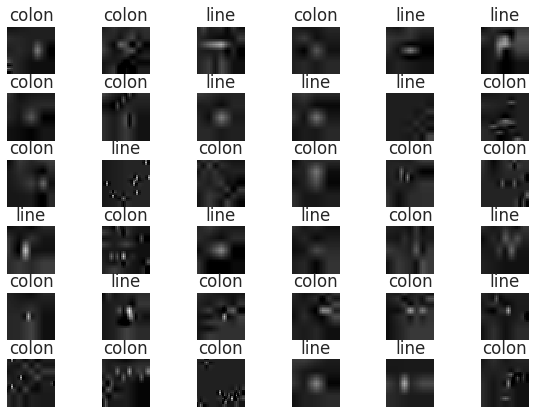

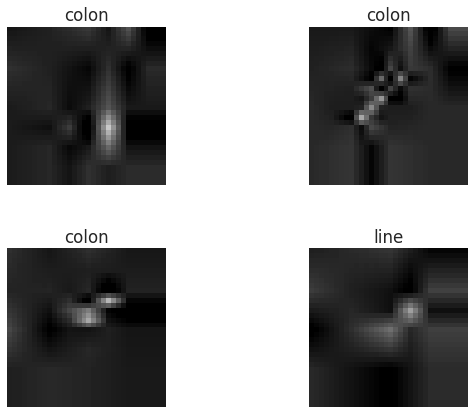

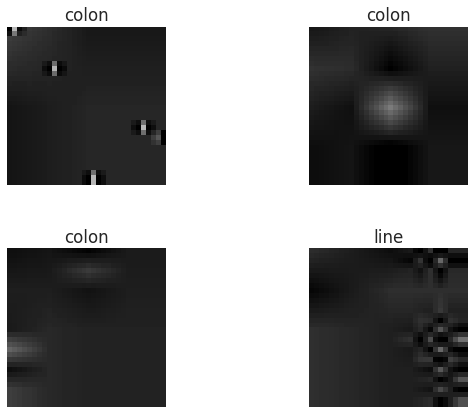

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 12s 204us/step - loss: 0.6185 - categorical_accuracy: 0.6481 - val_loss: 0.6169 - val_categorical_accuracy: 0.6512

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65120, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 169us/step - loss: 0.6170 - categorical_accuracy: 0.6476 - val_loss: 0.6213 - val_categorical_accuracy: 0.6437

Epoch 00002: val_categorical_accuracy did not improve from 0.65120
Epoch 3/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6155 - categorical_accuracy: 0.6525 - val_loss: 0.6277 - val_categorical_accuracy: 0.6411

Epoch 00003: val_categorical_accuracy did not improve from 0.65120
Epoch 4/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6141 - categorical_accuracy: 0.6527 - val_loss: 0.6202 - val_categorical_accuracy: 0

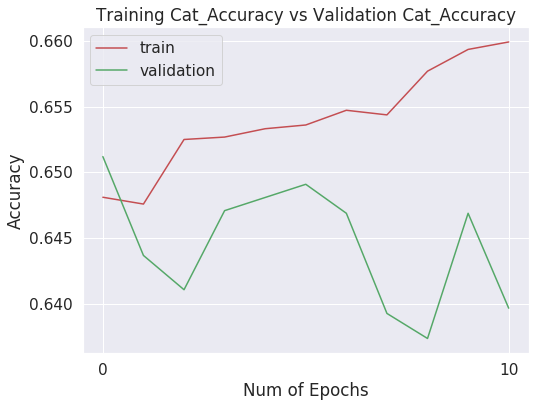

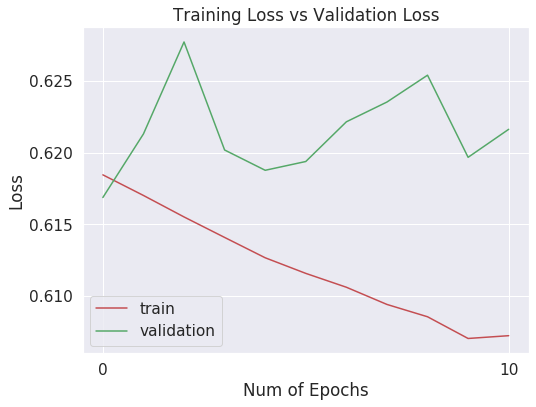

[[3493 1484]
 [1950 3073]]


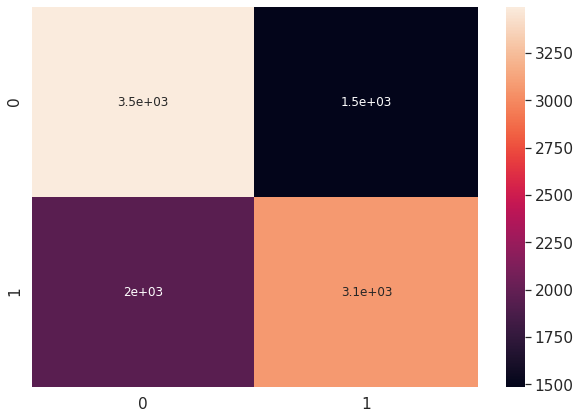

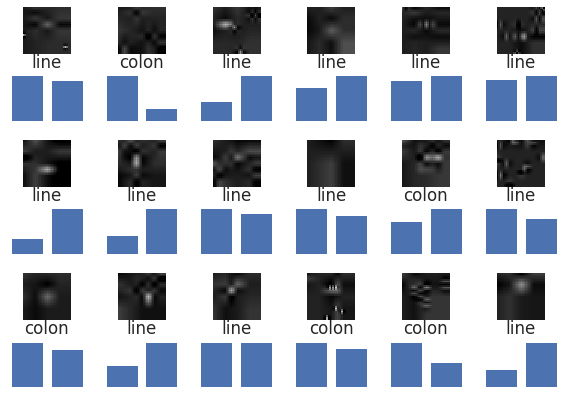

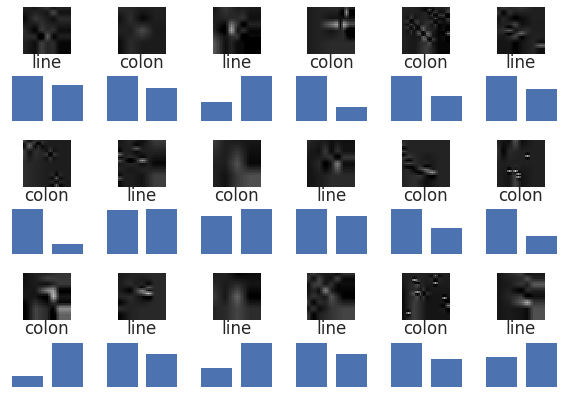

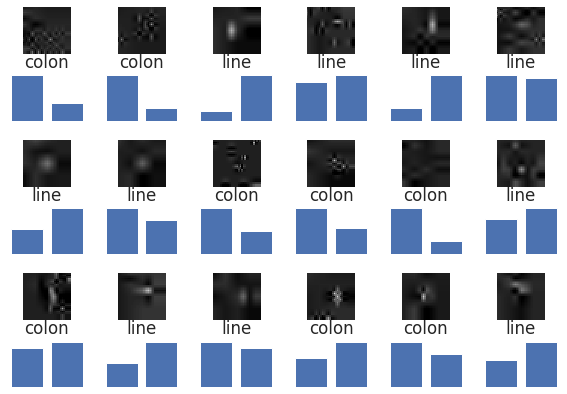

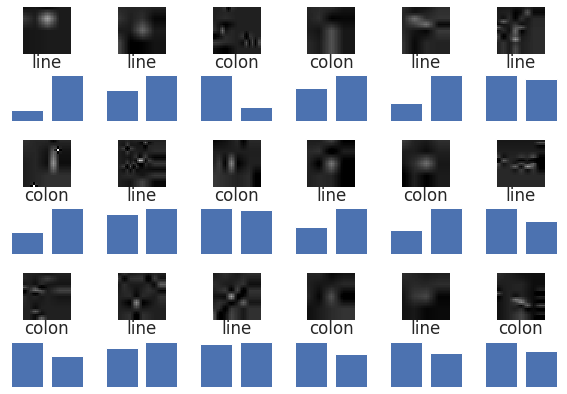

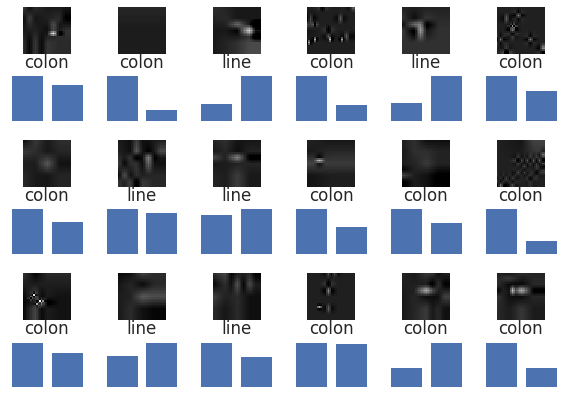

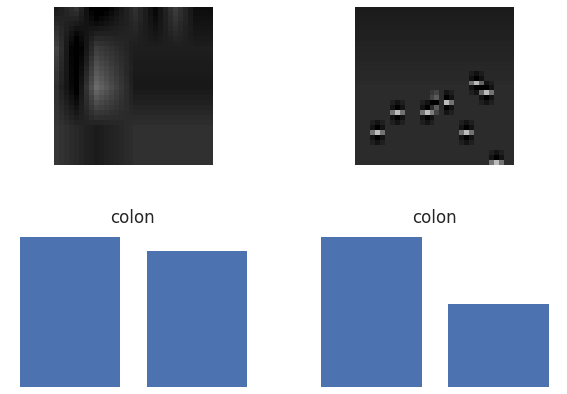

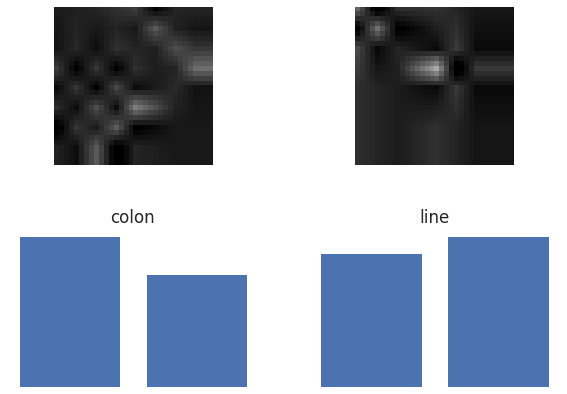

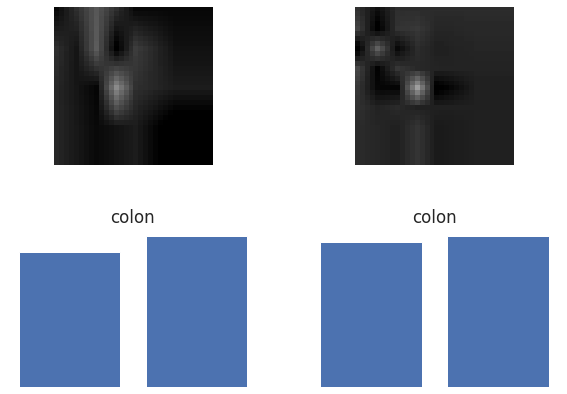

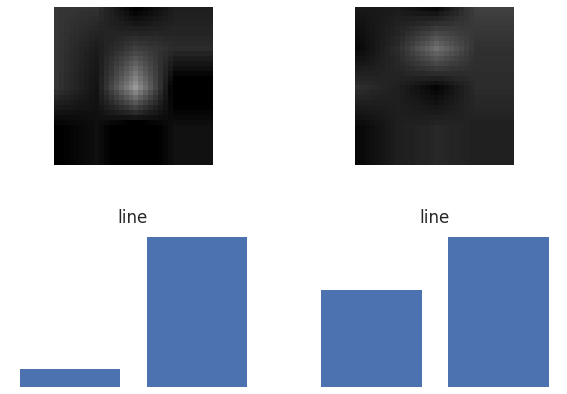

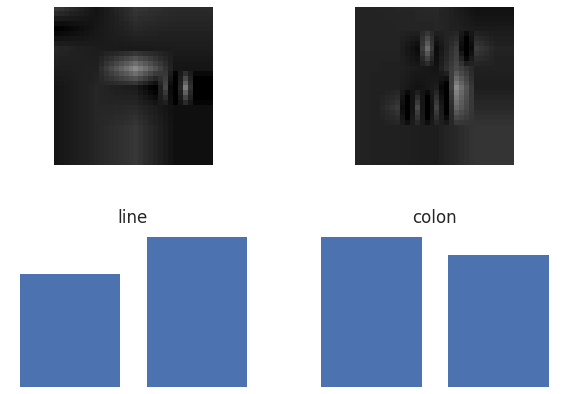

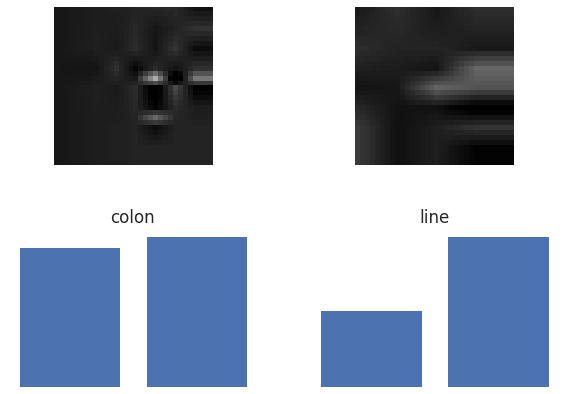

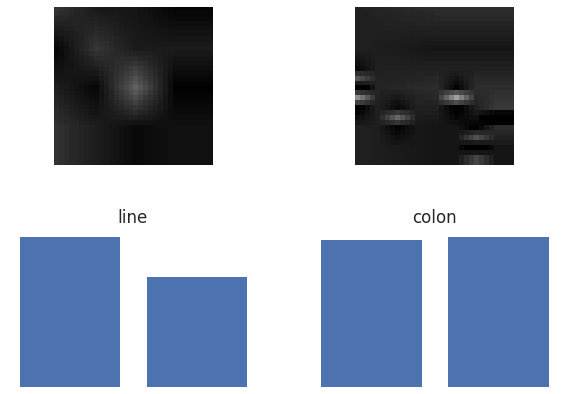

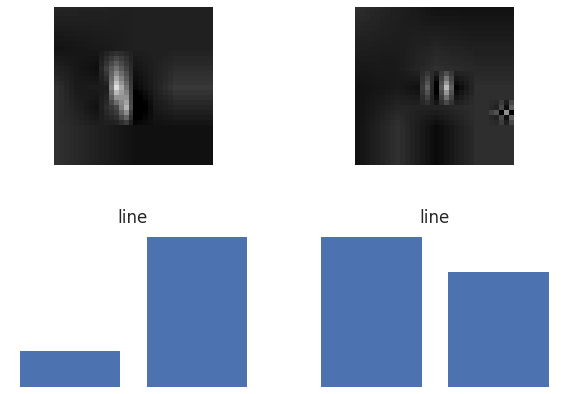

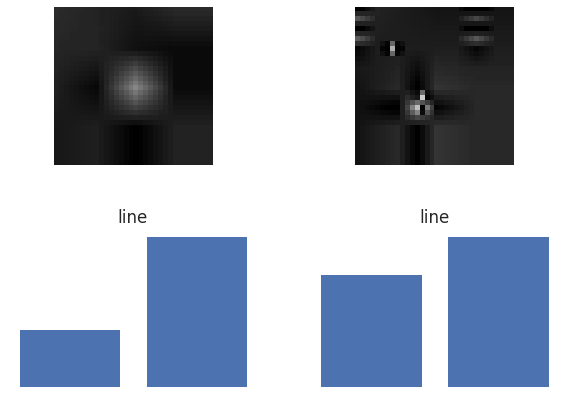

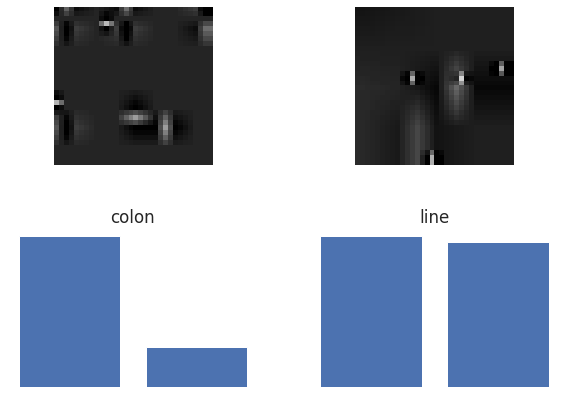

 
 
Extrapolation factor =  1.0
JPEG compression =  [10]
 
 


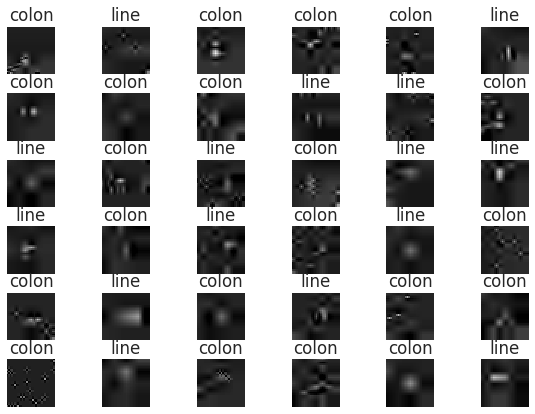

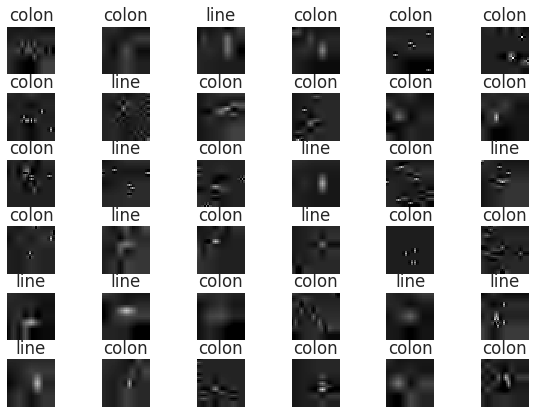

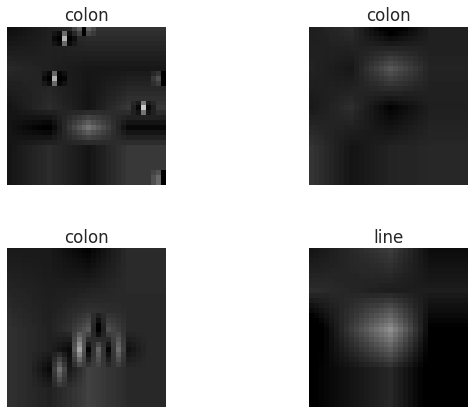

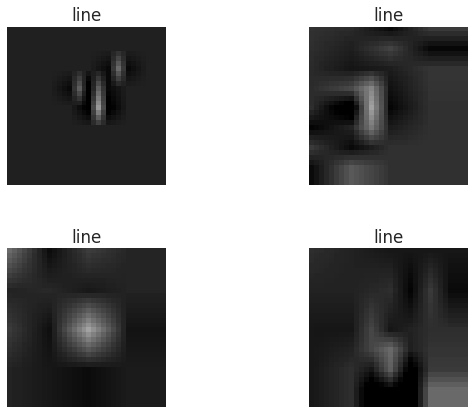

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 12s 206us/step - loss: 0.6182 - categorical_accuracy: 0.6504 - val_loss: 0.6162 - val_categorical_accuracy: 0.6616

Epoch 00001: val_categorical_accuracy improved from -inf to 0.66160, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6162 - categorical_accuracy: 0.6519 - val_loss: 0.6113 - val_categorical_accuracy: 0.6521

Epoch 00002: val_categorical_accuracy did not improve from 0.66160
Epoch 3/256
60000/60000 [==============================] - 10s 166us/step - loss: 0.6150 - categorical_accuracy: 0.6512 - val_loss: 0.6168 - val_categorical_accuracy: 0.6534

Epoch 00003: val_categorical_accuracy did not improve from 0.66160
Epoch 4/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6131 - categorical_accuracy: 0.6545 - val_loss: 0.6168 - val_categorical_accuracy: 0

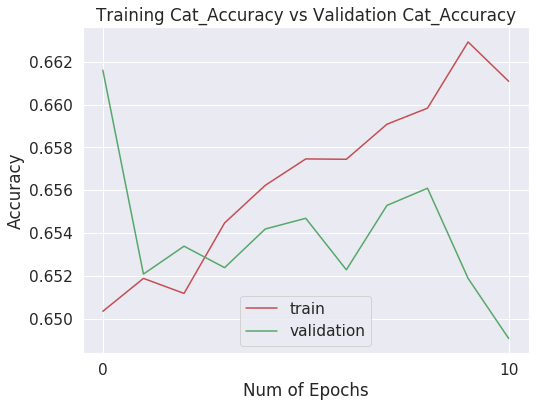

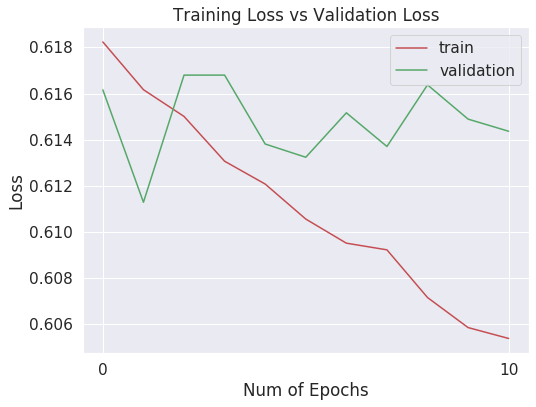

[[3600 1358]
 [2223 2819]]


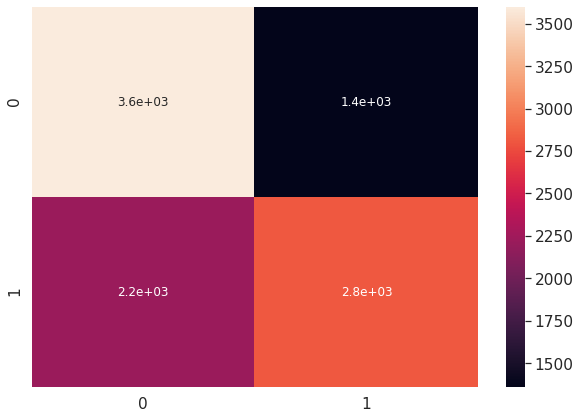

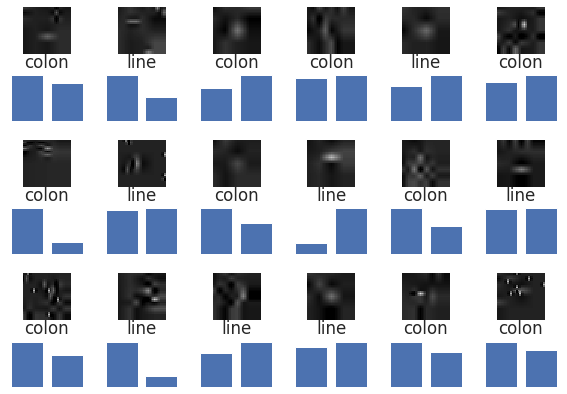

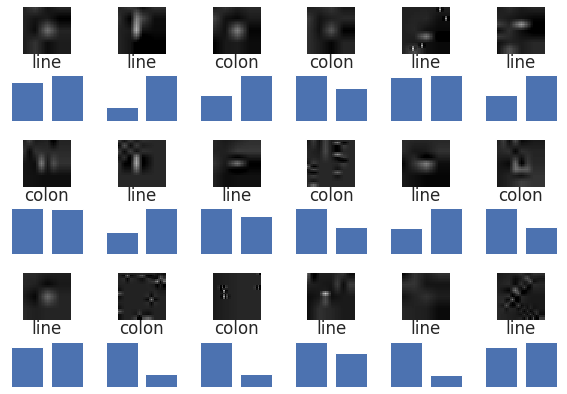

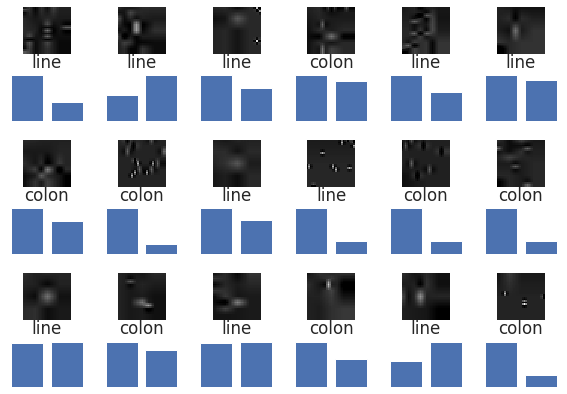

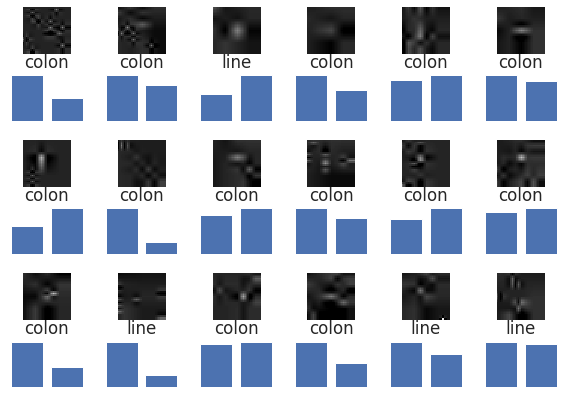

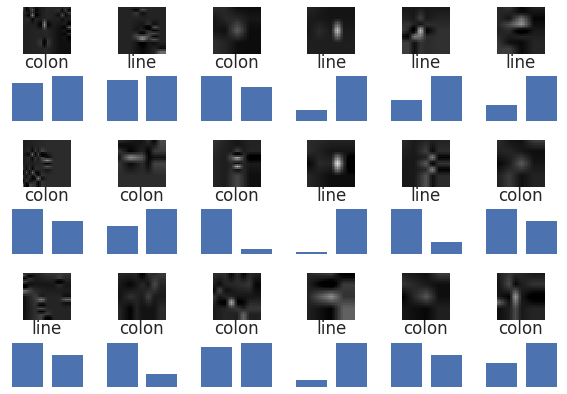

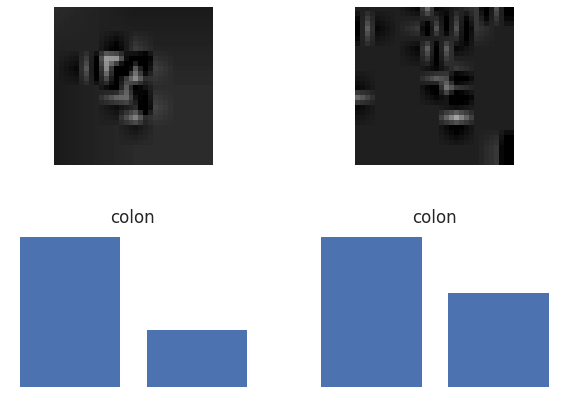

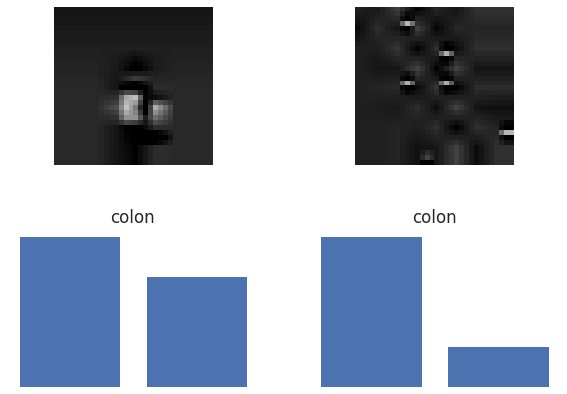

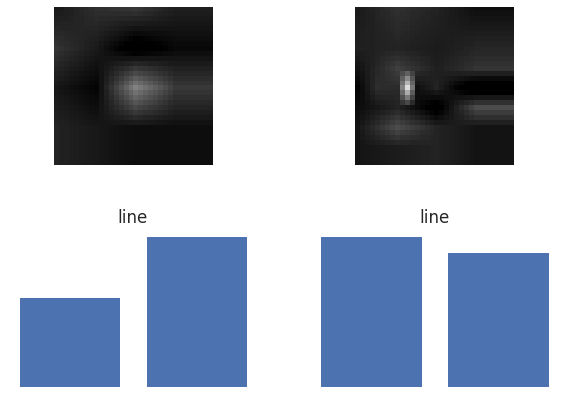

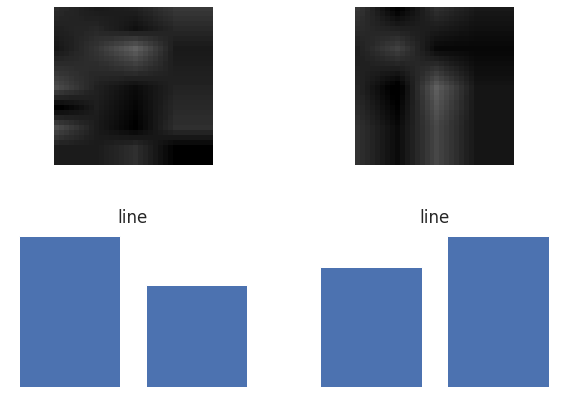

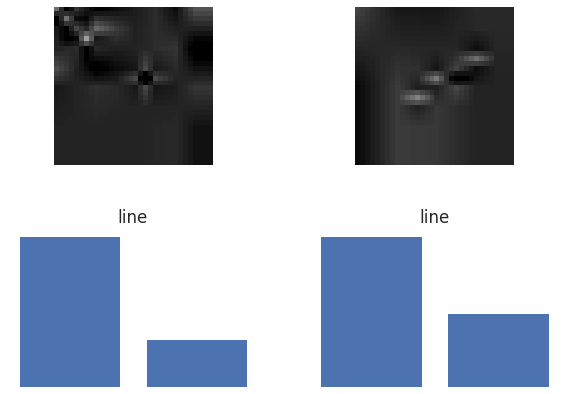

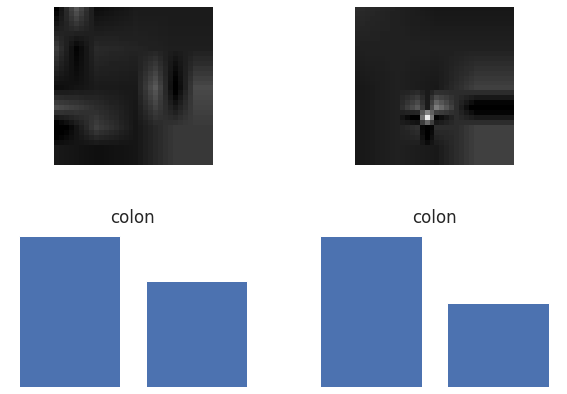

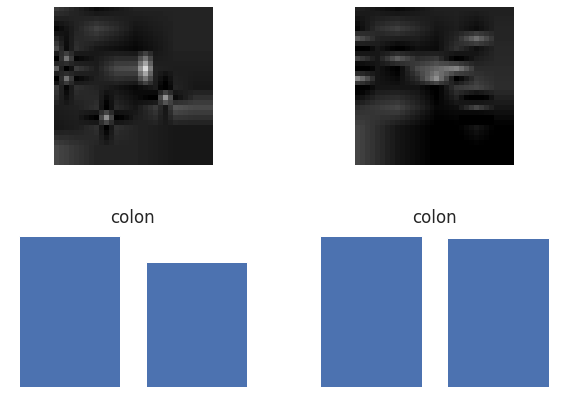

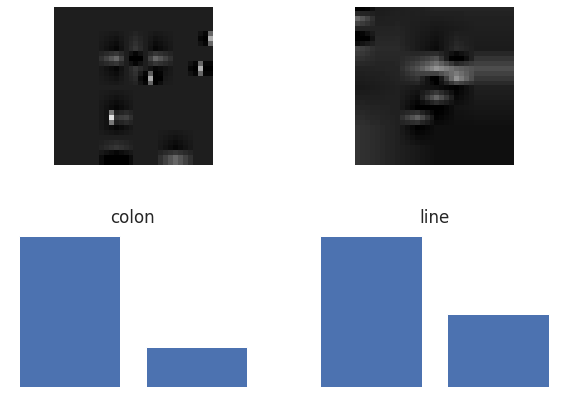

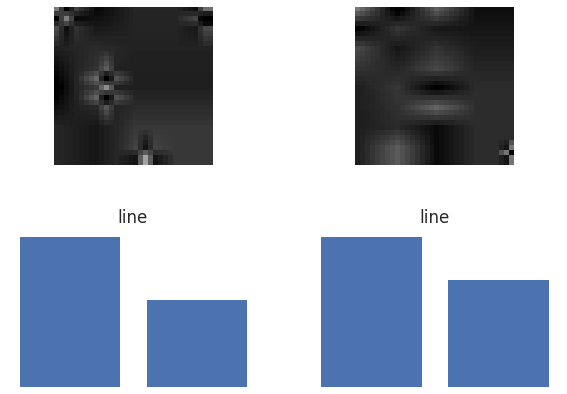

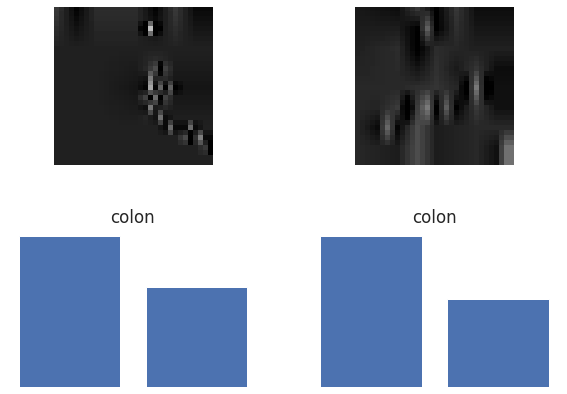

 
 
Extrapolation factor =  1.0
JPEG compression =  [4]
 
 


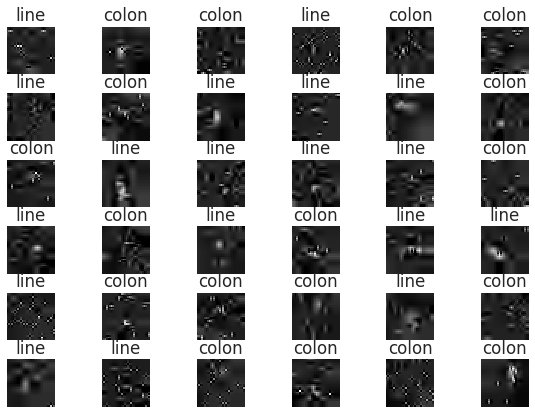

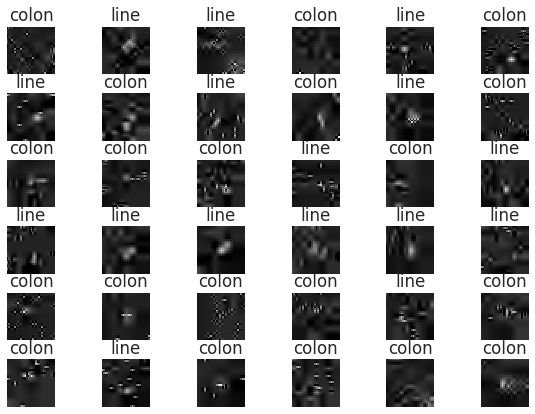

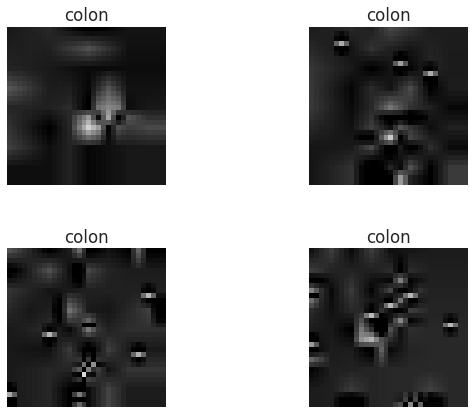

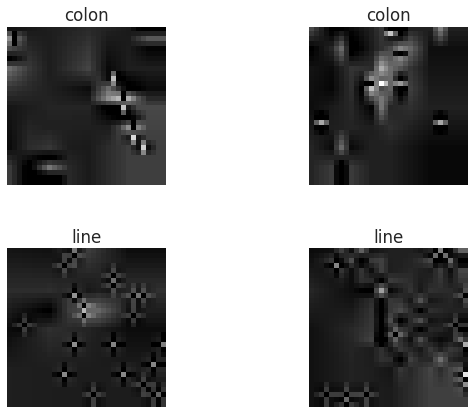

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 13s 210us/step - loss: 0.5732 - categorical_accuracy: 0.6880 - val_loss: 0.5662 - val_categorical_accuracy: 0.6898

Epoch 00001: val_categorical_accuracy improved from -inf to 0.68980, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 170us/step - loss: 0.5692 - categorical_accuracy: 0.6918 - val_loss: 0.5655 - val_categorical_accuracy: 0.6834

Epoch 00002: val_categorical_accuracy did not improve from 0.68980
Epoch 3/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.5652 - categorical_accuracy: 0.6931 - val_loss: 0.5647 - val_categorical_accuracy: 0.6891

Epoch 00003: val_categorical_accuracy did not improve from 0.68980
Epoch 4/256
60000/60000 [==============================] - 10s 169us/step - loss: 0.5623 - categorical_accuracy: 0.6956 - val_loss: 0.5645 - val_categorical_accuracy: 0

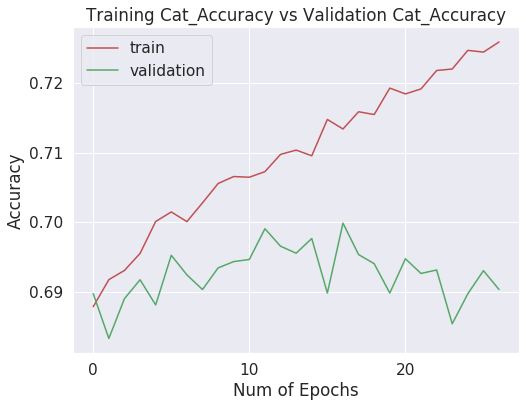

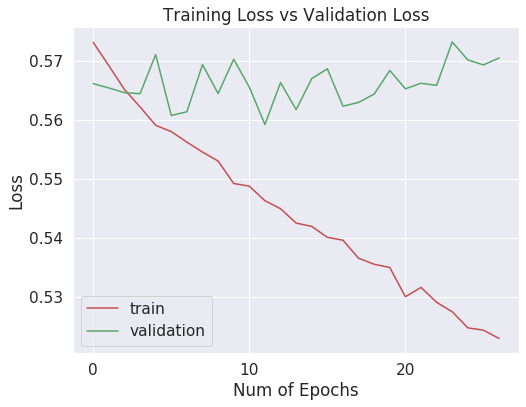

[[3417 1607]
 [1414 3562]]


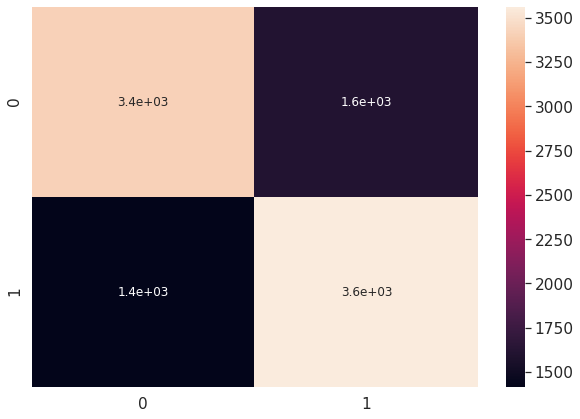

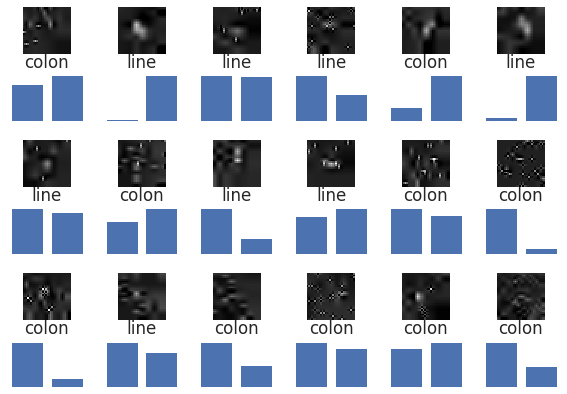

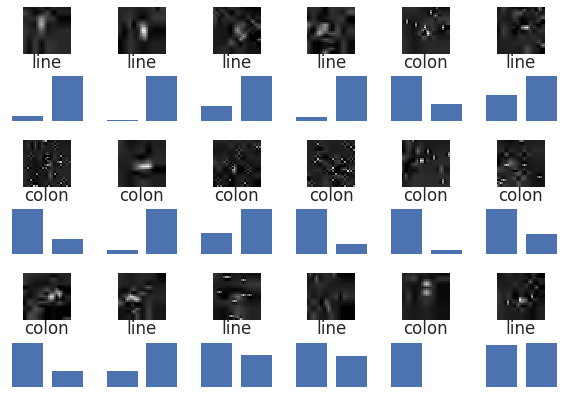

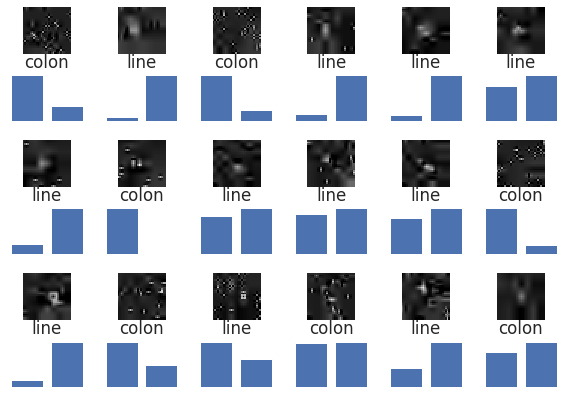

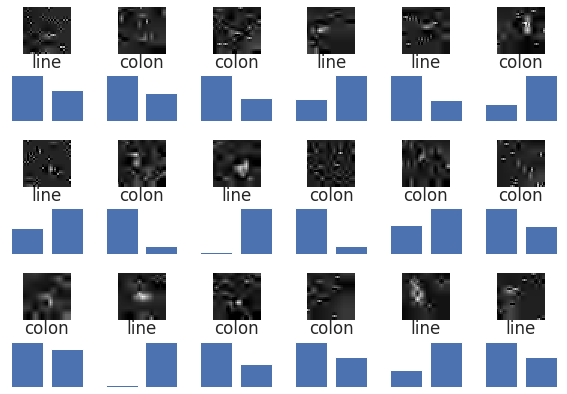

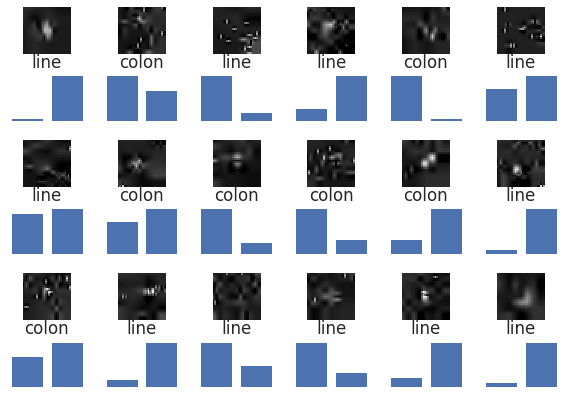

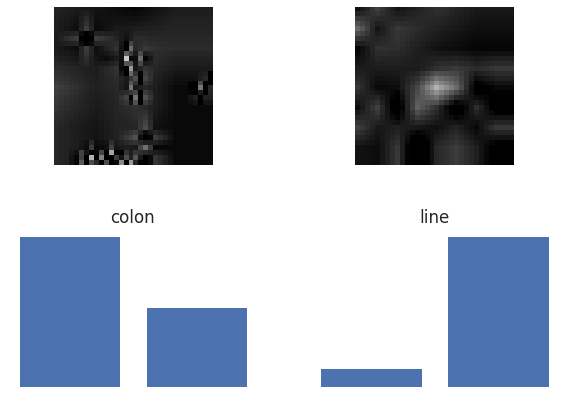

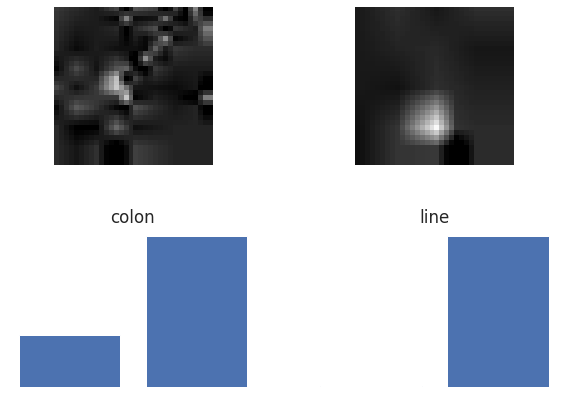

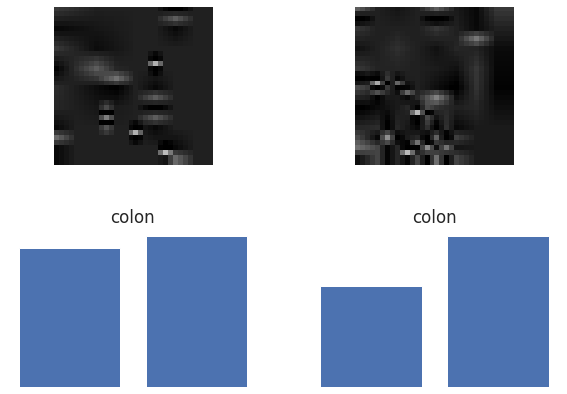

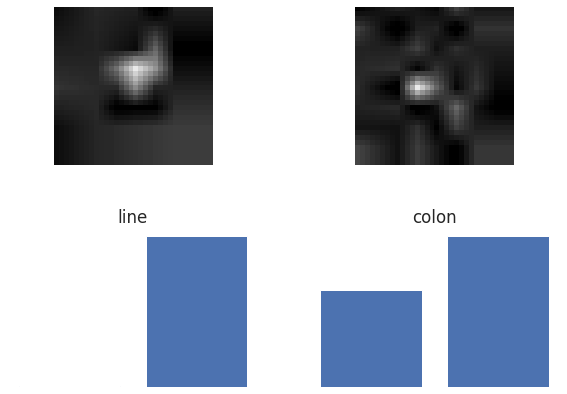

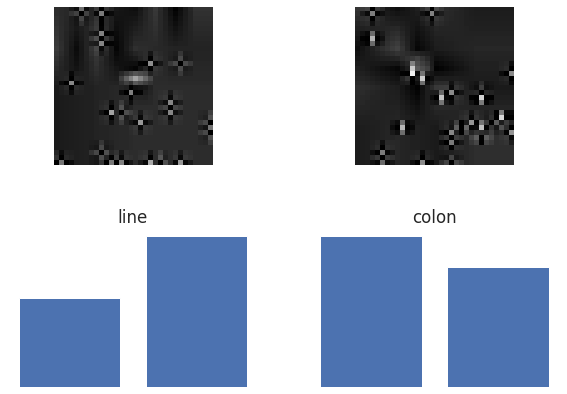

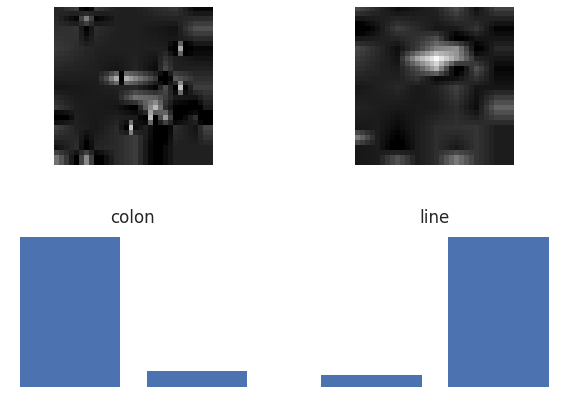

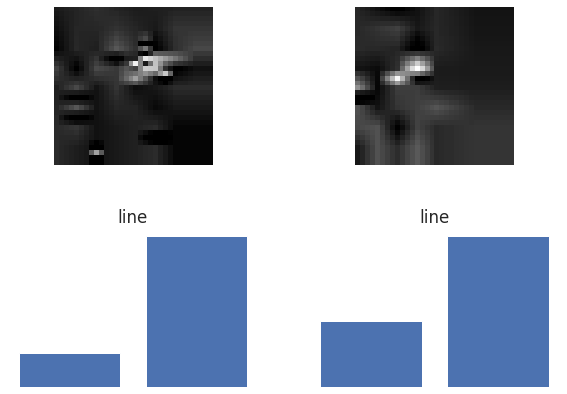

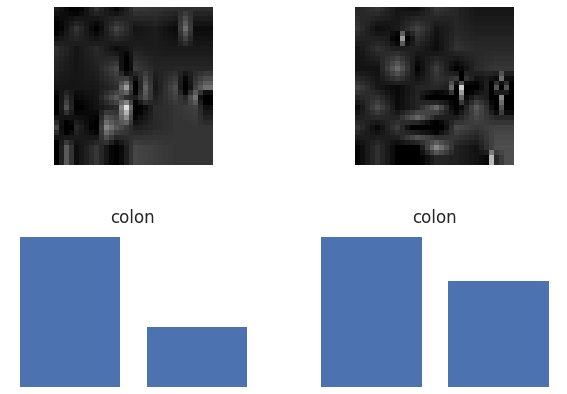

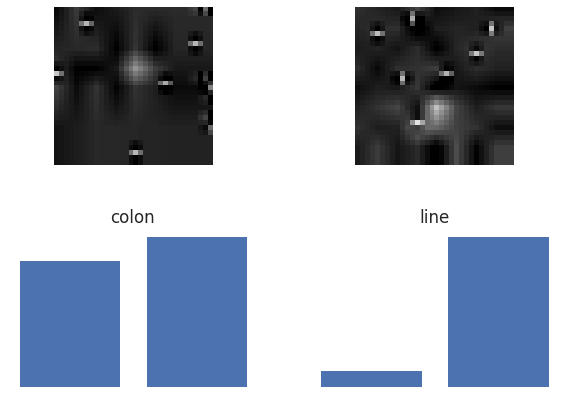

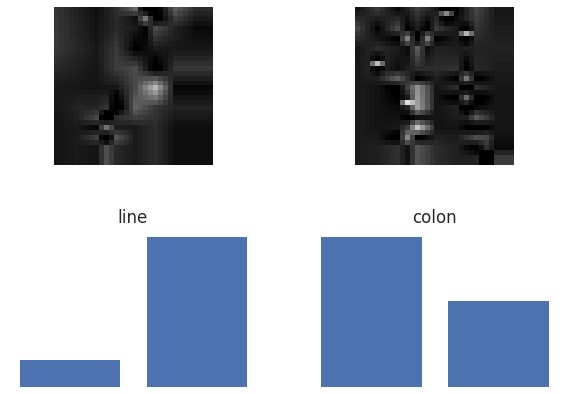

 
 
Extrapolation factor =  8.0
JPEG compression =  [100]
 
 


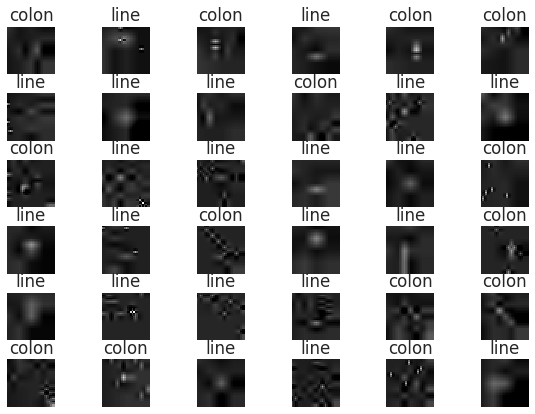

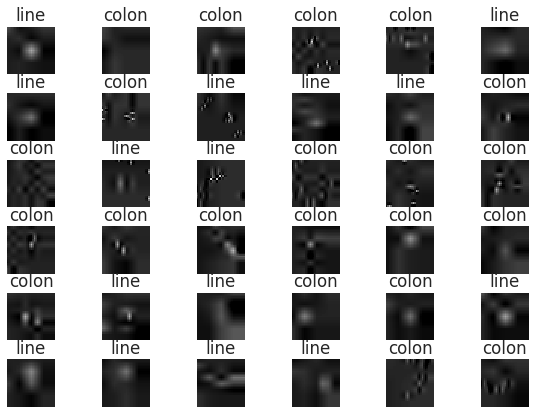

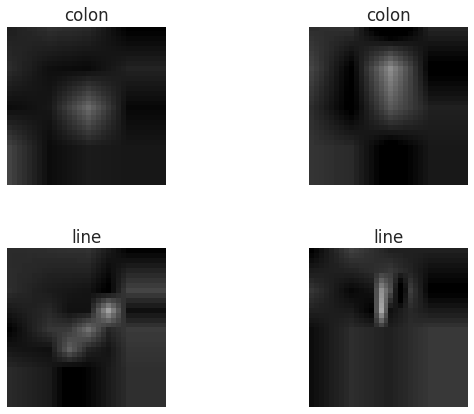

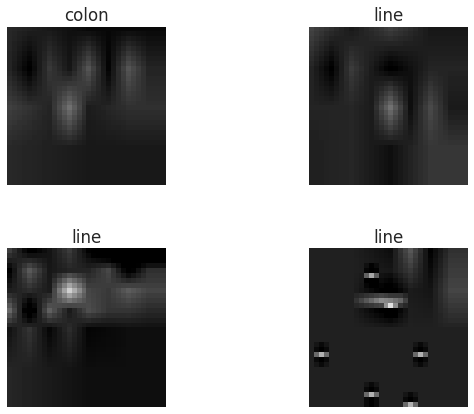

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 13s 215us/step - loss: 0.6202 - categorical_accuracy: 0.6491 - val_loss: 0.6158 - val_categorical_accuracy: 0.6506

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65060, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6158 - categorical_accuracy: 0.6521 - val_loss: 0.6236 - val_categorical_accuracy: 0.6407

Epoch 00002: val_categorical_accuracy did not improve from 0.65060
Epoch 3/256
60000/60000 [==============================] - 10s 169us/step - loss: 0.6138 - categorical_accuracy: 0.6535 - val_loss: 0.6146 - val_categorical_accuracy: 0.6490

Epoch 00003: val_categorical_accuracy did not improve from 0.65060
Epoch 4/256
60000/60000 [==============================] - 10s 170us/step - loss: 0.6124 - categorical_accuracy: 0.6550 - val_loss: 0.6156 - val_categorical_accuracy: 0

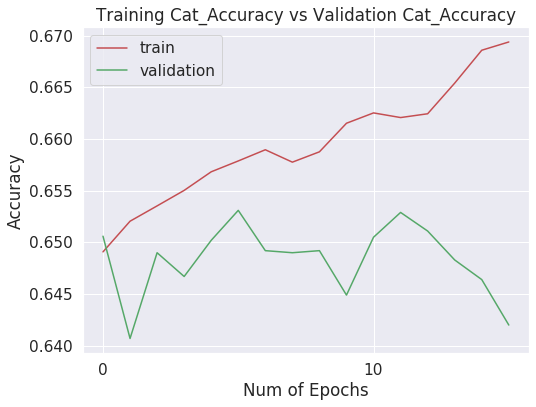

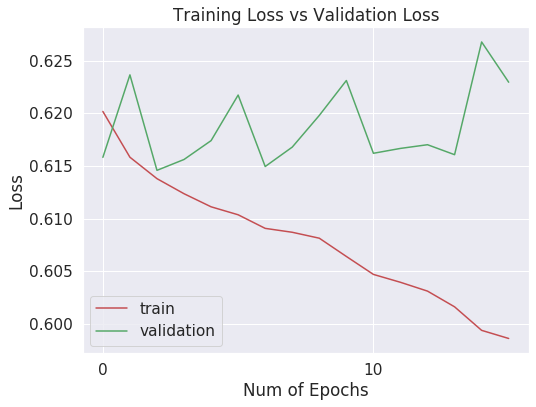

[[3474 1514]
 [1958 3054]]


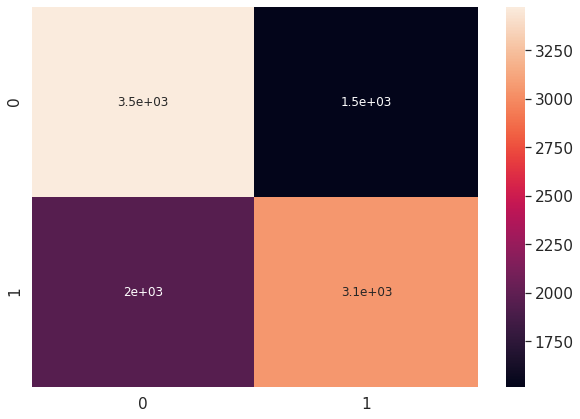

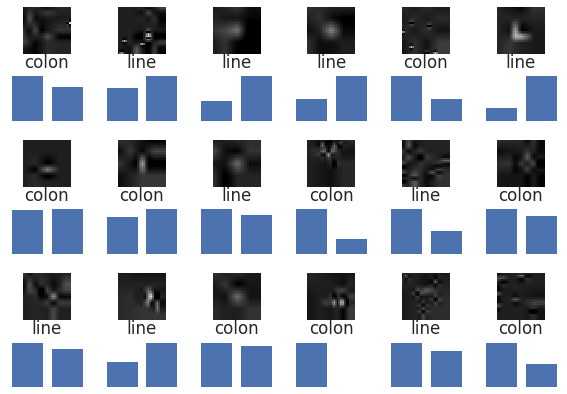

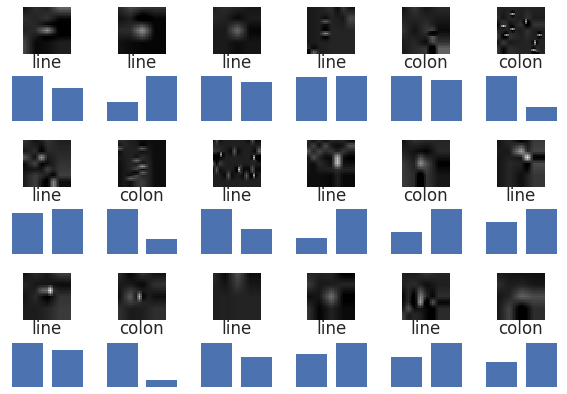

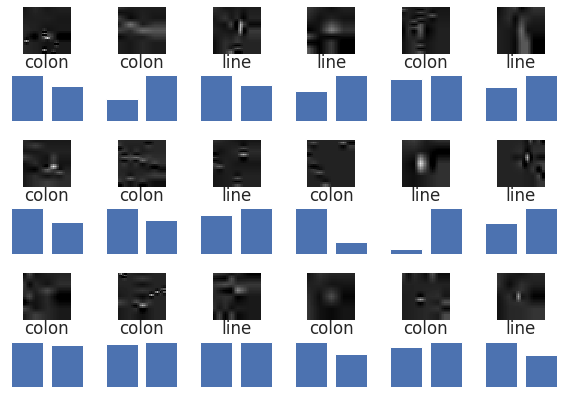

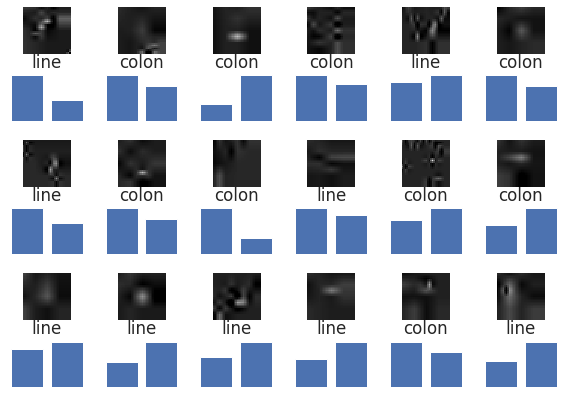

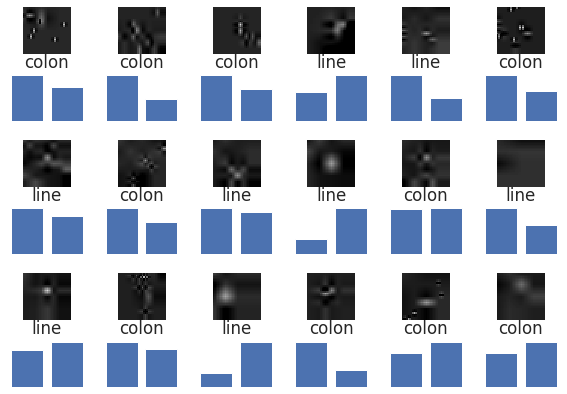

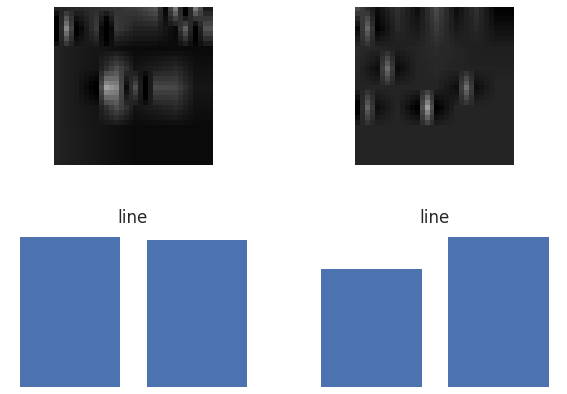

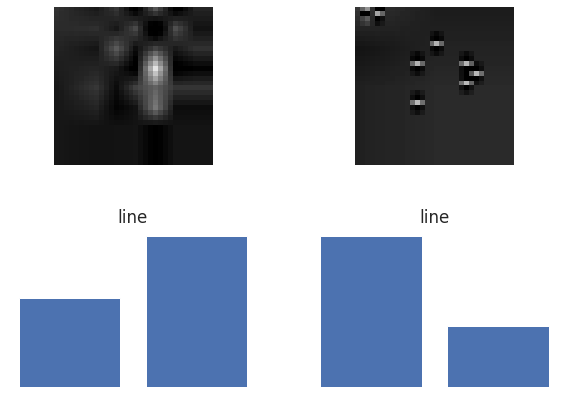

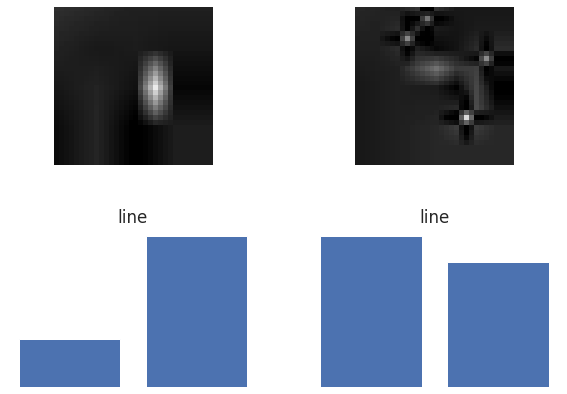

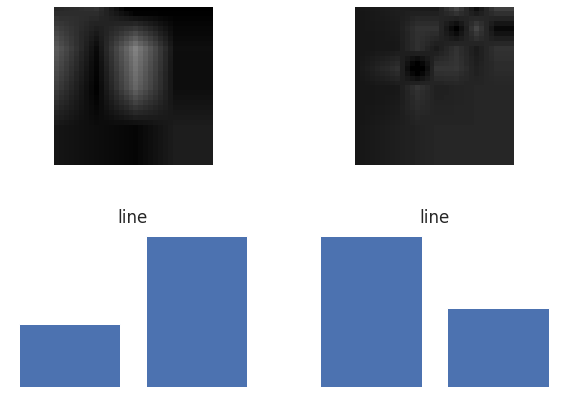

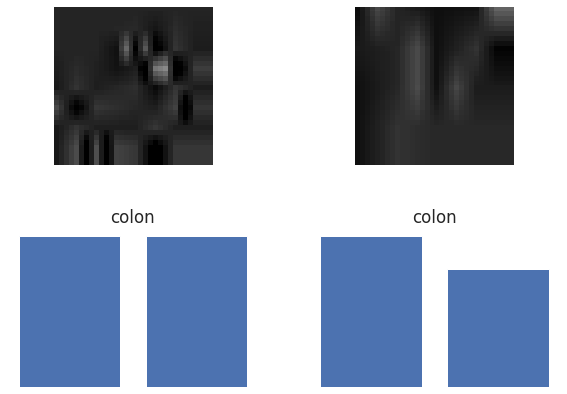

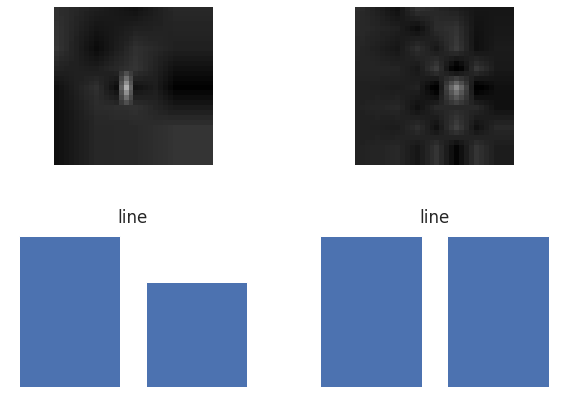

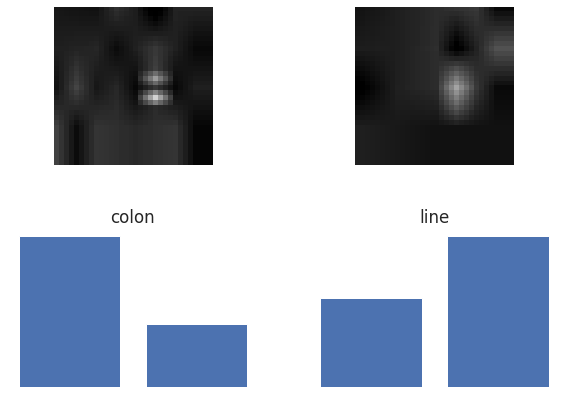

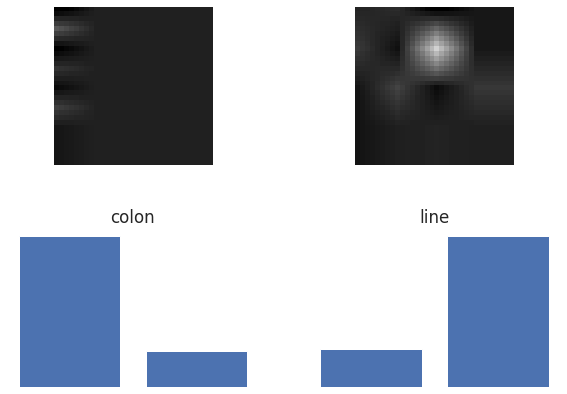

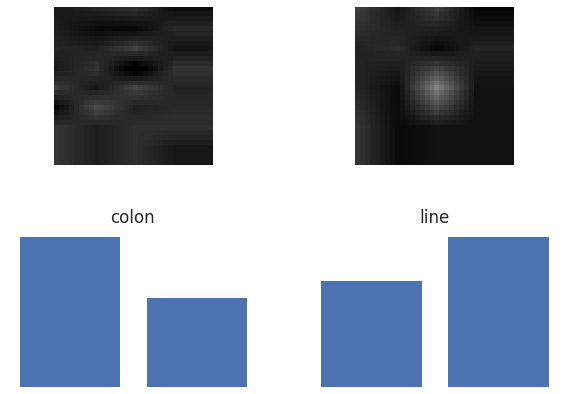

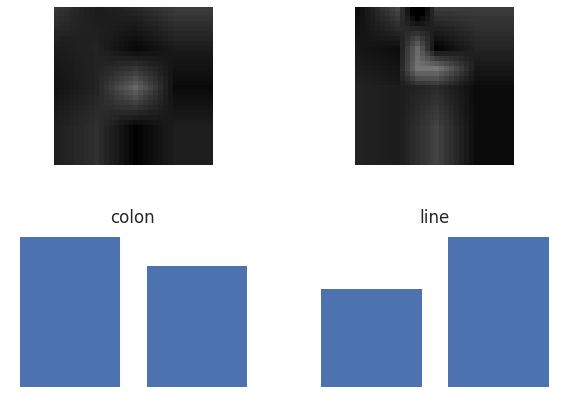

 
 
Extrapolation factor =  8.0
JPEG compression =  [50]
 
 


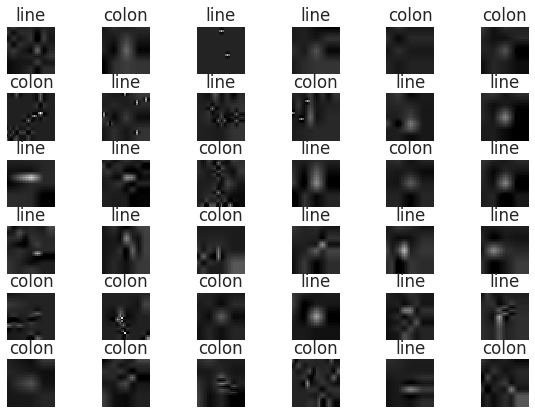

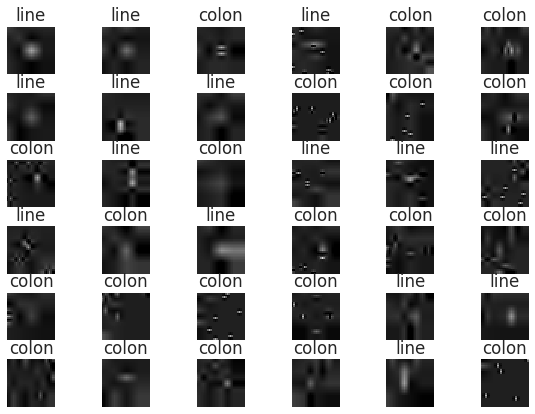

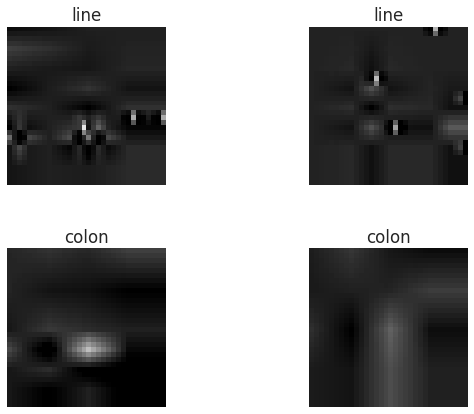

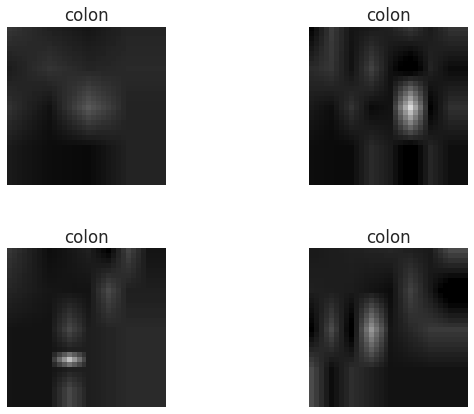

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 13s 218us/step - loss: 0.6212 - categorical_accuracy: 0.6462 - val_loss: 0.6173 - val_categorical_accuracy: 0.6488

Epoch 00001: val_categorical_accuracy improved from -inf to 0.64880, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 169us/step - loss: 0.6193 - categorical_accuracy: 0.6474 - val_loss: 0.6189 - val_categorical_accuracy: 0.6393

Epoch 00002: val_categorical_accuracy did not improve from 0.64880
Epoch 3/256
60000/60000 [==============================] - 10s 168us/step - loss: 0.6176 - categorical_accuracy: 0.6500 - val_loss: 0.6279 - val_categorical_accuracy: 0.6381

Epoch 00003: val_categorical_accuracy did not improve from 0.64880
Epoch 4/256
60000/60000 [==============================] - 10s 170us/step - loss: 0.6169 - categorical_accuracy: 0.6496 - val_loss: 0.6231 - val_categorical_accuracy: 0

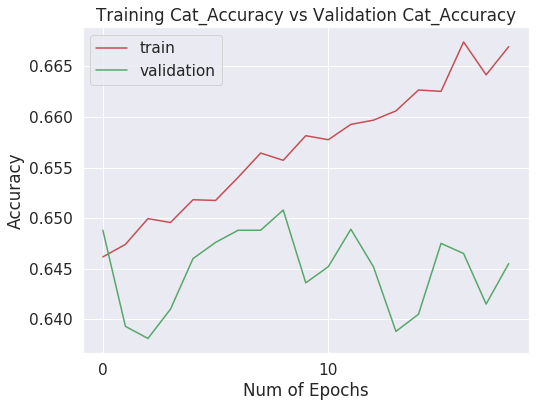

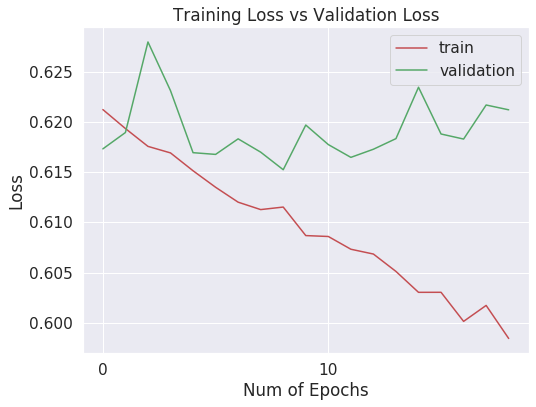

[[3330 1621]
 [1870 3179]]


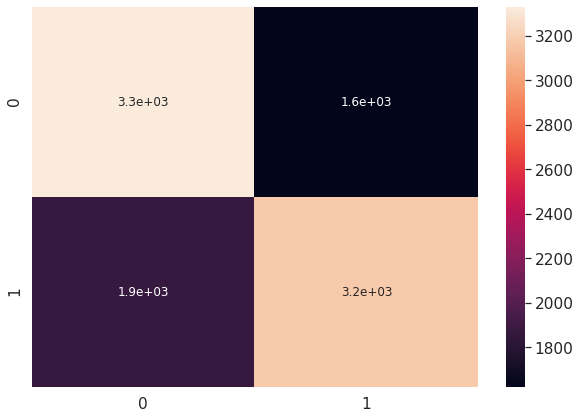

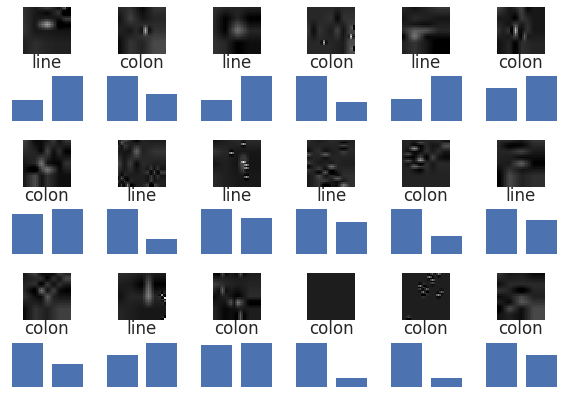

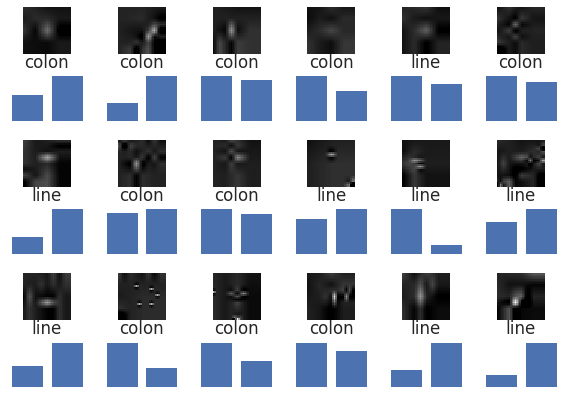

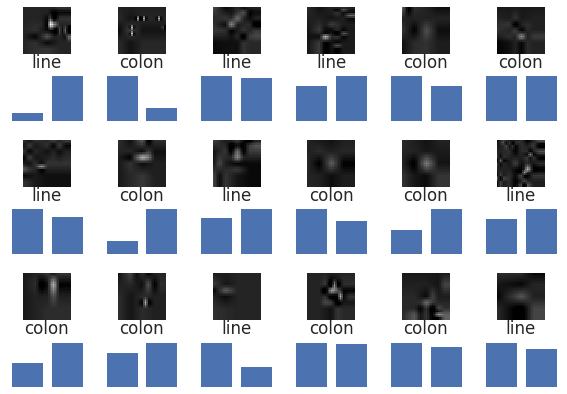

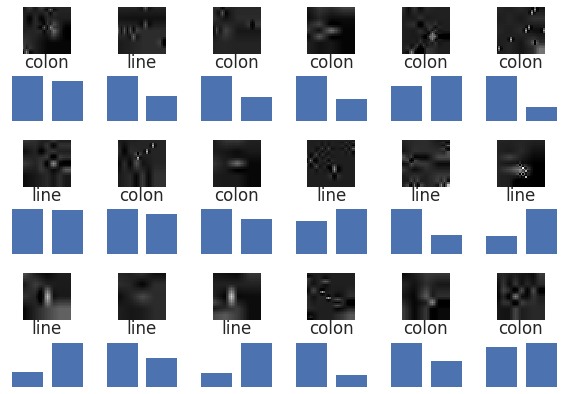

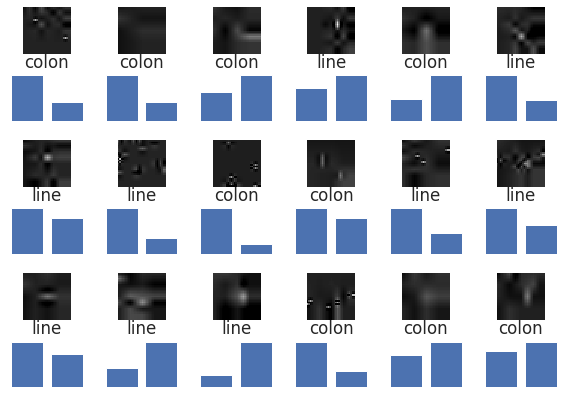

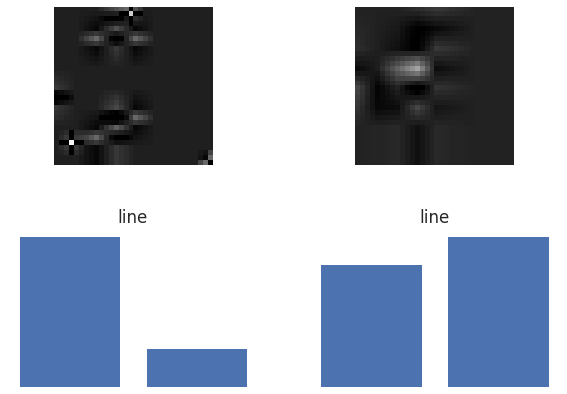

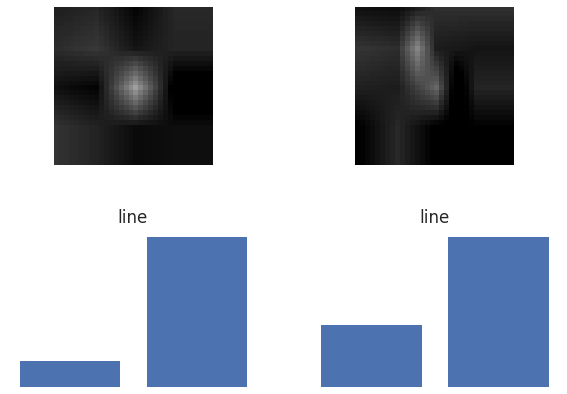

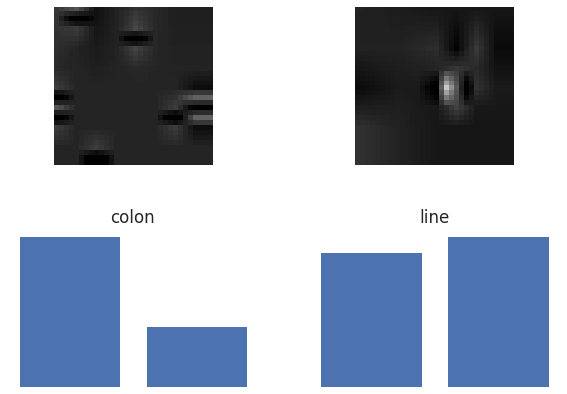

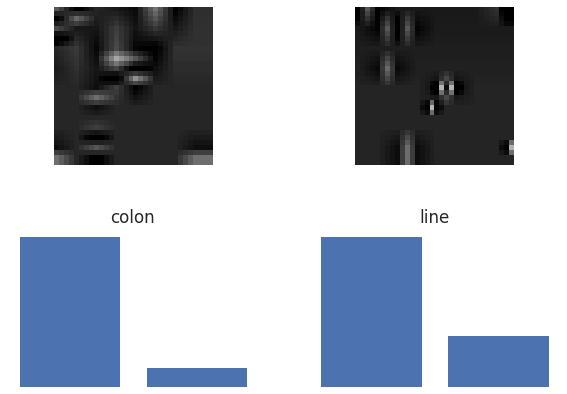

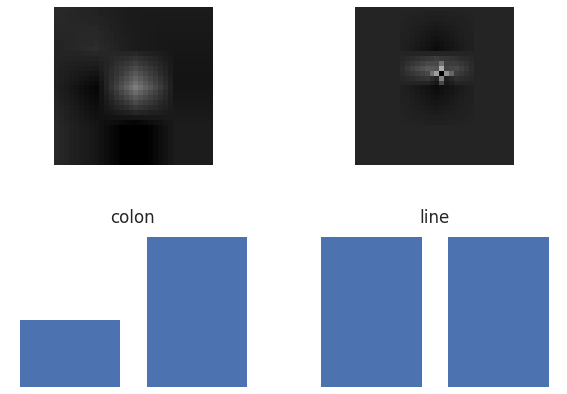

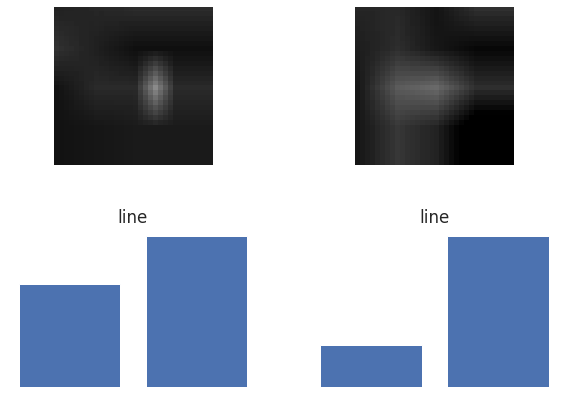

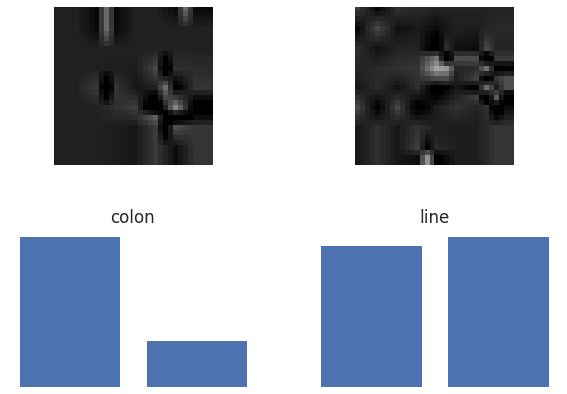

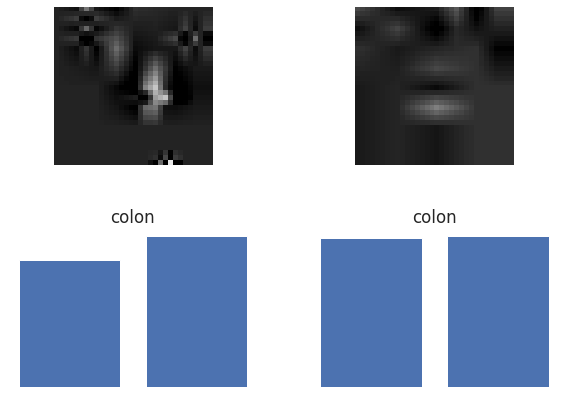

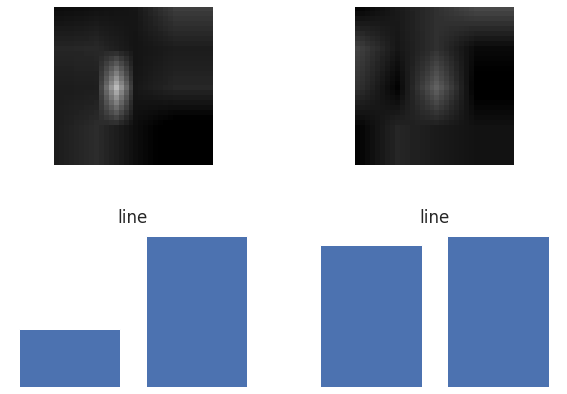

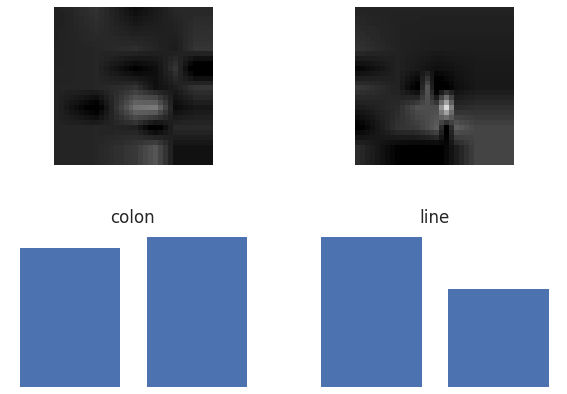

 
 
Extrapolation factor =  8.0
JPEG compression =  [30]
 
 


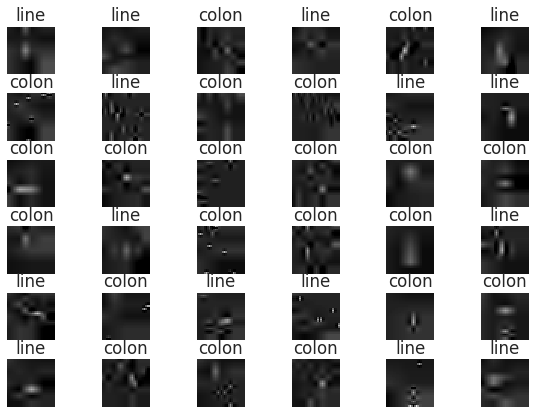

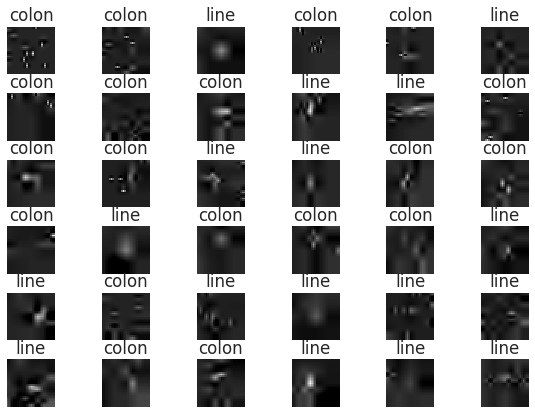

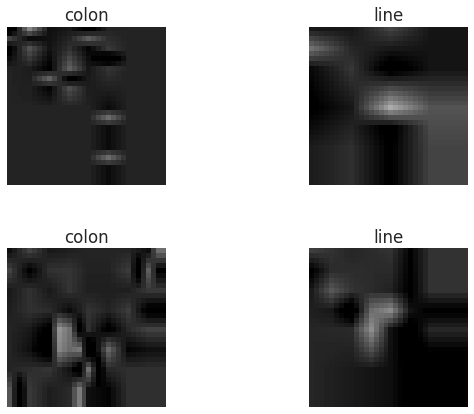

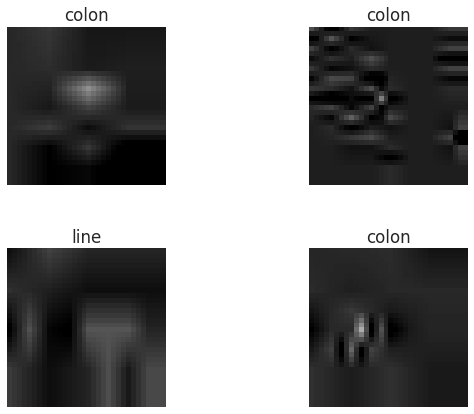

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 14s 225us/step - loss: 0.6196 - categorical_accuracy: 0.6470 - val_loss: 0.6254 - val_categorical_accuracy: 0.6444

Epoch 00001: val_categorical_accuracy improved from -inf to 0.64440, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 173us/step - loss: 0.6159 - categorical_accuracy: 0.6478 - val_loss: 0.6264 - val_categorical_accuracy: 0.6343

Epoch 00002: val_categorical_accuracy did not improve from 0.64440
Epoch 3/256
60000/60000 [==============================] - 10s 170us/step - loss: 0.6140 - categorical_accuracy: 0.6510 - val_loss: 0.6241 - val_categorical_accuracy: 0.6452

Epoch 00003: val_categorical_accuracy improved from 0.64440 to 0.64520, saving model to best_model.h5
Epoch 4/256
60000/60000 [==============================] - 10s 172us/step - loss: 0.6133 - categorical_accuracy: 0.6518 - val_loss: 0

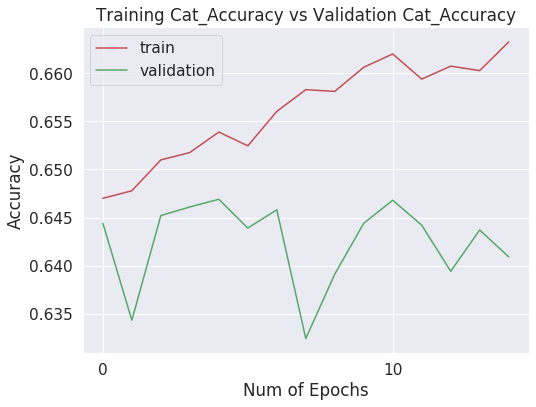

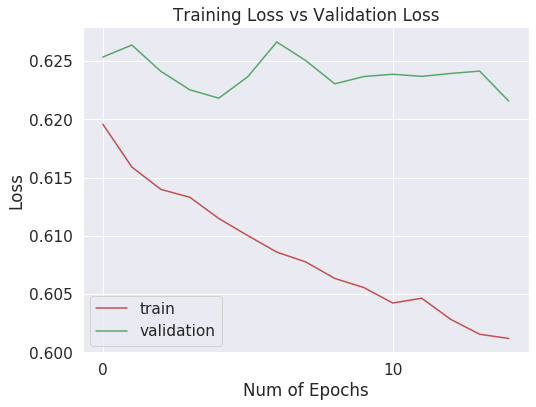

[[3617 1411]
 [2074 2898]]


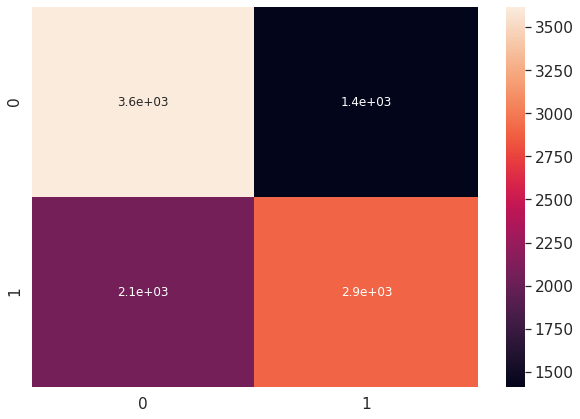

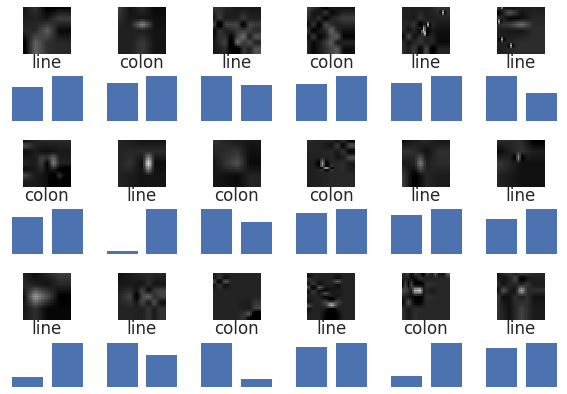

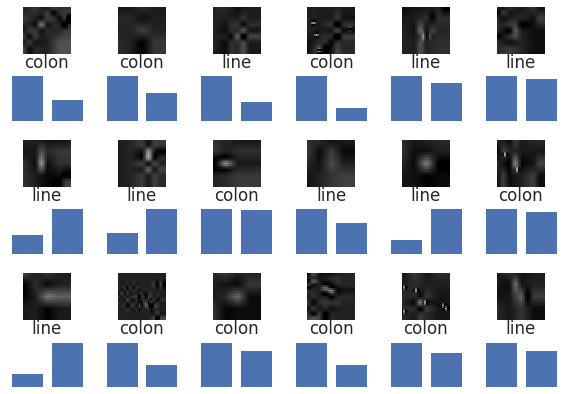

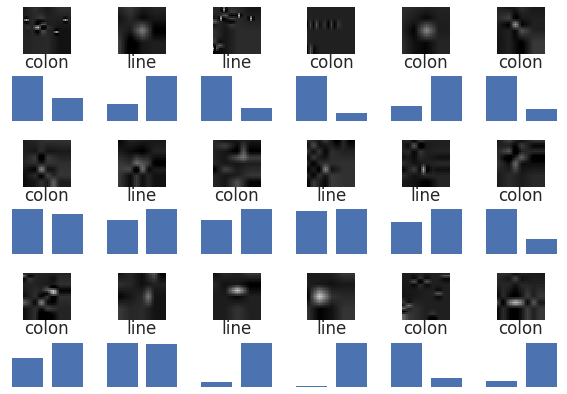

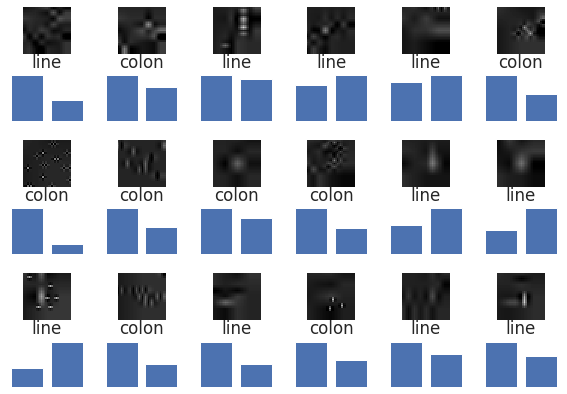

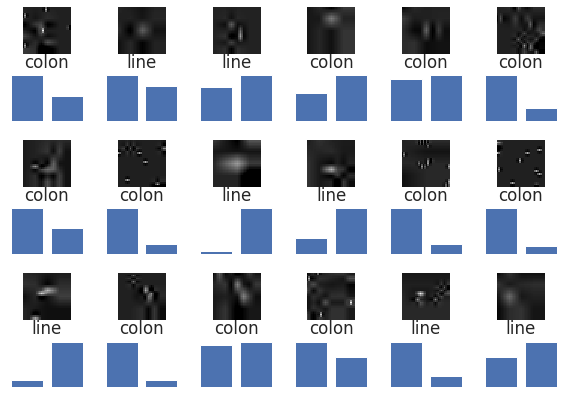

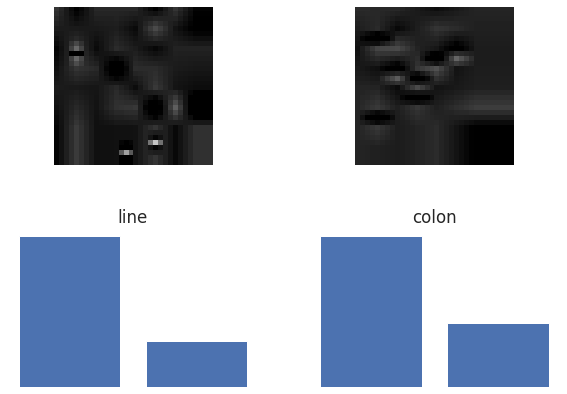

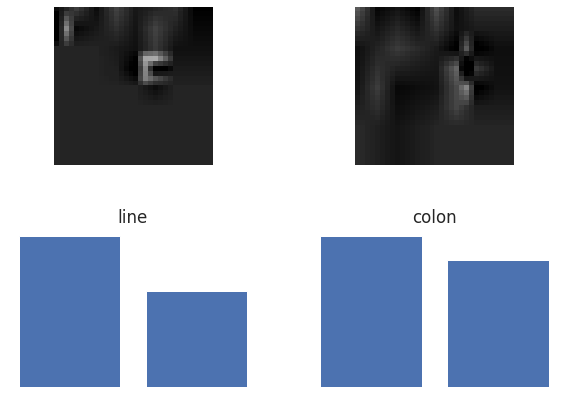

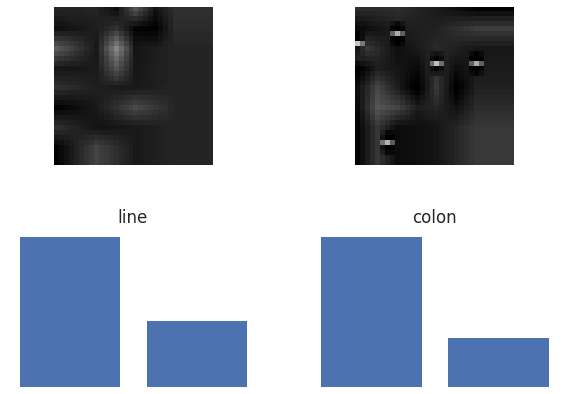

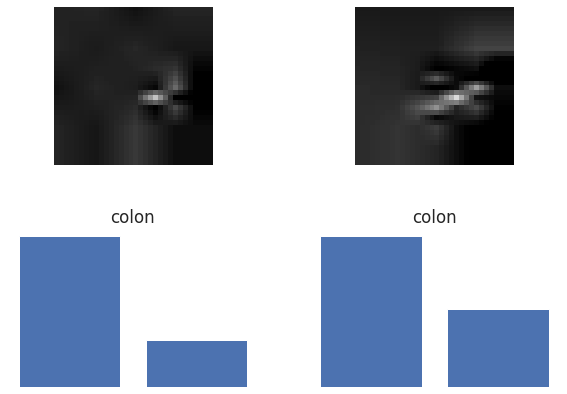

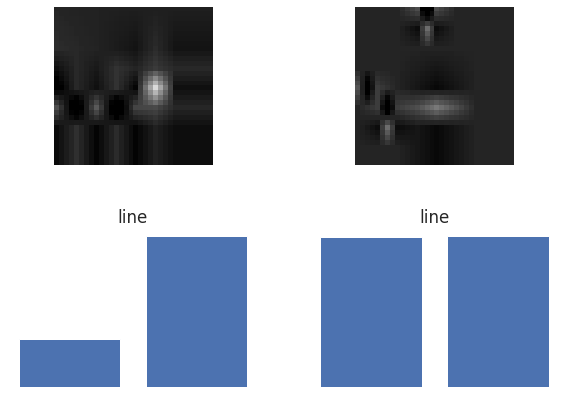

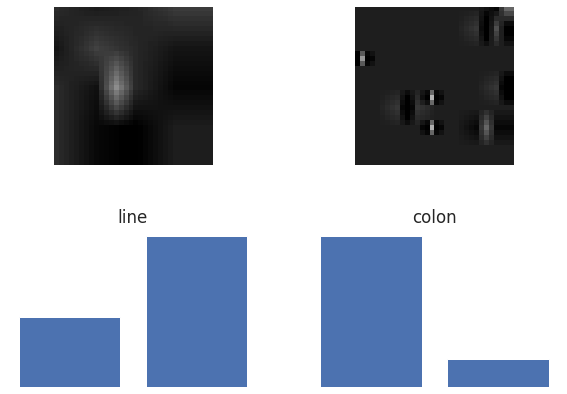

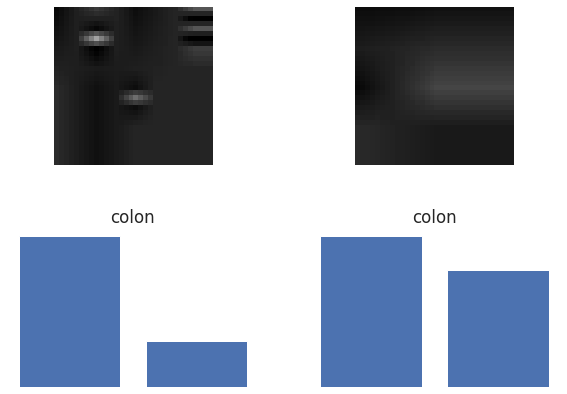

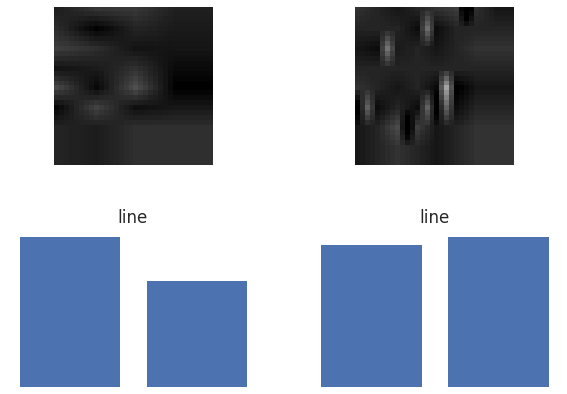

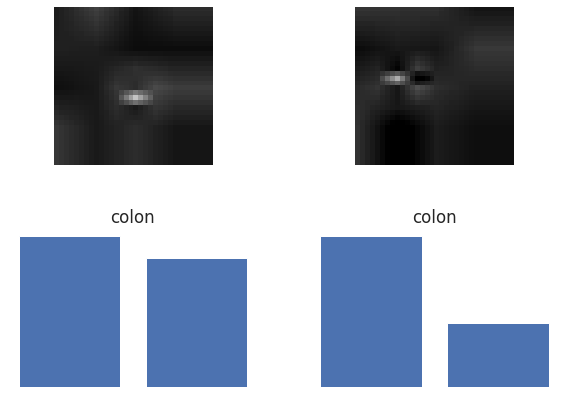

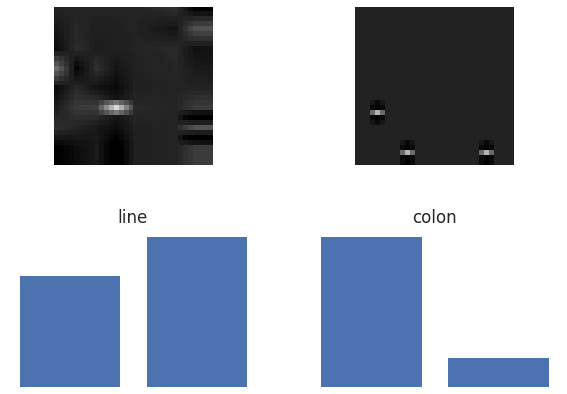

 
 
Extrapolation factor =  8.0
JPEG compression =  [10]
 
 


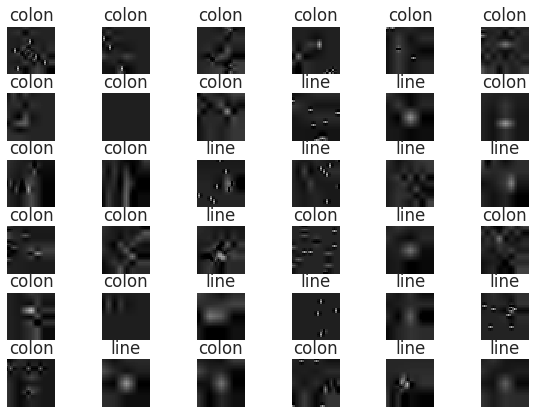

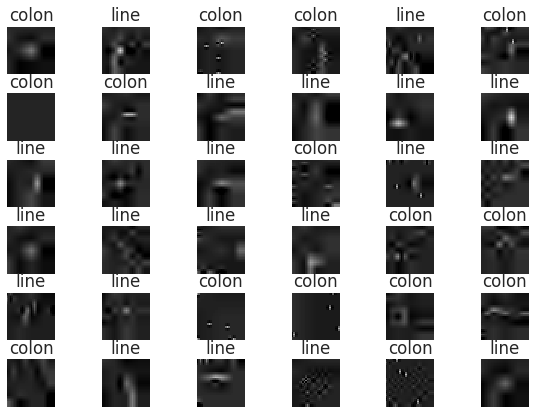

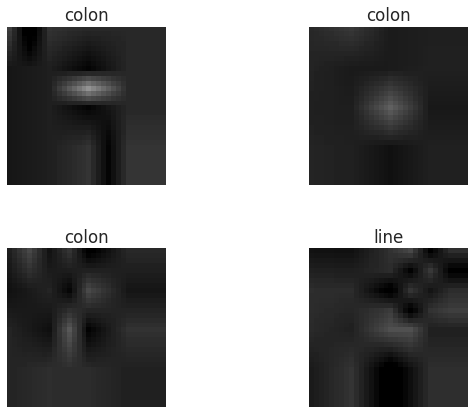

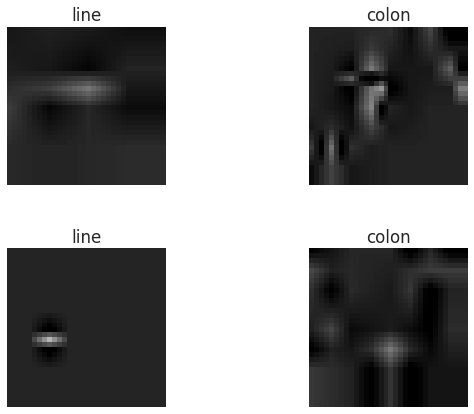

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 14s 230us/step - loss: 0.6184 - categorical_accuracy: 0.6470 - val_loss: 0.6198 - val_categorical_accuracy: 0.6535

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65350, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 170us/step - loss: 0.6168 - categorical_accuracy: 0.6492 - val_loss: 0.6161 - val_categorical_accuracy: 0.6540

Epoch 00002: val_categorical_accuracy improved from 0.65350 to 0.65400, saving model to best_model.h5
Epoch 3/256
60000/60000 [==============================] - 10s 170us/step - loss: 0.6141 - categorical_accuracy: 0.6534 - val_loss: 0.6209 - val_categorical_accuracy: 0.6505

Epoch 00003: val_categorical_accuracy did not improve from 0.65400
Epoch 4/256
60000/60000 [==============================] - 10s 169us/step - loss: 0.6142 - categorical_accuracy: 0.6495 - val_loss: 0

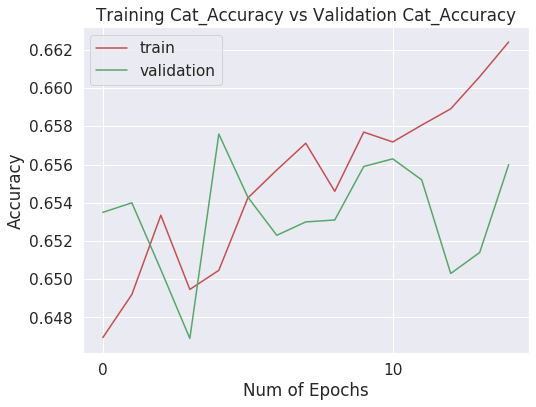

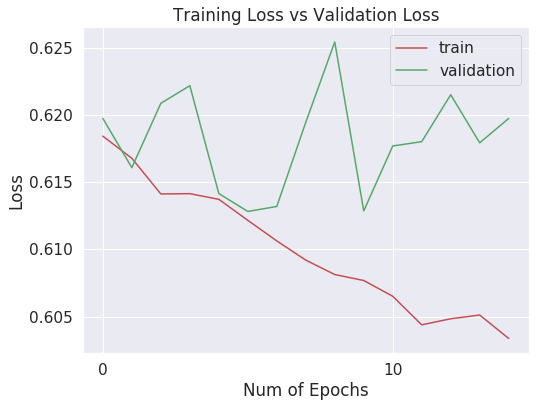

[[3311 1648]
 [1875 3166]]


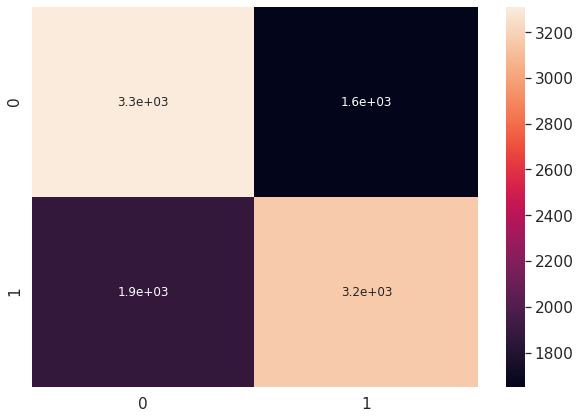

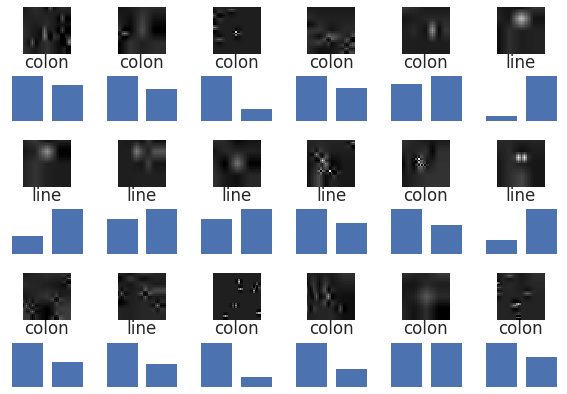

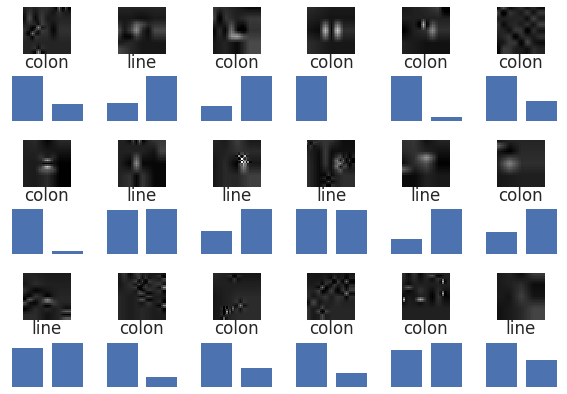

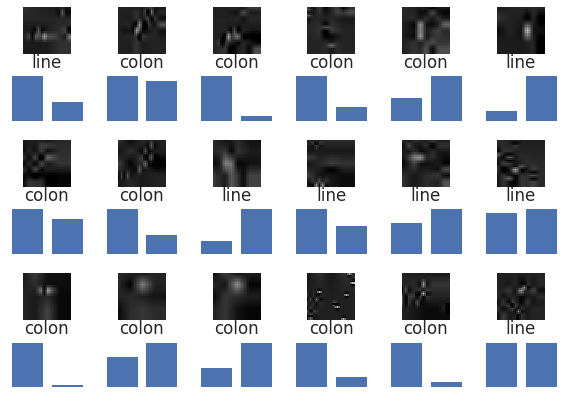

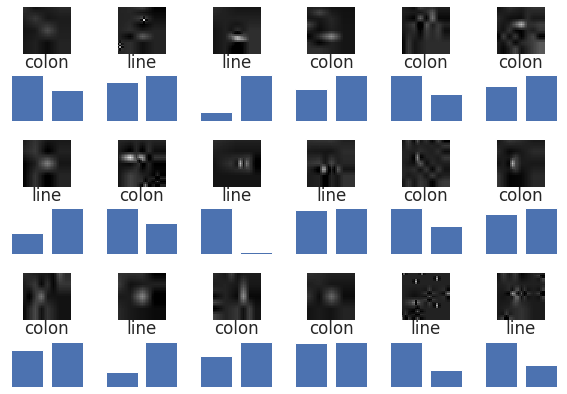

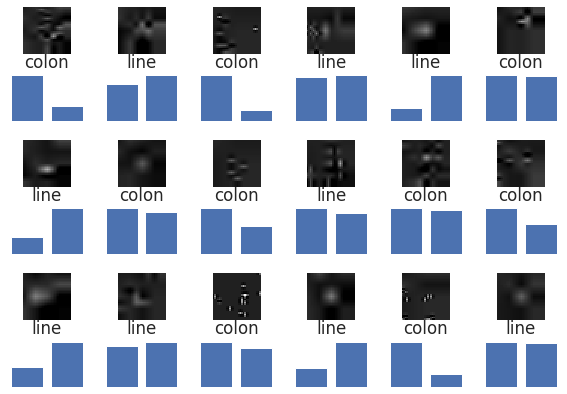

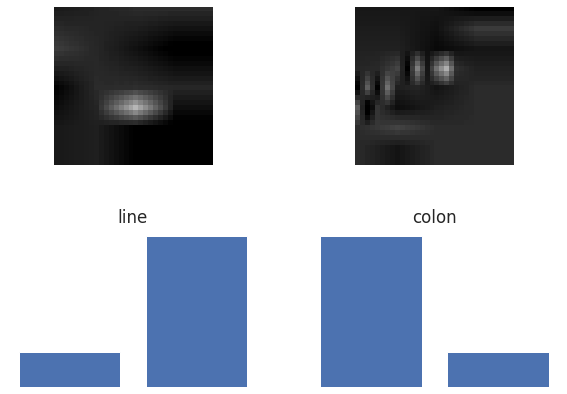

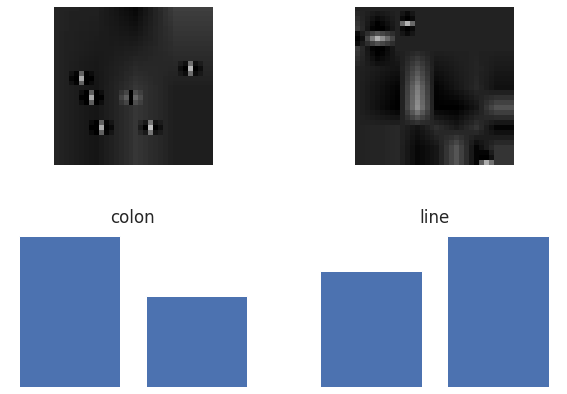

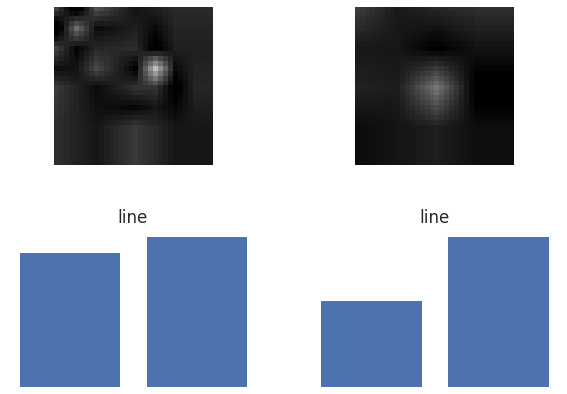

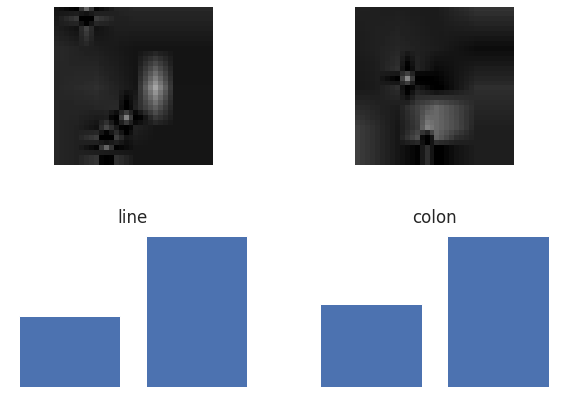

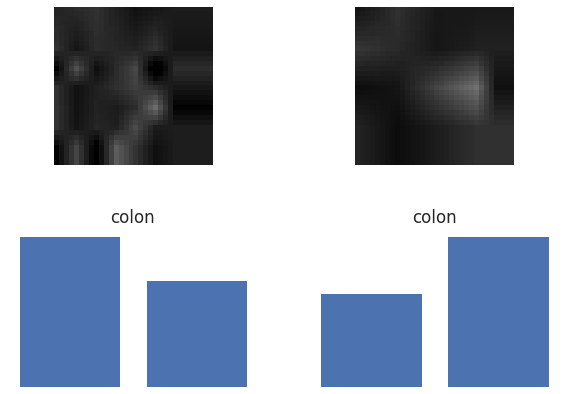

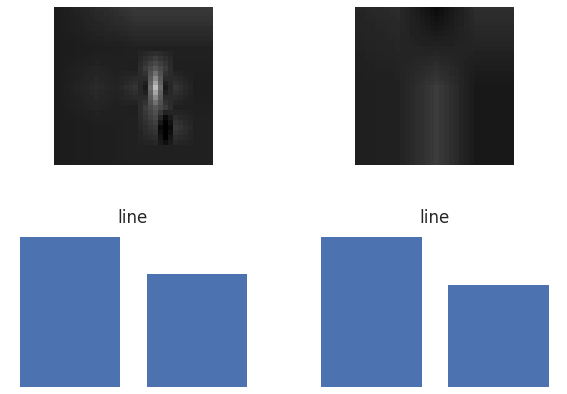

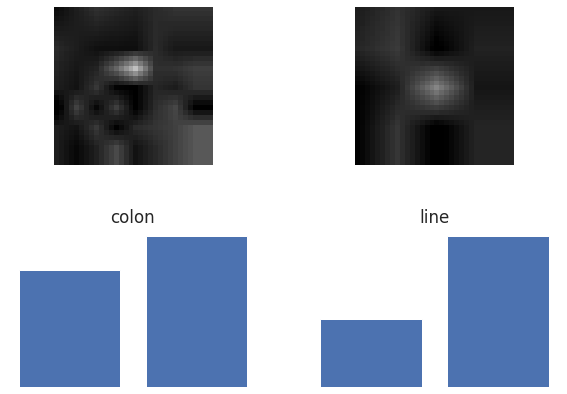

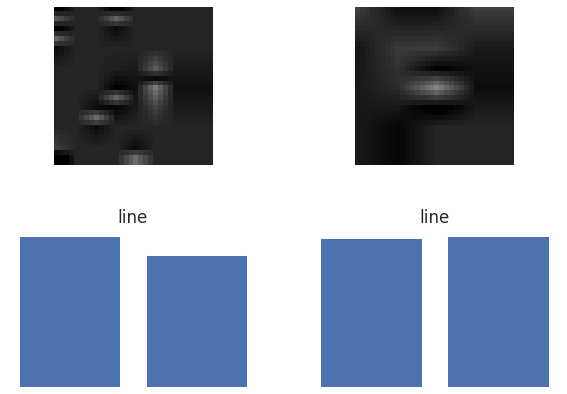

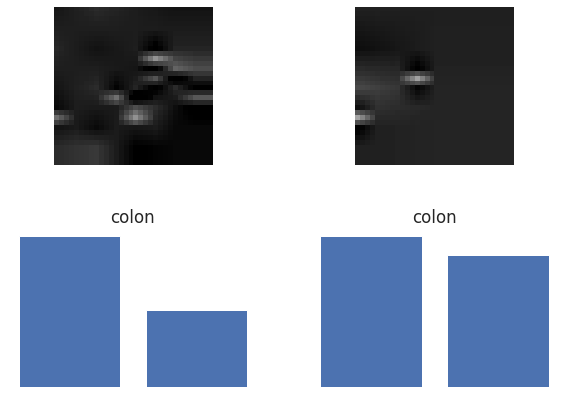

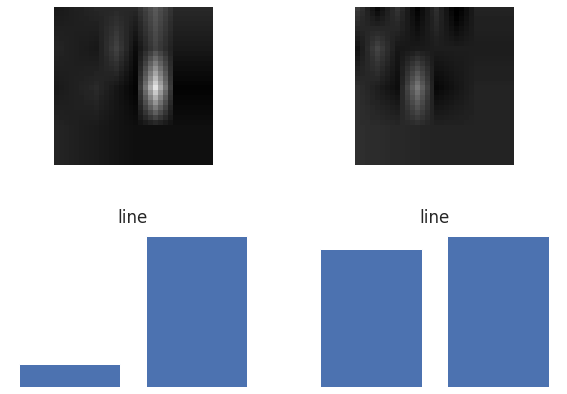

 
 
Extrapolation factor =  8.0
JPEG compression =  [4]
 
 


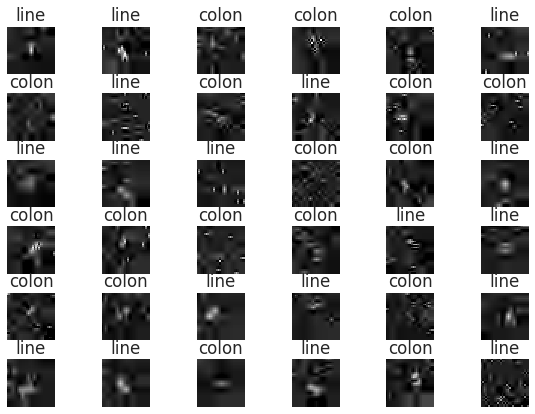

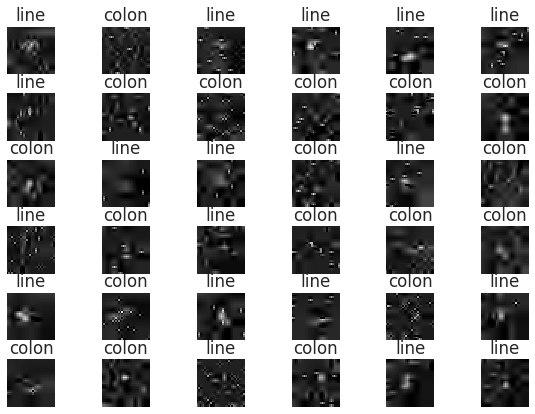

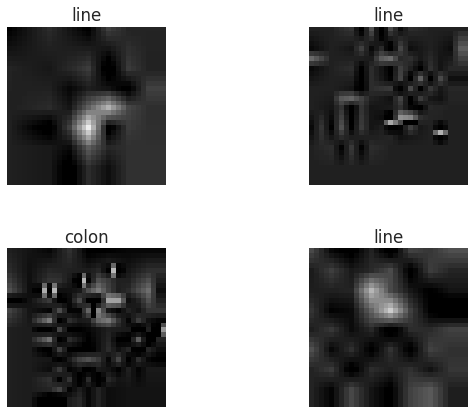

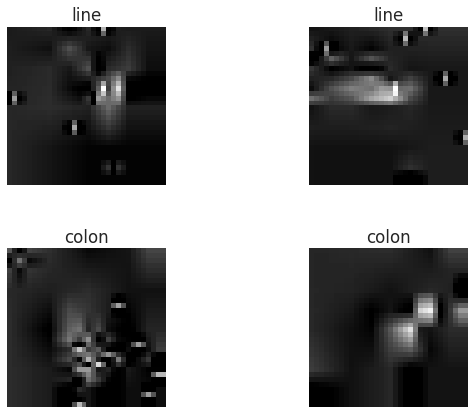

yy_train  (60000, 1, 2)
Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 14s 239us/step - loss: 0.5723 - categorical_accuracy: 0.6930 - val_loss: 0.5604 - val_categorical_accuracy: 0.6908

Epoch 00001: val_categorical_accuracy improved from -inf to 0.69080, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 10s 173us/step - loss: 0.5654 - categorical_accuracy: 0.6949 - val_loss: 0.5631 - val_categorical_accuracy: 0.6959

Epoch 00002: val_categorical_accuracy improved from 0.69080 to 0.69590, saving model to best_model.h5
Epoch 3/256
60000/60000 [==============================] - 10s 172us/step - loss: 0.5603 - categorical_accuracy: 0.6999 - val_loss: 0.5592 - val_categorical_accuracy: 0.6974

Epoch 00003: val_categorical_accuracy improved from 0.69590 to 0.69740, saving model to best_model.h5
Epoch 4/256
60000/60000 [==============================] - 10s 171us/step - loss: 0.5593 - categor

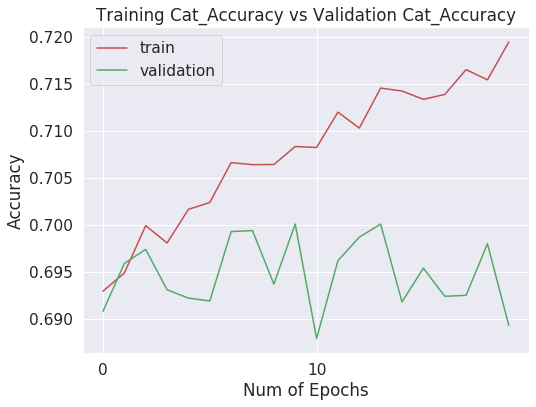

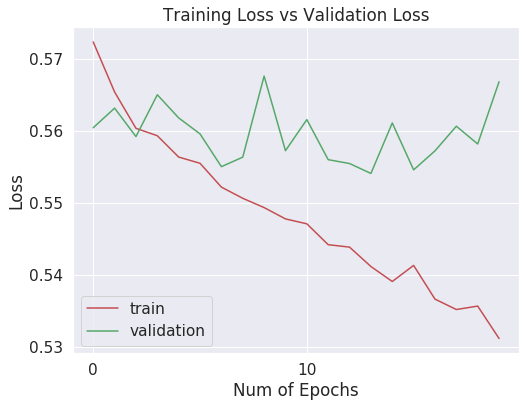

[[3471 1505]
 [1530 3494]]


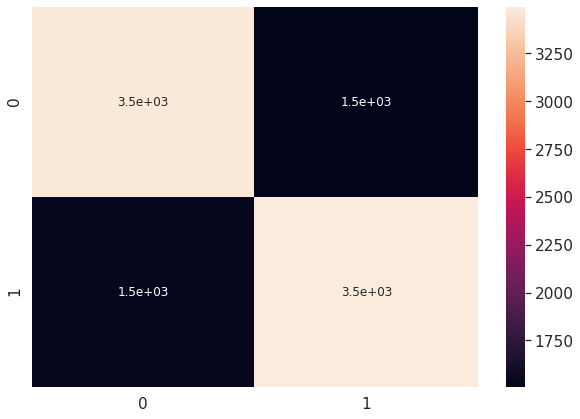

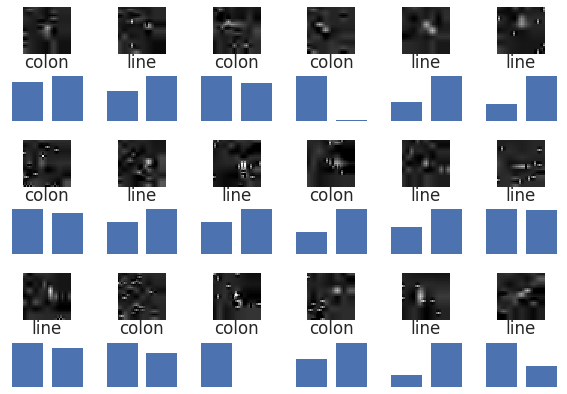

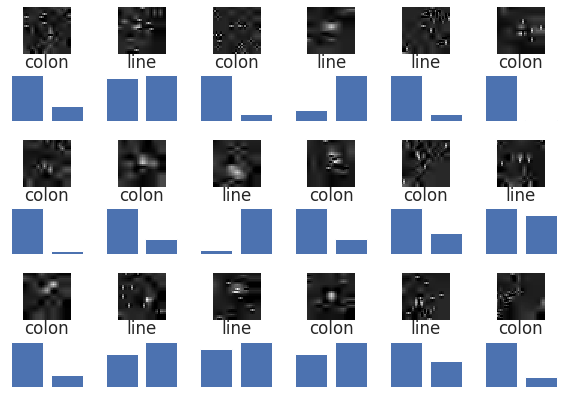

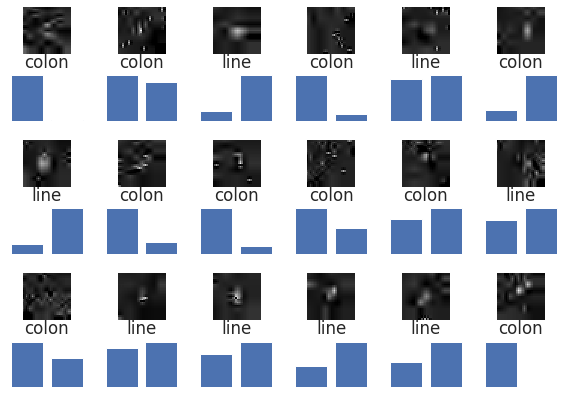

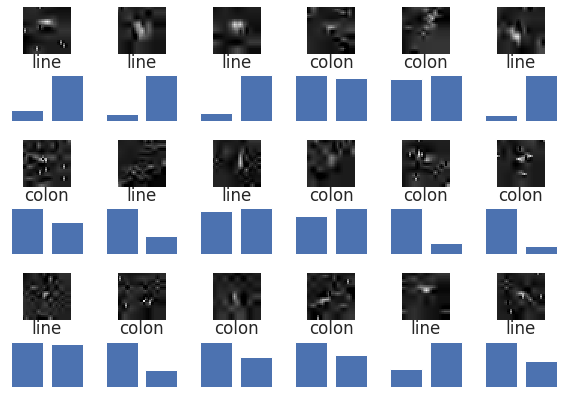

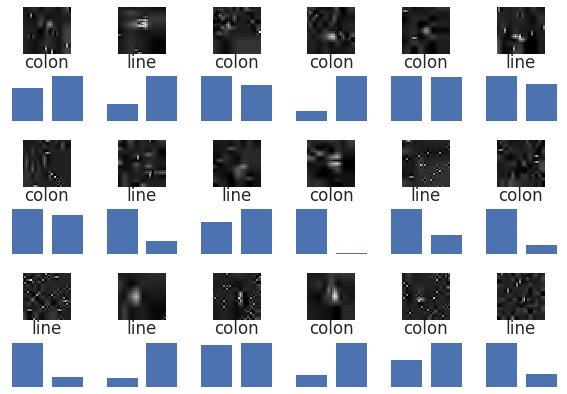

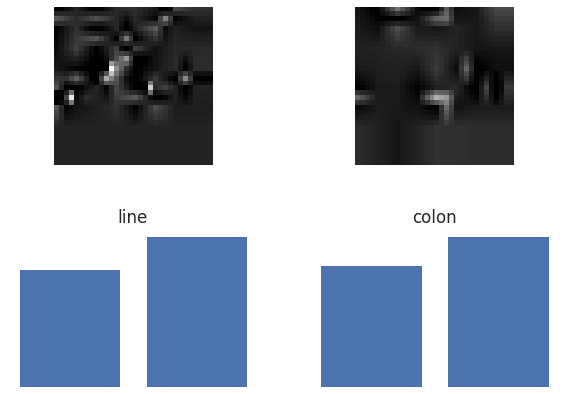

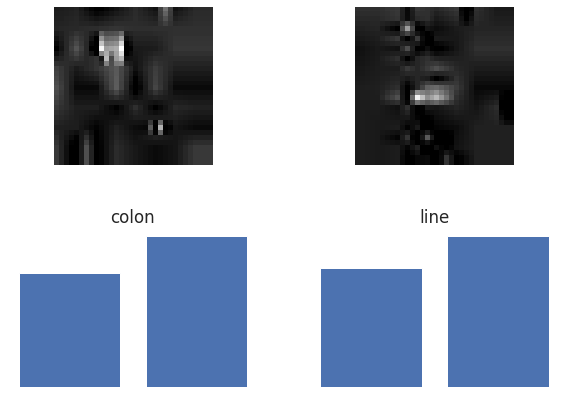

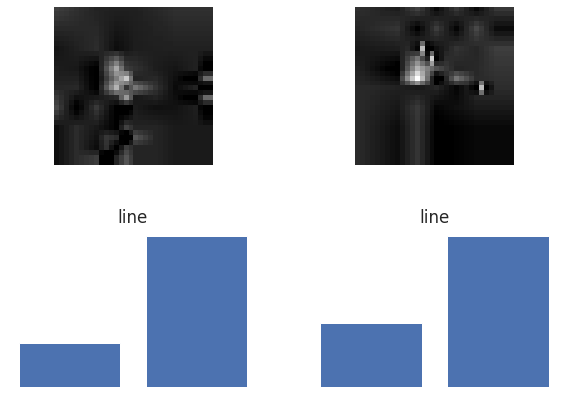

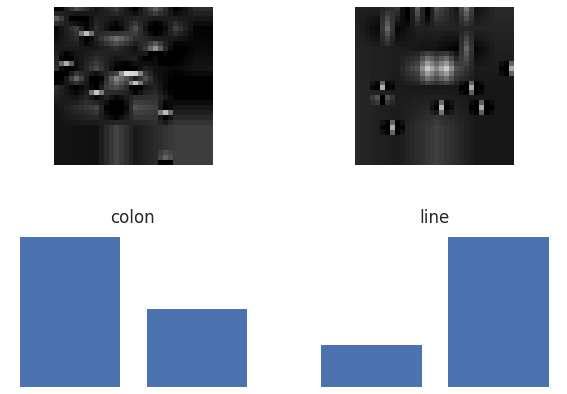

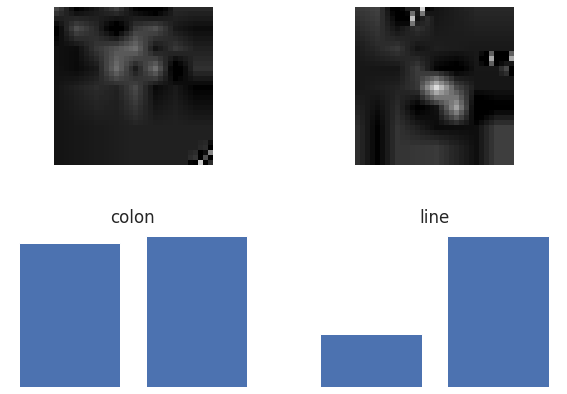

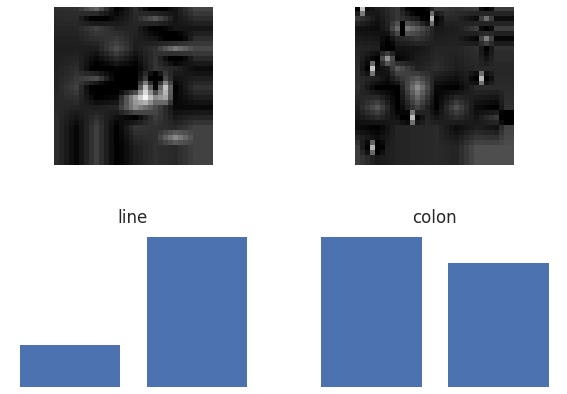

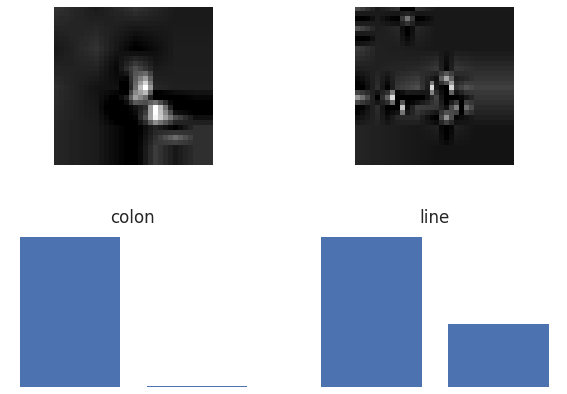

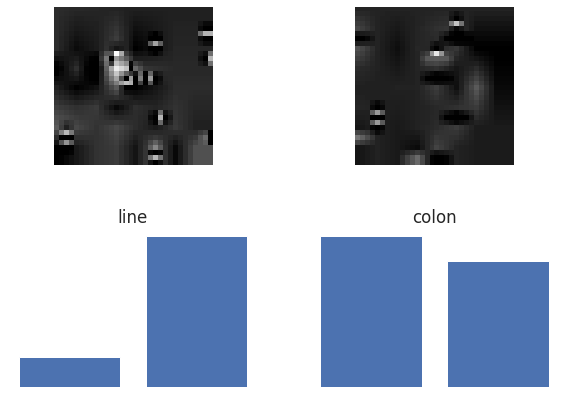

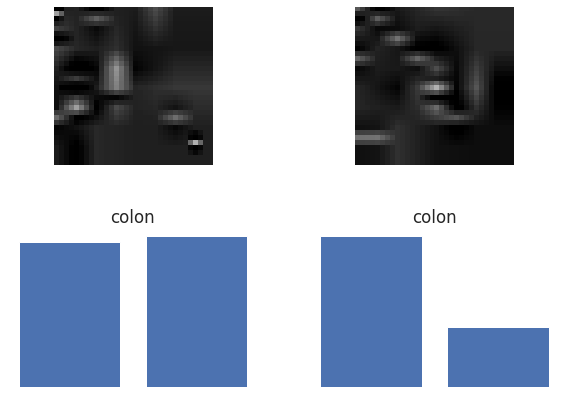

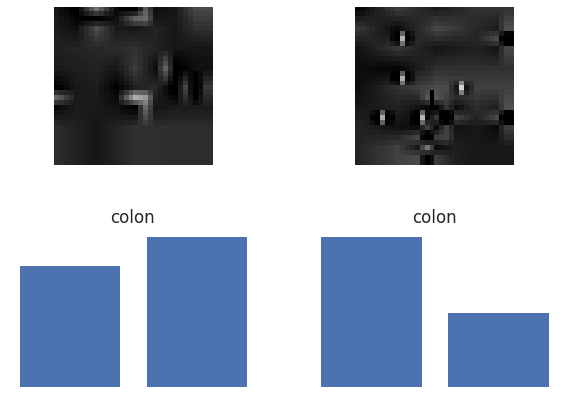

In [18]:
#acc_scores = []
#loss_scores = []

outcome = []

# Loop over extrapolations
for extrapolation_factor in extrapolation_list:

 # Loop over jpeg qualities
 if jpeg_format == 'jpeg':
   compression_list = jpeg_compression_list
 else:
  compression_list = jpeg2000_compression_list

 for jpeg_compression in compression_list:

   print(" ")
   print(" ")
   print("Extrapolation factor = ",extrapolation_factor)
   print("JPEG compression = ",jpeg_compression)
   print(" ")
   print(" ")
 
   # Generate data
   xx_train, xx_test, xx_val, yy_train, yy_test, yy_val = generate_datasets()

   #plot 100 figures (random offset)

   plot_images(6)
   plot_images(6)

   plot_images(2)
   plot_images(2)


   yy_train = np_utils.to_categorical(yy_train, num_classes)
   yy_test = np_utils.to_categorical(yy_test, num_classes)
   yy_val = np_utils.to_categorical(yy_val, num_classes)

   print("yy_train ",yy_train.shape)

   #Define the network
   cnn_n = base_model()
   # load the previously saved model
   try:
      cnn_n = load_model('best_model.h5')
   except:
      print("No saved model, training a new one.") 

   # patient early stopping
   es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
   mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

   # fit model
   cnn = cnn_n.fit(xx_train, yy_train, batch_size=batch_size, epochs=epochs, validation_data=(xx_test,yy_test),shuffle=True, callbacks=[es, mc])
   # load the saved model
   saved_model = load_model('best_model.h5')


   # evaluate loaded model
   scores_train = saved_model.evaluate(xx_train, yy_train, verbose=0)
   scores_test  = saved_model.evaluate(xx_test,  yy_test,  verbose=0)
   scores_val   = saved_model.evaluate(xx_val,   yy_val,   verbose=0)
   print("Accuracy Train: %.2f%% , Test: %.2f%% Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

   # add scores
#   acc_scores.append(scores_val[1]*100)
#   loss_scores.append(scores_val[0]*100)
   outcome_row = (extrapolation_factor, jpeg_compression, scores_val[1]*100, scores_val[0]*100)
   outcome.append(outcome_row)

   #Plot training results
   plot_training_results(cnn)
   # Confussion matrix result
   draw_confussion_matrix()

   # Plot classified images
   plot_results(6)
   plot_results(6)
   plot_results(6)
   plot_results(6)
   plot_results(6)

   plot_results(2)
   plot_results(2)
   plot_results(2)
   plot_results(2)
   plot_results(2)
   plot_results(2)
   plot_results(2)
   plot_results(2)
   plot_results(2)
   plot_results(2)



# **Draw accuracy and loss vs. jpeg quality**

[(0.125, [100], 65.25, 61.344778871536256), (0.125, [50], 64.66, 61.861730651855474), (0.125, [30], 65.14999999999999, 61.75237770080566), (0.125, [10], 64.87, 62.52929401397706), (0.125, [4], 70.08, 54.92066827774048), (1.0, [100], 65.36, 61.4179451084137), (1.0, [50], 65.42, 61.153568096160896), (1.0, [30], 65.66, 60.93004509925842), (1.0, [10], 64.19, 62.135232210159295), (1.0, [4], 69.78999999999999, 55.679319038391114), (8.0, [100], 65.28, 62.00415475845337), (8.0, [50], 65.09, 61.63486456871033), (8.0, [30], 65.14999999999999, 61.72167485237121), (8.0, [10], 64.77000000000001, 62.0924679851532), (8.0, [4], 69.65, 56.358518505096434)]
[[100]] [65.25]
plot  0.125 [[100], [50], [30], [10], [4]] [65.25, 64.66, 65.14999999999999, 64.87, 70.08]
plot  1.0 [[100], [50], [30], [10], [4]] [65.36, 65.42, 65.66, 64.19, 69.78999999999999]
plot  8.0 [[100], [50], [30], [10], [4]] [65.28, 65.09, 65.14999999999999, 64.77000000000001, 69.65]


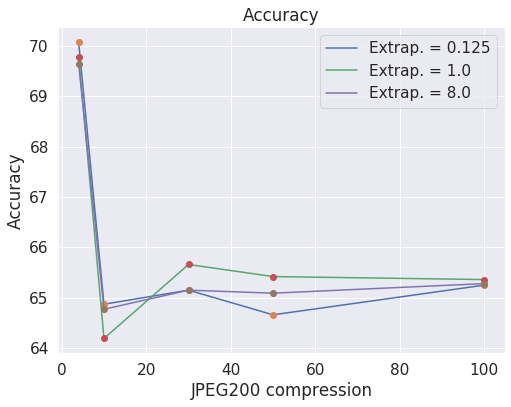

In [19]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][2])
     compr.append(outcome[row][1])
     print(compr, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     poly.append(outcome[row][2])
     compr.append(outcome[row][1])
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][2])
     compr.append(outcome[row][1])  
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)          
   else:
     poly.append(outcome[row][2])
     compr.append(outcome[row][1])



pyl.legend() 

pyl.title("Accuracy")
pyl.xlabel("JPEG200 compression")
pyl.ylabel("Accuracy")
pyl.show()

#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


In [0]:
#plot loss
#pyl.plot(jpeg_compression_list, loss_scores)
#pyl.plot(jpeg_compression_list, loss_scores,'o')
#pyl.title("Loss")
#pyl.xlabel("JPEG quality")
#pyl.ylabel("Loss")
#pyl.show()